
## Delta GPTs - (Train on 100, 200, 300 and predict the next 20)

* Delta: SI differences
* compare 100 to 200 to 300
* Written to run on GPU
* Long train so best run on GPU
* Next Cast is green line
* Saves Results to text file



## Parameters


In [1]:

vocab_size = 1000

comment_exp = "tok_embMpos_embMconv_embMper_conv_emb"



## Experimental Details


In [2]:


exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.close()




## Libraries


In [3]:

##!pip install xgboost
## !pip install matplotlib
## !pip install scikit-learn
## !pip install einops


In [4]:

import pandas as pd
import numpy as np


In [5]:

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


In [6]:

## import xgboost as xgb
## from xgboost import XGBClassifier, XGBRegressor, DMatrix, train as train_xgb


In [7]:


import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import numpy as np
import torch
import pandas as pd
import sklearn
import random
import math


In [8]:

from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

## coefficient of determination 
from sklearn.metrics import r2_score



## Univariate permutation example


In [9]:

from einops import rearrange
from math import sqrt, log


In [10]:

patch_size = 10
stride     = 4

x_enc = torch.rand( 8, 40, 24)
print( x_enc.shape )

B, L, M = x_enc.shape
print(B)
print(L)
print(M)

x_enc = rearrange(x_enc, 'b l m -> b m l')
print( x_enc.shape )

x_enc = x_enc.unfold(dimension=-1, size=patch_size, step=stride)
print( x_enc.shape )

x_enc = rearrange(x_enc, 'b m n p -> (b m) n p')
x_enc.shape


torch.Size([8, 40, 24])
8
40
24
torch.Size([8, 24, 40])
torch.Size([8, 24, 8, 10])


torch.Size([192, 8, 10])


## Positional Encoding example


In [11]:

def PositionalEncoding(q_len, d_model, normalize=True):
    pe = torch.zeros(q_len, d_model)
    position = torch.arange(0, q_len).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    if normalize:
        pe = pe - pe.mean()
        pe = pe / (pe.std() * 10)
    return pe


In [12]:

res = PositionalEncoding(15, 512, normalize=True)
res.shape


torch.Size([15, 512])

In [13]:

device = "cpu"


In [14]:

x_enc = torch.rand( 8, 15, 512)
print( x_enc.shape )


torch.Size([8, 15, 512])


In [15]:

pos_emb_table_rc         = nn.Embedding(15, 512)     ## [15, 512]


In [16]:

torch.arange(15, device=device)



tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [17]:

pos_emb = pos_emb_table_rc( torch.arange(15, device=device) ) 


In [18]:

pos_emb.shape


torch.Size([15, 512])

In [19]:

res = x_enc + pos_emb


In [20]:

res.shape


torch.Size([8, 15, 512])


## Moving Avg example


In [21]:

'''

class moving_avg(nn.Module):

    def __init__(self, x):
        
        super().__init__()
        
        self.kernel_size = x.shape[2]
        self.stride      = 1
        self.avg = nn.AvgPool1d(kernel_size=self.kernel_size, stride=self.stride)

    def forward(self, x):
        

        x = self.avg( x )         ## x.permute(0, 2, 1))
        
        ## x = x.permute(0, 2, 1)
        
        return x

'''


'\n\nclass moving_avg(nn.Module):\n\n    def __init__(self, x):\n        \n        super().__init__()\n        \n        self.kernel_size = x.shape[2]\n        self.stride      = 1\n        self.avg = nn.AvgPool1d(kernel_size=self.kernel_size, stride=self.stride)\n\n    def forward(self, x):\n        \n\n        x = self.avg( x )         ## x.permute(0, 2, 1))\n        \n        ## x = x.permute(0, 2, 1)\n        \n        return x\n\n'

In [22]:

'''

x_enc = torch.rand( 8, 40, 5)

print( x_enc.shape )

obj_mov_avg = moving_avg( x_enc  )

res = obj_mov_avg( x_enc )

print( x_enc[1, 2, :])

ans = x_enc - res

print( ans[1, 2, :])

print( ans.shape )

'''



'\n\nx_enc = torch.rand( 8, 40, 5)\n\nprint( x_enc.shape )\n\nobj_mov_avg = moving_avg( x_enc  )\n\nres = obj_mov_avg( x_enc )\n\nprint( x_enc[1, 2, :])\n\nans = x_enc - res\n\nprint( ans[1, 2, :])\n\nprint( ans.shape )\n\n'


## Read the data


In [23]:

for_RNN_data_CIVS = pd.read_csv('input/RNN_time_DELAYS_2000_PerCast_rcalix.csv')


In [24]:

for_RNN_data_CIVS


Unnamed: 0     SI_f1  HOST_BLAST_MOISTURE_f3  HOT_BLAST_TMP_NS_f3  \
0              1  0.719500                4.242439          2161.425209   
1              2  0.710486                4.174343          2168.238915   
2              3  0.666106                4.126144          2167.779119   
3              4  0.675145                4.120736          2166.974740   
4              5  0.776831                4.120331          2166.384674   
...          ...       ...                     ...                  ...   
1378        1379  0.762500                4.204430          2169.361647   
1379        1380  0.646000                4.208539          2169.079601   
1380        1381  0.654667                4.212648          2168.797556   
1381        1382  0.591667                4.217784          2168.444999   
1382        1383  0.724667                4.223948          2167.967389   

      NAT_GAS _INJECTION_f3  WINDRATE_f3  HIGH_PURITY_OXYGEN_f3  COAL_FLOW_f3  \
0               9306.840913   184.818611                    0.0           0.0   
1               9336.364456   185.993447                    0.0           0.0   
2               9419.200115   185.828474                    0.0           0.0   
3               9564.165802   185.924481                    0.0           0.0   
4               9648.247637   185.942943                    0.0           0.0   
...                     ...          ...                    ...           ...   
1378            9297.484543   185.046491                    0.0           0.0   
1379            9312.779010   185.053796                    0.0           0.0   
1380            9303.753420   185.007919                    0.0           0.0   
1381            9333.448101   184.942435                    0.0           0.0   
1382            9321.819731   184.863855                    0.0           0.0   

      Cast_Avg_Mn_f2  Slag_Fe_f2  ...  SE_Uptake_f3  NW_Uptake_f3  \
0              0.354        0.16  ...    182.533770    148.126483   
1              0.313        0.83  ...    183.725050    148.161842   
2              0.360        0.10  ...    195.812061    147.562523   
3              0.319        0.34  ...    188.028883    147.807509   
4              0.335        0.28  ...    200.141261    149.014319   
...              ...         ...  ...           ...           ...   
1378           0.343        0.30  ...    185.900341    148.103530   
1379           0.324        0.30  ...    182.408576    148.106012   
1380           0.325        0.16  ...    181.684649    148.108493   
1381           0.335        0.26  ...    195.202191    148.111595   
1382           0.328        1.08  ...    220.149599    148.115317   

      SW_Uptake_f3  Slag_SiO2_f2  Slag_CaO_f2  Slag_MgO_f2  \
0       192.512412     37.369999    36.439999         9.86   
1       192.366046     35.540001    35.970001         9.03   
2       198.423474     34.849998    36.590000         9.13   
3       179.116839     34.009998    35.900002         8.82   
4       186.052137     34.380001    35.970001         8.73   
...            ...           ...          ...          ...   
1378    199.914193     35.900002    37.259998        10.04   
1379    193.501805     35.900002    37.259998        10.04   
1380    194.328694     35.580002    36.500000         9.30   
1381    215.606202     35.130001    37.470001        10.01   
1382    250.937261     35.570000    36.970001         9.47   

      SNORT_VALVE_POSITION_f3  TOP_PRESS_f3  HOT_BLAST_PRESSURE_f3  \
0                   98.334297     18.532928              36.602600   
1                   98.334297     18.397217              36.882963   
2                   98.334297     18.393974              36.568884   
3                   98.334297     18.370316              36.839147   
4                   98.334297     18.395860              36.658018   
...                       ...           ...                    ...   
1378                98.334297     18.209401              36.727897  

In [25]:

cols_list_DF = for_RNN_data_CIVS.columns.values.tolist()
cols_list_DF


['Unnamed: 0',
 'SI_f1',
 'HOST_BLAST_MOISTURE_f3',
 'HOT_BLAST_TMP_NS_f3',
 'NAT_GAS _INJECTION_f3',
 'WINDRATE_f3',
 'HIGH_PURITY_OXYGEN_f3',
 'COAL_FLOW_f3',
 'Cast_Avg_Mn_f2',
 'Slag_Fe_f2',
 'Selec_Top_Gas_CO_f3',
 'Selec_Top_Gas_CO2_f3',
 'Selec_Top_Gas_H2_f3',
 'Selec_Top_Gas_N2_f3',
 'NE_Uptake_f3',
 'SE_Uptake_f3',
 'NW_Uptake_f3',
 'SW_Uptake_f3',
 'Slag_SiO2_f2',
 'Slag_CaO_f2',
 'Slag_MgO_f2',
 'SNORT_VALVE_POSITION_f3',
 'TOP_PRESS_f3',
 'HOT_BLAST_PRESSURE_f3',
 'cokerate_f4']

In [26]:

l_new = ['SI_f1',
 'HOST_BLAST_MOISTURE_f3',
 'HOT_BLAST_TMP_NS_f3',
 'NAT_GAS _INJECTION_f3',
 'WINDRATE_f3',
 'HIGH_PURITY_OXYGEN_f3',
 'COAL_FLOW_f3',
 'Cast_Avg_Mn_f2',
 'Slag_Fe_f2',
 'Selec_Top_Gas_CO_f3',
 'Selec_Top_Gas_CO2_f3',
 'Selec_Top_Gas_H2_f3',
 'Selec_Top_Gas_N2_f3',
 'NE_Uptake_f3',
 'SE_Uptake_f3',
 'NW_Uptake_f3',
 'SW_Uptake_f3',
 'Slag_SiO2_f2',
 'Slag_CaO_f2',
 'Slag_MgO_f2',
 'SNORT_VALVE_POSITION_f3',
 'TOP_PRESS_f3',
 'HOT_BLAST_PRESSURE_f3',
 'cokerate_f4']


In [27]:

for_RNN_data_CIVS = for_RNN_data_CIVS[l_new]


In [28]:

for_RNN_data_CIVS 


SI_f1  HOST_BLAST_MOISTURE_f3  HOT_BLAST_TMP_NS_f3  \
0     0.719500                4.242439          2161.425209   
1     0.710486                4.174343          2168.238915   
2     0.666106                4.126144          2167.779119   
3     0.675145                4.120736          2166.974740   
4     0.776831                4.120331          2166.384674   
...        ...                     ...                  ...   
1378  0.762500                4.204430          2169.361647   
1379  0.646000                4.208539          2169.079601   
1380  0.654667                4.212648          2168.797556   
1381  0.591667                4.217784          2168.444999   
1382  0.724667                4.223948          2167.967389   

      NAT_GAS _INJECTION_f3  WINDRATE_f3  HIGH_PURITY_OXYGEN_f3  COAL_FLOW_f3  \
0               9306.840913   184.818611                    0.0           0.0   
1               9336.364456   185.993447                    0.0           0.0   
2               9419.200115   185.828474                    0.0           0.0   
3               9564.165802   185.924481                    0.0           0.0   
4               9648.247637   185.942943                    0.0           0.0   
...                     ...          ...                    ...           ...   
1378            9297.484543   185.046491                    0.0           0.0   
1379            9312.779010   185.053796                    0.0           0.0   
1380            9303.753420   185.007919                    0.0           0.0   
1381            9333.448101   184.942435                    0.0           0.0   
1382            9321.819731   184.863855                    0.0           0.0   

      Cast_Avg_Mn_f2  Slag_Fe_f2  Selec_Top_Gas_CO_f3  ...  SE_Uptake_f3  \
0              0.354        0.16            21.080431  ...    182.533770   
1              0.313        0.83            20.996415  ...    183.725050   
2              0.360        0.10            20.749627  ...    195.812061   
3              0.319        0.34            20.609259  ...    188.028883   
4              0.335        0.28            20.617383  ...    200.141261   
...              ...         ...                  ...  ...           ...   
1378           0.343        0.30            21.039583  ...    185.900341   
1379           0.324        0.30            21.043999  ...    182.408576   
1380           0.325        0.16            21.048415  ...    181.684649   
1381           0.335        0.26            21.053935  ...    195.202191   
1382           0.328        1.08            21.060559  ...    220.149599   

      NW_Uptake_f3  SW_Uptake_f3  Slag_SiO2_f2  Slag_CaO_f2  Slag_MgO_f2  \
0       148.126483    192.512412     37.369999    36.439999         9.86   
1       148.161842    192.366046     35.540001    35.970001         9.03   
2       147.562523    198.423474     34.849998    36.590000         9.13   
3       147.807509    179.116839     34.009998    35.900002         8.82   
4       149.014319    186.052137     34.380001    35.970001         8.73   
...            ...           ...           ...          ...          ...   
1378    148.103530    199.914193     35.900002    37.259998        10.04   
1379    148.106012    193.501805     35.900002    37.259998        10.04   
1380    148.108493    194.328694     35.580002    36.500000         9.30   
1381    148.111595    215.606202     35.130001    37.470001        10.01   
1382    148.115317    250.937261     35.570000    36.970001         9.47   

      SNORT_VALVE_POSITION_f3  TOP_PRESS_f3  HOT_BLAST_PRESSURE_f3  \
0                   98.334297     18.532928              36.602600   
1                   98.334297     18.397217              36.882963   
2                   98.334297     18.393974              36.568884   
3                   98.334297     18.370316              36.839147   
4                   98.334297     18.395860              36.658018   
...                       ...    


## Plots


In [29]:

plt.rcParams["figure.figsize"] = [15, 5]


array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
      dtype=object)

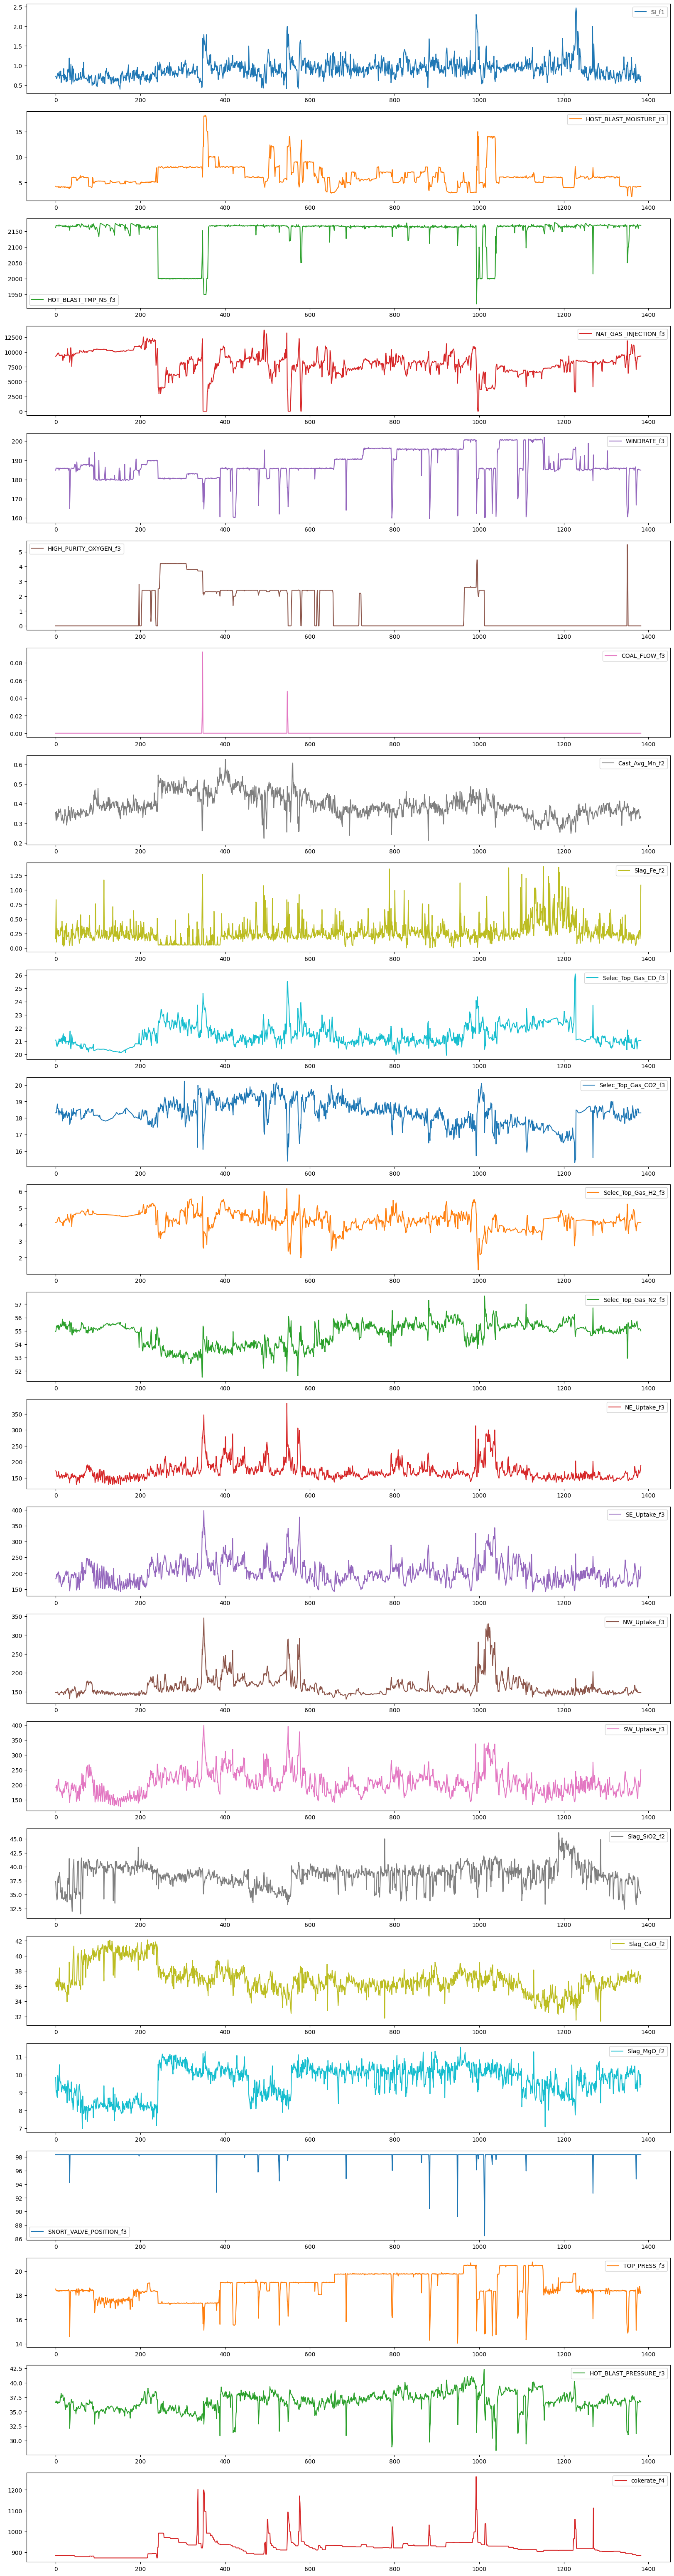

In [30]:

for_RNN_data_CIVS.plot( kind='line', subplots=True, figsize=(20,80),
        sharex=False, sharey=False, legend=True )


In [31]:

print(for_RNN_data_CIVS.shape)


(1383, 24)



## Parameters


In [32]:

pd.options.display.max_columns = None



## Standardize (Scaling)


In [33]:

def standardize_x_scales( data_gpt_pd ):


    data_gpt = torch.tensor(data_gpt_pd.values).float()
        
    epsilon = 0.0001

    print( data_gpt.shape)        
    
    x_means      = data_gpt .mean(0,  keepdim=True)
    x_deviations = data_gpt .std( 0,  keepdim=True) + epsilon

    ## x_train_tr_scaled = (x_train_tr - x_means) / x_deviations
    ## y_test_tr_scaled  = (y_test_tr  - y_means) / y_deviations
    
    return data_gpt, x_means, x_deviations


In [34]:

## x_means      = simple_x_train.mean(0, keepdim=True ) 
## x_deviations = simple_x_train.std( 0, keepdim=True) + epsilon



## Shift and create batches


In [35]:

def get_batch( data_gpt ):
    
    ix = torch.randint(   len(data_gpt) - block_size, (batch_size,)   )

    x  = torch.stack(    [  data_gpt[   i   : i+block_size    ]   for i in ix ]    ) 
    y  = torch.stack(    [  data_gpt[   i+1 : i+1+block_size  ]   for i in ix ]    )
    
    x, y = x.to(device), y.to(device)

    return x, y


In [36]:

'''

train_CIVS_tr, x_means, x_standard_devs = standardize_x_scales( train_CIVS )

train_CIVS_tr_scaled = ( train_CIVS_tr - x_means ) / x_standard_devs

bt_train_x, bt_train_y = get_batch( train_CIVS_tr_scaled )

bt_train_x.shape

bt_train_y.shape

x_means

'''


'\n\ntrain_CIVS_tr, x_means, x_standard_devs = standardize_x_scales( train_CIVS )\n\ntrain_CIVS_tr_scaled = ( train_CIVS_tr - x_means ) / x_standard_devs\n\nbt_train_x, bt_train_y = get_batch( train_CIVS_tr_scaled )\n\nbt_train_x.shape\n\nbt_train_y.shape\n\nx_means\n\n'


## Estimate loss - No Training


In [37]:

@torch.no_grad()    ## for efficient processing
def estimate_loss( model, criterion ):
    
    out = {}
    model.eval()   ## set to no training
    
    for split in ['train', 'test']:
        losses = torch.zeros(eval_iters)
        for k in range( eval_iters ):
            X, Y = get_batch( split )
            logits  = model(X, Y)
            B, T, E  = logits.shape
            pred     = logits.view( B*T, E)
            y_train  = Y.view(B*T, E)
            loss =  criterion( pred, y_train )
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()  ## back to training

    return out



## NN Architectures


In [38]:

class Head(nn.Module):

    def __init__(self, head_size):
        super().__init__()
        
        self.key   = nn.Linear(n_embd, head_size, bias=False)  ## [512, 64]
        self.query = nn.Linear(n_embd, head_size, bias=False)  ## [512, 64]
        self.value = nn.Linear(n_embd, head_size, bias=False)  ## [512, 64]

        tril_def = torch.tril( torch.ones(block_size, block_size) )  ## [40, 40]
        
        self.register_buffer(
                  'tril', 
                  tril_def
               )
        
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        
        B, T, E = x.shape   ## [batch_size, 40, 512] or [B, 15, 512]
        
        k = self.key(   x )            ## k = (B, T, 64)
        q = self.query( x )            ## q = (B, T, 64)

        E2 = 64     ## I think this is 64 and not 512
        ## (B, T, E) @ (B, E, T)  -> (B, T, T)
        wei = q @ k.transpose(-2, -1) * E2 ** -0.5        
        
        wei = wei.masked_fill(
                      self.tril[:T, :T] == 0, 
                      float('-inf')
        )   
        
        ## (B, T, T)
        wei = F.softmax( wei, dim= -1 )         ## (B, T, T)
        wei = self.dropout(   wei   )
        
        v   = self.value(  x  )   ## x = (B, 40, E)
        out = wei @ v             ## (B, T, T) @ (B, T, 64) -> (B, T, 64)
        
        return out
        


In [39]:

class FeedForward(nn.Module):

    def __init__(self, n_embd):         ## 512
        
        super().__init__()
        
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),      ## [512, 4*512]
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),      ## [4*512, 512]
            nn.Dropout(dropout),
        )
        
    def forward(self, x):
        return self.net(x)


In [40]:

class MultiHeadAttention(nn.Module):

    def __init__(self, num_heads, head_size):    ## (8, 64)
        super().__init__()
        self.heads = nn.ModuleList(  [ Head(head_size) for _ in range(num_heads) ] )
        self.proj  = nn.Linear(n_embd, n_embd)   ## 512, 512
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        out = torch.cat(   [ h(x) for h in self.heads ], dim = -1   )
        out = self.proj(  out   )
        out = self.dropout(   out   )
        return out


In [41]:

class Block(nn.Module):
    
    def __init__(self, n_embd, n_head):     ## (512, 8)
        super().__init__()
        head_size = n_embd // n_head        ## 64
        self.sa   = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward( n_embd)    ## 512
        self.ln1  = nn.LayerNorm(n_embd)
        self.ln2  = nn.LayerNorm(n_embd)
        
    def forward(self, x):
        x = x + self.sa(     self.ln1(x)      )
        x = x + self.ffwd(   self.ln2(x)      )
        return x


In [42]:

class moving_avg(nn.Module):

    def __init__(self, x):
        
        super().__init__()
        
        self.kernel_size = x.shape[2]
        self.stride      = 1
        self.avg = nn.AvgPool1d(kernel_size=self.kernel_size, stride=self.stride)

    def forward(self, x):
        

        x_avg = self.avg( x )         ## x.permute(0, 2, 1))
        
        ## x = x.permute(0, 2, 1)

        x = x + x_avg
        
        return x


In [43]:

m = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=5, padding=2, bias=False) 
  
input2 = torch.randn(8, 4, 25)

input_permute = rearrange(input2, 'b l m -> b m l')
print( input_permute.shape )
input2 = input2.unsqueeze(1)
input_permute = input_permute.unsqueeze(1)
output = m(input_permute)
output.shape


torch.Size([8, 25, 4])


torch.Size([8, 1, 25, 4])

In [44]:

inputs = torch.randn( 64, 1, 300 ) 

module = torch.nn.Conv1d(
    in_channels=1, out_channels=1, kernel_size=5, padding=2, bias=False
)

## module.weight.data = torch.full_like( module.weight.data, 0.2 )

out = module(inputs)
out.shape


torch.Size([64, 1, 300])

In [45]:

## a = torch.tensor( 42.6 )

## torch.round(a).int().item()


In [46]:

class Time_Series_GPT(nn.Module):
    
    def __init__(self, seq_length, input_size, output_size):
        
        super().__init__()
        
        self.output_size = output_size
        self.seq_length  = seq_length       ## 40 or 15
        self.input_size  = input_size

        vocab_size = 30
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)   ## [65, 512]
        
        self.pos_emb_table         = nn.Embedding(block_size, n_embd)     ## [block, 512] or [40, 512]
        
        self.blocks = nn.Sequential(
                *[   Block(n_embd, n_head=n_head) for _ in range(n_layer)    ]
        )
        
        self.ln_f        = nn.LayerNorm(  n_embd    )        
        self.lm_ffw_head = nn.Linear(n_embd, 25)  ## [512, 65] # FFW Layer

        #######################################################################

        self.map_24_512 = nn.Linear(25, 512)  ## [24, 512] # projection
        self.map_act    = nn.ReLU()

        #######################################################################

        self.map_24_512_1 = nn.Linear(25, 100)  ## [24, 512] # projection
        self.map_act1     = nn.ReLU()
        self.LayerNorm1   = nn.LayerNorm( 100 )
        self.map_24_512_2 = nn.Linear(100, 512)  ## [24, 512] # projection
        
   
        #####################################

        self.linear1_TS_int = nn.Linear(25, 15)
        self.act1_TS_int    = nn.ReLU()
        self.linear2_TS_int = nn.Linear(15, 9)
        self.act2_TS_int    = nn.ReLU()
        self.linear3_TS_int = nn.Linear(9, vocab_size)
        self.act3_TS_int    = nn.Softmax(dim=1)
        self.dropout_TS_int = nn.Dropout(0.25)
        
        #####################################

        self.conv_idx     = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=5, padding=2, bias=False) 
        self.bn1 = nn.BatchNorm2d(1)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv_idx2     = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=5, padding=2, bias=False) 
        self.bn2 = nn.BatchNorm2d(1)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv_idx3     = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=5, padding=2, bias=False) 

        
        self.per_conv_idx = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=5, padding=2, bias=False) 
        self.per_bn1 = nn.BatchNorm2d(3)
        self.per_relu1 = nn.ReLU(inplace=True)
        self.per_conv_idx2     = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, padding=2, bias=False) 
        self.per_bn2 = nn.BatchNorm2d(6)
        self.per_relu2 = nn.ReLU(inplace=True)
        self.per_conv_idx3     = nn.Conv2d(in_channels=6, out_channels=1, kernel_size=5, padding=2, bias=False) 
  
        #####################################
        

    def forward(self,  idx, targets):

        ## print( idx.shape      )
        ## print( targets.shape  )
        ######################

        ## obj_mov_avg = moving_avg(  idx  )
        ## res         = obj_mov_avg( idx )
        ## idx = res

        #####################

        B = idx.shape[0]       ## 8 batch 
        T = idx.shape[1]       ## 40 or 15

        ############################################################
        ## add this back - rc

        ## idx = self.map_24_512( idx )       ## (8, 15, 24) goes in
        ## idx = self.map_act(    idx )
        
        ## tok_emb = idx       ## (B, 15, 512)

        ###########################################################

        idx = self.map_24_512_1( idx )       ## (8, 15, 24) goes in
        idx = self.map_act1(     idx )
        idx = self.LayerNorm1(   idx )
        idx = self.map_24_512_2( idx ) 
        
        tok_emb = idx       ## (B, 15, 512)

        ###########################################################
        ## convolutions

        idx_4d_conv = idx.unsqueeze(1)
        residual = idx_4d_conv
        conv_emb = self.conv_idx( idx_4d_conv )
        conv_emb = self.bn1(conv_emb)
        conv_emb = self.relu1(conv_emb)
        conv_emb = self.conv_idx2( conv_emb )
        conv_emb = self.bn2(conv_emb)
        conv_emb = self.relu2(conv_emb)
        conv_emb = self.conv_idx3( conv_emb)
        conv_emb = residual + conv_emb
        conv_emb = conv_emb.squeeze(1)
        

        ## Permute
        idx_4d_conv_permute = rearrange(idx_4d_conv, 'b c l m -> b c m l')
        per_residual = idx_4d_conv_permute
        per_conv_emb = self.per_conv_idx( idx_4d_conv_permute )
        per_conv_emb = self.per_bn1(per_conv_emb)
        per_conv_emb = self.per_relu1(per_conv_emb)
        per_conv_emb = self.per_conv_idx2( per_conv_emb )
        per_conv_emb = self.per_bn2( per_conv_emb )
        per_conv_emb = self.per_relu2( per_conv_emb )
        per_conv_emb = self.per_conv_idx3( per_conv_emb )
        per_conv_emb = per_residual + per_conv_emb
        per_conv_emb = rearrange(per_conv_emb, 'b c m l -> b c l m')
        per_conv_emb = per_conv_emb.squeeze(1)

        ###########################################################
        
        pos_emb = self.pos_emb_table( torch.arange(T, device=device) )  
        
        ## pos_emb = PositionalEncoding(T, n_embd, normalize=True)   ## sines and cosines

        ###########################################################
        
        ## x = tok_emb + pos_emb + conv_emb + per_conv_emb    ## [B, T, E] or [N, 40, 512], now [N, 15, 24]

        x = tok_emb + pos_emb 

        ############################################################
        
        x = self.blocks(  x  )   ## (B, T, E)   
        x = self.ln_f(    x  )   ## (B, T, E)   ## norm
        logits = self.lm_ffw_head(x)         ## [B, 40, 65]  or [N, 15, 24]
        
        return logits
        
        
    def generate(self, idx, max_new_tokens):    ## idx is (B, T)
        print("max tokens ", max_new_tokens)
        print(idx.shape)
        for _ in range(max_new_tokens):
            ## crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:, :]
            logits = self(idx_cond, 0 )    ## ## get preds
            logits = logits[:, -1, :]    ## focus on last one (B, E)
            logits = logits.unsqueeze(0)
            ## probs = F.softmax(logits, dim= -1)    ## (B, E) get probs
            ## idx_next = torch.multinomial(probs, num_samples=1)     ## (B, 1) selected
            idx = torch.cat(  (idx, logits), dim=1  )   ## (B, T+1) append sample to running sequence
            
        return idx
            



## Train GPT function


In [47]:

mask = torch.arange(start=19, end=0, step=-1, device=device).tile(8, 1)
mask = mask**4
mask = mask.unsqueeze(2)

exp_rx = torch.ones(8, 19, 25)
print( exp_rx.shape )

print(mask.shape)
## print( mask )

res = exp_rx * mask
print( res.shape )
print( res[1, 0, :] )


torch.Size([8, 19, 25])
torch.Size([8, 19, 1])
torch.Size([8, 19, 25])
tensor([130321., 130321., 130321., 130321., 130321., 130321., 130321., 130321.,
        130321., 130321., 130321., 130321., 130321., 130321., 130321., 130321.,
        130321., 130321., 130321., 130321., 130321., 130321., 130321., 130321.,
        130321.])


In [48]:

def train_model_GPT( train_CIVS_2 ):
 
    
    model  = Time_Series_GPT(block_size, 25, 25)
    model  = model.to( device )
    
    optimizer       = torch.optim.Adam(     model.parameters(), lr=learning_rate   )

    criterion          = nn.MSELoss()
    ## criterion       = nn.L1Loss()
    ## criterion_kl    = nn.KLDivLoss(reduction="batchmean")
    
    history = {'loss': [], 'test_loss': []}
    
    train_CIVS_tr, x_means, x_standard_devs    = standardize_x_scales( train_CIVS_2 )

    train_CIVS_tr_scaled = ( train_CIVS_tr - x_means ) / x_standard_devs
        
    model.train()
    
    for batch_i, epoch in enumerate( range(max_iters) ):

        xb, yb    = get_batch( train_CIVS_tr_scaled )

        logits   = model( xb, yb )

        B, T, E  = logits.shape


        ###########################################
        pred           = logits.view( B, T, E )
        y_train        = yb.view(     B, T, E )
        
        ## size_rc = int( pred.shape[1]*0.6 )
        ## pred    =    pred[:, :size_rc, :]
        ## y_train = y_train[:, :size_rc, :]

        mask = torch.arange(start=T, end=0, step=-1, device=device).tile(B, 1)
        mask = mask**4
        mask = mask.unsqueeze(2)

        ## pred = pred * mask

        ##pred           = pred.reshape(        B*T, E )
        ##y_train        = y_train.reshape(     B*T, E )

        ## pred           = pred.reshape(        B*size_rc, E )
        ## y_train        = y_train.reshape(     B*size_rc, E )

        ####################################
        ##### rc add back
        
        ## pred           = logits.view( B*T, E )
        ## y_train        = yb.view(     B*T, E )

        
        #######################################################
        ## loss_cost = 0.0
        ## loss =  ( 1.0-loss_cost ) * criterion( pred, y_train ) + ( loss_cost ) * criterion( pred[:, 0], y_train[:, 0]  ) 

        #######################################################
        ## ind1 = random.randrange(0, y_train.shape[0] - 3)
        ## ind2 = ind1 + 3
        ## loss =  criterion( pred[ind1:ind2, 0], y_train[ind1:ind2, 0] )
        #######################################################

        ## loss = criterion( pred[:, 0], y_train[:, 0]  )
        #######################################################

        ## loss =  criterion( pred, y_train )      ## seems better

        ## pred[:,:size_rc, :].reshape(B*T, E ), y_train[:, :size_rc, :].reshape(B*T, E )

        ## print(  pred.shape[1]  )
        loss =    0.8*criterion( pred[:,  :6,  :].reshape(B*6, E ), y_train[:,   :6,  :].reshape(B*6, E ) ) \
                + 0.15*criterion( pred[:, 6:11, :].reshape(B*5, E ), y_train[:,  6:11, :].reshape(B*5, E ) ) \
                + 0.05*criterion( pred[:,11:,   :].reshape(B*4, E ), y_train[:, 11:,   :].reshape(B*4, E ) ) 
    
        #######################################################
        
        optimizer.zero_grad( set_to_none=True )          
        loss.backward()
        optimizer.step()

        history['loss'].append(  loss.item()  )

        if batch_i % 500 == 0:
            print(batch_i, "train loss = ", loss.item() )

    
    return model, history, x_means, x_standard_devs



## Parameters


In [49]:

torch.manual_seed(256)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

block_size        = 15   ##   40      ## N tokens in sequence
batch_size        = 16 
max_iters         = 3000   ## 5000
eval_interval     = 200     
learning_rate     = 0.0001
eval_iters        = 300
vocab_size        = 88  ## 65

## every id for a given token is embedded to vector of this size

n_embd            = 512       ## 24        ## 512       ## 24 for time series, silicon is 0           
n_head            = 8         ## 8 attention heads
n_layer           = 6         ## 6 eoncoder layers
dropout           = 0.2





## Utility Functions


In [50]:

def GPT_get_batch_test( test_data ):
    
    ## x_time_series = torch.tensor(test_data.values).float()       ## pandas to torch

    x_time_series = test_data

    x  = torch.stack(   [   x_time_series[ 0 : -1    ]    ]    ) 
    y  = torch.stack(   [   x_time_series[ 1 :       ]    ]    )
    
    x, y = x.to(device), y.to(device)

    return x, y


In [51]:

def RSE(pred, true):
    return np.sqrt(np.sum((true - pred) ** 2)) / np.sqrt(np.sum((true - true.mean()) ** 2))


def MAE(pred, true):
    return np.mean(np.abs(pred - true))


def MSE(pred, true):
    return np.mean((pred - true) ** 2)


def RMSE(pred, true):
    return np.sqrt(MSE(pred, true))


def MAPE(pred, true):
    return np.mean(np.abs((pred - true) / true))


def MSPE(pred, true):
    return np.mean(np.square((pred - true) / true))


def metric(pred, true):
    mae  = MAE( pred, true)
    mse  = MSE( pred, true)
    rmse = RMSE(pred, true)
    mape = MAPE(pred, true)
    mspe = MSPE(pred, true)
    rse  = RSE( pred, true)

    return mae, mse, rmse, mape, mspe, rse      


In [52]:

def GPT_generate_inference(model, x_test, which_feature, string_feature, train_CIVS_2_a ):

    xb_test, yb_test = GPT_get_batch_test( x_test )

    input_test_x = xb_test[ :,  : 5 ]         ## give first 4 in sequence for GPT to generate the rest
    
    pred_20_seq = model.generate( input_test_x, 14 )

    y_pred_gpt     = pred_20_seq.detach().cpu().numpy() 
    y_real_gpt     =     yb_test.detach().cpu().numpy() 
    
    find_index = index_to_slice + 395
    SI_data    = SI_lookup_for_RNN_data_CIVS.to_numpy()[ find_index:find_index+19, 0 ]  ## real SI data is here

    y_real_gpt = y_real_gpt.squeeze(0)
    y_pred_gpt = y_pred_gpt.squeeze(0)

    l_real = y_real_gpt[ :, 0 ]   
    l_pred = y_pred_gpt[ :, 0 ]

    l_SI_data_real = SI_data
    si_mean         = x_means[0, 0].numpy()
    si_standard_dev = x_standard_devs[0, 0].numpy()

    ##################################################

    l_real_all_24_features = y_real_gpt[ :, :]
    l_pred_all_24_features = y_pred_gpt[ :, :]
    si_mean_all_24_features         = x_means[0, :].numpy()
    si_standard_dev_all_24_features = x_standard_devs[0, :].numpy()
    l_pred_all_24_features        = l_pred_all_24_features   * si_standard_dev_all_24_features   + si_mean_all_24_features
    l_real_all_24_features        = l_real_all_24_features   * si_standard_dev_all_24_features   + si_mean_all_24_features

    ##################################################
    ## y_descaled = y_scaled * self.y_deviations + self.y_means
    
    l_pred        = l_pred   * si_standard_dev   + si_mean
    l_real        = l_real   * si_standard_dev   + si_mean

    eval_criterion = nn.MSELoss()

    mse_eval_bins = eval_criterion(
                          torch.FloatTensor( l_pred ), 
                          torch.FloatTensor( l_real )
    )

    mse_eval_bins0_5 = eval_criterion(
                          torch.FloatTensor( l_pred[0:4] ), 
                          torch.FloatTensor( l_real[0:4] )
    )

    mse_eval_bins5_10 = eval_criterion(
                          torch.FloatTensor( l_pred[4:10] ), 
                          torch.FloatTensor( l_real[4:10] )
    )

    mse_eval_bins10_15 = eval_criterion(
                          torch.FloatTensor( l_pred[10:19] ), 
                          torch.FloatTensor( l_real[10:19] )
    )

    ###################################################
    
    metric_mse_loss_SI_only                = mse_eval_bins.item()
    metric_mae_mse_rmse_mape_mspe_rse_corr = metric(    l_pred, l_real ) 
    metric_rsquare_SI_only                 = r2_score(  l_real, l_pred )
    metric_rsquare_all_features            = r2_score( 
                 np.reshape( l_real_all_24_features, (-1) ), 
                 np.reshape( l_pred_all_24_features, (-1) ) 
    ) 

    #####

    results_string = "mse_SI_only," + str(round( metric_mse_loss_SI_only, 4)) 
    results_string = results_string + "," + "rsquare_SI_only" + "," + str(round( metric_rsquare_SI_only, 4))
    results_string = results_string + "," + "rsquare_all_features" + "," + str(round( metric_rsquare_all_features, 4))
    several_metrics = str( metric_mae_mse_rmse_mape_mspe_rse_corr ).replace("(", "").replace(")","")
    results_string = results_string + "," + "mae_mse_rmse_mape_mspe_rse"  + "," + several_metrics
    
    ###################################################

    print( string_feature )
    print("Test MSE Loss - SI only: ",        mse_eval_bins.item()         )     ## :.4f }')
    print("Test MSE Loss - SI only 0-5: ",    mse_eval_bins0_5.item()      )     ## :.4f }')
    print("Test MSE Loss - SI only 5-10: ",   mse_eval_bins5_10.item()     )     ## :.4f }')
    print("Test MSE Loss - SI only 10-15: ",  mse_eval_bins10_15.item()    )     ## :.4f }')
    print("mae, mse, rmse, mape, mspe, rse, corr")
    print(    metric_mae_mse_rmse_mape_mspe_rse_corr    )
    print( "Testing R**2 - SI only: ", metric_rsquare_SI_only  )
    print( "Testing R**2 - SI only: ", 
            r2_score(  
                 np.reshape( l_real, (-1) ), 
                 np.reshape( l_pred, (-1) )      
            )  
    )
    
    print( "Testing R**2 - All features: ", metric_rsquare_all_features )

    #######################################

    x = [ i for i in range(len(l_real)) ] 

    l_SI_data_pred = []
    ## www3 = SI_data = SI_lookup_for_RNN_data_CIVS.to_numpy()[find_index - 1, 0]
    www3 = SI_lookup_for_RNN_data_CIVS.to_numpy()[find_index - 1, 0]
    the_curr_val = www3            ##l_SI_data_real[0]  ### www3
    for i in range( len(l_pred) ):
        the_curr_val = the_curr_val + l_pred[i]
        l_SI_data_pred.append( the_curr_val )

    ########################################

    yellow_l_SI_data_pred = []
    for i in range( len(l_pred) ):
        ww4 = SI_lookup_for_RNN_data_CIVS.to_numpy()[find_index - 1 + i, 0]
        the_curr_val = ww4 + l_pred[i]
        yellow_l_SI_data_pred.append( the_curr_val )

    ########################################
    ## Plots

    plt.scatter(x, l_real, label = "real", color='red') 
    plt.plot(   x, l_real, label = "real", color='red') 
    plt.plot(   x, l_SI_data_real, label = "real", color='red') 
    
    l_pred = np.roll(l_pred, -1)
    
    plt.scatter(x, l_pred, label = "pred", color='blue') 
    plt.plot(   x, l_pred, label = "pred", color='blue') 
    plt.plot(   x, l_SI_data_pred, label = "pred", color='blue') 
    plt.plot(   x, yellow_l_SI_data_pred, label = "pred1c", color='green')   ## yellow
    
    plt.legend() 
    plt.show()

    ##########################################

    train_plot = torch.tensor(train_CIVS_2_a.values).float().numpy()
    train_real_plot = train_plot[:, 0]
    l_real  = np.concatenate( ( train_real_plot, l_real ) )
    l_pred  = np.concatenate( ( train_real_plot, l_pred ) )
    
    ##########################################

    x = [ i for i in range(len(l_real)) ] 

    x_delta = [ i for i in range(len(l_SI_data_real)) ] 

    fig, ax = plt.subplots(2, 1) 
    ax[0].set_title(f'GPT Generate')
    ##ax[0].plot(history_GPT['loss'],     'k--',   label='loss'      )
    ##ax[0].plot(history_GPT['test_loss'], 'k',    label='test_loss'  )
    ax[0].scatter(x, l_real, label = "real", color='red') 
    ax[0].plot(   x, l_real, label = "real", color='red') 
    ax[0].scatter(x, l_pred, label = "pred", color='blue') 
    ax[0].plot(   x, l_pred, label = "pred", color='blue') 
    ax[0].legend()

    ###########################################
    
    ax[1].set_title(f"GPT")
    ax[1].scatter(x_delta, l_SI_data_real, label = "real", color='red') 
    ax[1].plot(   x_delta, l_SI_data_real, label = "real", color='red') 
    ax[1].scatter(x_delta, l_SI_data_pred, label = "pred", color='blue') 
    ax[1].plot(   x_delta, l_SI_data_pred, label = "pred", color='blue') 
    ax[1].plot(   x_delta, yellow_l_SI_data_pred, label = "pred1c", color='green')   ## yellow  ## ?? rc
    fig.tight_layout()
    ax[1].legend(); plt.show()

    return results_string 


In [53]:

def function_train_rc(  train_data  ):
    
    train_CIVS_2 = train_data
    si_GPT, history_GPT, x_means, x_standard_devs = train_model_GPT( train_CIVS_2 )

    fig, ax = plt.subplots(2, 1) 
    ax[0].set_title(f'GPT  Train  Loss  per epoch')
    ax[0].plot(history_GPT['loss'],     'k--',   label='loss'      )
    ax[0].plot(history_GPT['test_loss'], 'k',    label='test_loss'  )
    ax[0].legend()
    ax[1].set_title(f"GPT")

    fig.tight_layout()
    ax[1].legend(); plt.show()

    return si_GPT, history_GPT, x_means, x_standard_devs 

    

In [54]:

def function_test_rc( train_data, test_CIVS, si_GPT, x_means, x_standard_devs):
    
    train_CIVS_2 = train_data
    
    print(  test_CIVS.shape )
    print( train_data.shape )
    ## print( train_data[ -5: ] )

    frames           = [ train_data[ -5: ], test_CIVS ]
    test_CIVS_concat = pd.concat( frames )
    print( test_CIVS_concat.shape )

    test_CIVS_tr = torch.tensor(test_CIVS_concat.values).float()
    test_CIVS_tr_scaled = ( test_CIVS_tr - x_means ) / x_standard_devs
    print(  test_CIVS_tr_scaled.shape )

    batch_x_test = test_CIVS_tr_scaled
    print( batch_x_test.shape )
    results_string = GPT_generate_inference(   si_GPT,  batch_x_test, 0 , "SI", train_CIVS_2 )
    return results_string


In [55]:

'''
SI_data = SI_lookup_for_RNN_data_CIVS.to_numpy()[1040:1054, 0]
print(SI_data.shape)
SI_data
'''


'\nSI_data = SI_lookup_for_RNN_data_CIVS.to_numpy()[1040:1054, 0]\nprint(SI_data.shape)\nSI_data\n'


## The Data


In [56]:

for_RNN_data_CIVS


SI_f1  HOST_BLAST_MOISTURE_f3  HOT_BLAST_TMP_NS_f3  \
0     0.719500                4.242439          2161.425209   
1     0.710486                4.174343          2168.238915   
2     0.666106                4.126144          2167.779119   
3     0.675145                4.120736          2166.974740   
4     0.776831                4.120331          2166.384674   
...        ...                     ...                  ...   
1378  0.762500                4.204430          2169.361647   
1379  0.646000                4.208539          2169.079601   
1380  0.654667                4.212648          2168.797556   
1381  0.591667                4.217784          2168.444999   
1382  0.724667                4.223948          2167.967389   

      NAT_GAS _INJECTION_f3  WINDRATE_f3  HIGH_PURITY_OXYGEN_f3  COAL_FLOW_f3  \
0               9306.840913   184.818611                    0.0           0.0   
1               9336.364456   185.993447                    0.0           0.0   
2               9419.200115   185.828474                    0.0           0.0   
3               9564.165802   185.924481                    0.0           0.0   
4               9648.247637   185.942943                    0.0           0.0   
...                     ...          ...                    ...           ...   
1378            9297.484543   185.046491                    0.0           0.0   
1379            9312.779010   185.053796                    0.0           0.0   
1380            9303.753420   185.007919                    0.0           0.0   
1381            9333.448101   184.942435                    0.0           0.0   
1382            9321.819731   184.863855                    0.0           0.0   

      Cast_Avg_Mn_f2  Slag_Fe_f2  Selec_Top_Gas_CO_f3  Selec_Top_Gas_CO2_f3  \
0              0.354        0.16            21.080431             18.313322   
1              0.313        0.83            20.996415             18.311768   
2              0.360        0.10            20.749627             18.341701   
3              0.319        0.34            20.609259             18.644476   
4              0.335        0.28            20.617383             18.845791   
...              ...         ...                  ...                   ...   
1378           0.343        0.30            21.039583             18.308225   
1379           0.324        0.30            21.043999             18.308776   
1380           0.325        0.16            21.048415             18.309327   
1381           0.335        0.26            21.053935             18.310016   
1382           0.328        1.08            21.060559             18.310842   

      Selec_Top_Gas_H2_f3  Selec_Top_Gas_N2_f3  NE_Uptake_f3  SE_Uptake_f3  \
0                4.131228            54.940123    171.769513    182.533770   
1                4.133911            55.072779    170.595469    183.725050   
2                4.137632            55.375043    167.017421    195.812061   
3                4.142824            55.341884    154.214917    188.028883   
4                4.220690            55.284451    156.234542    200.141261   
...                   ...                  ...           ...           ...   
1378             4.129485            55.162782    167.619915    185.900341   
1379             4.129674            55.162767    164.706552    182.408576   
1380             4.129862            55.140373    166.903493    181.684649   
1381             4.130097            55.098014    175.524144    195.202191   
1382             4.130380            55.003376    189.407795    220.149599   

      NW_Uptake_f3  SW_Uptake_f3  Slag_SiO2_f2  Slag_CaO_f2  Slag_MgO_f2  \
0       148.126483    192.512412     37.369999    36.439999         9.86   
1       148.161842    192.366046     35.540001    35.970001         9.03   
2       147.562523    198.423474     34.849998    36.590000         9.13   
3       147.807509    179.116839     34.009998    35.900002         8.82   
4       149.0


## Delta of SI


In [57]:

delta_for_RNN_data_CIVS      = for_RNN_data_CIVS.copy()
SI_lookup_for_RNN_data_CIVS  = for_RNN_data_CIVS.copy()


In [58]:

delta_for_RNN_data_CIVS 


SI_f1  HOST_BLAST_MOISTURE_f3  HOT_BLAST_TMP_NS_f3  \
0     0.719500                4.242439          2161.425209   
1     0.710486                4.174343          2168.238915   
2     0.666106                4.126144          2167.779119   
3     0.675145                4.120736          2166.974740   
4     0.776831                4.120331          2166.384674   
...        ...                     ...                  ...   
1378  0.762500                4.204430          2169.361647   
1379  0.646000                4.208539          2169.079601   
1380  0.654667                4.212648          2168.797556   
1381  0.591667                4.217784          2168.444999   
1382  0.724667                4.223948          2167.967389   

      NAT_GAS _INJECTION_f3  WINDRATE_f3  HIGH_PURITY_OXYGEN_f3  COAL_FLOW_f3  \
0               9306.840913   184.818611                    0.0           0.0   
1               9336.364456   185.993447                    0.0           0.0   
2               9419.200115   185.828474                    0.0           0.0   
3               9564.165802   185.924481                    0.0           0.0   
4               9648.247637   185.942943                    0.0           0.0   
...                     ...          ...                    ...           ...   
1378            9297.484543   185.046491                    0.0           0.0   
1379            9312.779010   185.053796                    0.0           0.0   
1380            9303.753420   185.007919                    0.0           0.0   
1381            9333.448101   184.942435                    0.0           0.0   
1382            9321.819731   184.863855                    0.0           0.0   

      Cast_Avg_Mn_f2  Slag_Fe_f2  Selec_Top_Gas_CO_f3  Selec_Top_Gas_CO2_f3  \
0              0.354        0.16            21.080431             18.313322   
1              0.313        0.83            20.996415             18.311768   
2              0.360        0.10            20.749627             18.341701   
3              0.319        0.34            20.609259             18.644476   
4              0.335        0.28            20.617383             18.845791   
...              ...         ...                  ...                   ...   
1378           0.343        0.30            21.039583             18.308225   
1379           0.324        0.30            21.043999             18.308776   
1380           0.325        0.16            21.048415             18.309327   
1381           0.335        0.26            21.053935             18.310016   
1382           0.328        1.08            21.060559             18.310842   

      Selec_Top_Gas_H2_f3  Selec_Top_Gas_N2_f3  NE_Uptake_f3  SE_Uptake_f3  \
0                4.131228            54.940123    171.769513    182.533770   
1                4.133911            55.072779    170.595469    183.725050   
2                4.137632            55.375043    167.017421    195.812061   
3                4.142824            55.341884    154.214917    188.028883   
4                4.220690            55.284451    156.234542    200.141261   
...                   ...                  ...           ...           ...   
1378             4.129485            55.162782    167.619915    185.900341   
1379             4.129674            55.162767    164.706552    182.408576   
1380             4.129862            55.140373    166.903493    181.684649   
1381             4.130097            55.098014    175.524144    195.202191   
1382             4.130380            55.003376    189.407795    220.149599   

      NW_Uptake_f3  SW_Uptake_f3  Slag_SiO2_f2  Slag_CaO_f2  Slag_MgO_f2  \
0       148.126483    192.512412     37.369999    36.439999         9.86   
1       148.161842    192.366046     35.540001    35.970001         9.03   
2       147.562523    198.423474     34.849998    36.590000         9.13   
3       147.807509    179.116839     34.009998    35.900002         8.82   
4       149.0

In [59]:

delta_for_RNN_data_CIVS.insert(loc = 0,
                                column = 'delta_SI',
                                value = 0 )



In [60]:

for_RNN_data_CIVS


SI_f1  HOST_BLAST_MOISTURE_f3  HOT_BLAST_TMP_NS_f3  \
0     0.719500                4.242439          2161.425209   
1     0.710486                4.174343          2168.238915   
2     0.666106                4.126144          2167.779119   
3     0.675145                4.120736          2166.974740   
4     0.776831                4.120331          2166.384674   
...        ...                     ...                  ...   
1378  0.762500                4.204430          2169.361647   
1379  0.646000                4.208539          2169.079601   
1380  0.654667                4.212648          2168.797556   
1381  0.591667                4.217784          2168.444999   
1382  0.724667                4.223948          2167.967389   

      NAT_GAS _INJECTION_f3  WINDRATE_f3  HIGH_PURITY_OXYGEN_f3  COAL_FLOW_f3  \
0               9306.840913   184.818611                    0.0           0.0   
1               9336.364456   185.993447                    0.0           0.0   
2               9419.200115   185.828474                    0.0           0.0   
3               9564.165802   185.924481                    0.0           0.0   
4               9648.247637   185.942943                    0.0           0.0   
...                     ...          ...                    ...           ...   
1378            9297.484543   185.046491                    0.0           0.0   
1379            9312.779010   185.053796                    0.0           0.0   
1380            9303.753420   185.007919                    0.0           0.0   
1381            9333.448101   184.942435                    0.0           0.0   
1382            9321.819731   184.863855                    0.0           0.0   

      Cast_Avg_Mn_f2  Slag_Fe_f2  Selec_Top_Gas_CO_f3  Selec_Top_Gas_CO2_f3  \
0              0.354        0.16            21.080431             18.313322   
1              0.313        0.83            20.996415             18.311768   
2              0.360        0.10            20.749627             18.341701   
3              0.319        0.34            20.609259             18.644476   
4              0.335        0.28            20.617383             18.845791   
...              ...         ...                  ...                   ...   
1378           0.343        0.30            21.039583             18.308225   
1379           0.324        0.30            21.043999             18.308776   
1380           0.325        0.16            21.048415             18.309327   
1381           0.335        0.26            21.053935             18.310016   
1382           0.328        1.08            21.060559             18.310842   

      Selec_Top_Gas_H2_f3  Selec_Top_Gas_N2_f3  NE_Uptake_f3  SE_Uptake_f3  \
0                4.131228            54.940123    171.769513    182.533770   
1                4.133911            55.072779    170.595469    183.725050   
2                4.137632            55.375043    167.017421    195.812061   
3                4.142824            55.341884    154.214917    188.028883   
4                4.220690            55.284451    156.234542    200.141261   
...                   ...                  ...           ...           ...   
1378             4.129485            55.162782    167.619915    185.900341   
1379             4.129674            55.162767    164.706552    182.408576   
1380             4.129862            55.140373    166.903493    181.684649   
1381             4.130097            55.098014    175.524144    195.202191   
1382             4.130380            55.003376    189.407795    220.149599   

      NW_Uptake_f3  SW_Uptake_f3  Slag_SiO2_f2  Slag_CaO_f2  Slag_MgO_f2  \
0       148.126483    192.512412     37.369999    36.439999         9.86   
1       148.161842    192.366046     35.540001    35.970001         9.03   
2       147.562523    198.423474     34.849998    36.590000         9.13   
3       147.807509    179.116839     34.009998    35.900002         8.82   
4       149.0

In [61]:

delta_for_RNN_data_CIVS


delta_SI     SI_f1  HOST_BLAST_MOISTURE_f3  HOT_BLAST_TMP_NS_f3  \
0            0  0.719500                4.242439          2161.425209   
1            0  0.710486                4.174343          2168.238915   
2            0  0.666106                4.126144          2167.779119   
3            0  0.675145                4.120736          2166.974740   
4            0  0.776831                4.120331          2166.384674   
...        ...       ...                     ...                  ...   
1378         0  0.762500                4.204430          2169.361647   
1379         0  0.646000                4.208539          2169.079601   
1380         0  0.654667                4.212648          2168.797556   
1381         0  0.591667                4.217784          2168.444999   
1382         0  0.724667                4.223948          2167.967389   

      NAT_GAS _INJECTION_f3  WINDRATE_f3  HIGH_PURITY_OXYGEN_f3  COAL_FLOW_f3  \
0               9306.840913   184.818611                    0.0           0.0   
1               9336.364456   185.993447                    0.0           0.0   
2               9419.200115   185.828474                    0.0           0.0   
3               9564.165802   185.924481                    0.0           0.0   
4               9648.247637   185.942943                    0.0           0.0   
...                     ...          ...                    ...           ...   
1378            9297.484543   185.046491                    0.0           0.0   
1379            9312.779010   185.053796                    0.0           0.0   
1380            9303.753420   185.007919                    0.0           0.0   
1381            9333.448101   184.942435                    0.0           0.0   
1382            9321.819731   184.863855                    0.0           0.0   

      Cast_Avg_Mn_f2  Slag_Fe_f2  Selec_Top_Gas_CO_f3  Selec_Top_Gas_CO2_f3  \
0              0.354        0.16            21.080431             18.313322   
1              0.313        0.83            20.996415             18.311768   
2              0.360        0.10            20.749627             18.341701   
3              0.319        0.34            20.609259             18.644476   
4              0.335        0.28            20.617383             18.845791   
...              ...         ...                  ...                   ...   
1378           0.343        0.30            21.039583             18.308225   
1379           0.324        0.30            21.043999             18.308776   
1380           0.325        0.16            21.048415             18.309327   
1381           0.335        0.26            21.053935             18.310016   
1382           0.328        1.08            21.060559             18.310842   

      Selec_Top_Gas_H2_f3  Selec_Top_Gas_N2_f3  NE_Uptake_f3  SE_Uptake_f3  \
0                4.131228            54.940123    171.769513    182.533770   
1                4.133911            55.072779    170.595469    183.725050   
2                4.137632            55.375043    167.017421    195.812061   
3                4.142824            55.341884    154.214917    188.028883   
4                4.220690            55.284451    156.234542    200.141261   
...                   ...                  ...           ...           ...   
1378             4.129485            55.162782    167.619915    185.900341   
1379             4.129674            55.162767    164.706552    182.408576   
1380             4.129862            55.140373    166.903493    181.684649   
1381             4.130097            55.098014    175.524144    195.202191   
1382             4.130380            55.003376    189.407795    220.149599   

      NW_Uptake_f3  SW_Uptake_f3  Slag_SiO2_f2  Slag_CaO_f2  Slag_MgO_f2  \
0       148.126483    192.512412     37.369999    36.439999         9.86   
1       148.161842    192.366046     35.540001    35.970001         9.03   
2       147.562523    198.423474     34.84

In [62]:

## merge_date_key = ''
## i_6000 = 0
## merge_date_key = list_dates_6000f[ i_6000 ]


    
for index, row in delta_for_RNN_data_CIVS.iterrows():

    if index > 1:
        ## if row["MM_Timestamp_f1"] <= merge_date_key and row['Timestamp_f1'] == 'abc':
        delta_for_RNN_data_CIVS.at[index,'delta_SI']= delta_for_RNN_data_CIVS.at[index,'SI_f1'] - delta_for_RNN_data_CIVS.at[index-1,'SI_f1'] 
        ## print(delta_for_RNN_data_CIVS.at[index,'SI_f1'])

        
## merge_date_key = list_dates_6000f[ i_6000 ] 
## MinByMin_137MB_data_CIVS.at[index, 'Timestamp_f1'] = merge_date_key
        
## if index  % 50000 == 0:
## print(index )
 


In [63]:

delta_for_RNN_data_CIVS


delta_SI     SI_f1  HOST_BLAST_MOISTURE_f3  HOT_BLAST_TMP_NS_f3  \
0     0.000000  0.719500                4.242439          2161.425209   
1     0.000000  0.710486                4.174343          2168.238915   
2    -0.044380  0.666106                4.126144          2167.779119   
3     0.009040  0.675145                4.120736          2166.974740   
4     0.101686  0.776831                4.120331          2166.384674   
...        ...       ...                     ...                  ...   
1378  0.109500  0.762500                4.204430          2169.361647   
1379 -0.116500  0.646000                4.208539          2169.079601   
1380  0.008667  0.654667                4.212648          2168.797556   
1381 -0.063000  0.591667                4.217784          2168.444999   
1382  0.133000  0.724667                4.223948          2167.967389   

      NAT_GAS _INJECTION_f3  WINDRATE_f3  HIGH_PURITY_OXYGEN_f3  COAL_FLOW_f3  \
0               9306.840913   184.818611                    0.0           0.0   
1               9336.364456   185.993447                    0.0           0.0   
2               9419.200115   185.828474                    0.0           0.0   
3               9564.165802   185.924481                    0.0           0.0   
4               9648.247637   185.942943                    0.0           0.0   
...                     ...          ...                    ...           ...   
1378            9297.484543   185.046491                    0.0           0.0   
1379            9312.779010   185.053796                    0.0           0.0   
1380            9303.753420   185.007919                    0.0           0.0   
1381            9333.448101   184.942435                    0.0           0.0   
1382            9321.819731   184.863855                    0.0           0.0   

      Cast_Avg_Mn_f2  Slag_Fe_f2  Selec_Top_Gas_CO_f3  Selec_Top_Gas_CO2_f3  \
0              0.354        0.16            21.080431             18.313322   
1              0.313        0.83            20.996415             18.311768   
2              0.360        0.10            20.749627             18.341701   
3              0.319        0.34            20.609259             18.644476   
4              0.335        0.28            20.617383             18.845791   
...              ...         ...                  ...                   ...   
1378           0.343        0.30            21.039583             18.308225   
1379           0.324        0.30            21.043999             18.308776   
1380           0.325        0.16            21.048415             18.309327   
1381           0.335        0.26            21.053935             18.310016   
1382           0.328        1.08            21.060559             18.310842   

      Selec_Top_Gas_H2_f3  Selec_Top_Gas_N2_f3  NE_Uptake_f3  SE_Uptake_f3  \
0                4.131228            54.940123    171.769513    182.533770   
1                4.133911            55.072779    170.595469    183.725050   
2                4.137632            55.375043    167.017421    195.812061   
3                4.142824            55.341884    154.214917    188.028883   
4                4.220690            55.284451    156.234542    200.141261   
...                   ...                  ...           ...           ...   
1378             4.129485            55.162782    167.619915    185.900341   
1379             4.129674            55.162767    164.706552    182.408576   
1380             4.129862            55.140373    166.903493    181.684649   
1381             4.130097            55.098014    175.524144    195.202191   
1382             4.130380            55.003376    189.407795    220.149599   

      NW_Uptake_f3  SW_Uptake_f3  Slag_SiO2_f2  Slag_CaO_f2  Slag_MgO_f2  \
0       148.126483    192.512412     37.369999    36.439999         9.86   
1       148.161842    192.366046     35.540001    35.970001         9.03   
2       147.562523    198.423474     34.84

In [64]:

l_delta = ['delta_SI',
 'HOST_BLAST_MOISTURE_f3',
 'HOT_BLAST_TMP_NS_f3',
 'NAT_GAS _INJECTION_f3',
 'WINDRATE_f3',
 'HIGH_PURITY_OXYGEN_f3',
 'COAL_FLOW_f3',
 'Cast_Avg_Mn_f2',
 'Slag_Fe_f2',
 'Selec_Top_Gas_CO_f3',
 'Selec_Top_Gas_CO2_f3',
 'Selec_Top_Gas_H2_f3',
 'Selec_Top_Gas_N2_f3',
 'NE_Uptake_f3',
 'SE_Uptake_f3',
 'NW_Uptake_f3',
 'SW_Uptake_f3',
 'Slag_SiO2_f2',
 'Slag_CaO_f2',
 'Slag_MgO_f2',
 'SNORT_VALVE_POSITION_f3',
 'TOP_PRESS_f3',
 'HOT_BLAST_PRESSURE_f3',
 'cokerate_f4']


In [65]:

delta_for_RNN_data_CIVS = delta_for_RNN_data_CIVS[ l_delta]


In [66]:

delta_for_RNN_data_CIVS


delta_SI  HOST_BLAST_MOISTURE_f3  HOT_BLAST_TMP_NS_f3  \
0     0.000000                4.242439          2161.425209   
1     0.000000                4.174343          2168.238915   
2    -0.044380                4.126144          2167.779119   
3     0.009040                4.120736          2166.974740   
4     0.101686                4.120331          2166.384674   
...        ...                     ...                  ...   
1378  0.109500                4.204430          2169.361647   
1379 -0.116500                4.208539          2169.079601   
1380  0.008667                4.212648          2168.797556   
1381 -0.063000                4.217784          2168.444999   
1382  0.133000                4.223948          2167.967389   

      NAT_GAS _INJECTION_f3  WINDRATE_f3  HIGH_PURITY_OXYGEN_f3  COAL_FLOW_f3  \
0               9306.840913   184.818611                    0.0           0.0   
1               9336.364456   185.993447                    0.0           0.0   
2               9419.200115   185.828474                    0.0           0.0   
3               9564.165802   185.924481                    0.0           0.0   
4               9648.247637   185.942943                    0.0           0.0   
...                     ...          ...                    ...           ...   
1378            9297.484543   185.046491                    0.0           0.0   
1379            9312.779010   185.053796                    0.0           0.0   
1380            9303.753420   185.007919                    0.0           0.0   
1381            9333.448101   184.942435                    0.0           0.0   
1382            9321.819731   184.863855                    0.0           0.0   

      Cast_Avg_Mn_f2  Slag_Fe_f2  Selec_Top_Gas_CO_f3  Selec_Top_Gas_CO2_f3  \
0              0.354        0.16            21.080431             18.313322   
1              0.313        0.83            20.996415             18.311768   
2              0.360        0.10            20.749627             18.341701   
3              0.319        0.34            20.609259             18.644476   
4              0.335        0.28            20.617383             18.845791   
...              ...         ...                  ...                   ...   
1378           0.343        0.30            21.039583             18.308225   
1379           0.324        0.30            21.043999             18.308776   
1380           0.325        0.16            21.048415             18.309327   
1381           0.335        0.26            21.053935             18.310016   
1382           0.328        1.08            21.060559             18.310842   

      Selec_Top_Gas_H2_f3  Selec_Top_Gas_N2_f3  NE_Uptake_f3  SE_Uptake_f3  \
0                4.131228            54.940123    171.769513    182.533770   
1                4.133911            55.072779    170.595469    183.725050   
2                4.137632            55.375043    167.017421    195.812061   
3                4.142824            55.341884    154.214917    188.028883   
4                4.220690            55.284451    156.234542    200.141261   
...                   ...                  ...           ...           ...   
1378             4.129485            55.162782    167.619915    185.900341   
1379             4.129674            55.162767    164.706552    182.408576   
1380             4.129862            55.140373    166.903493    181.684649   
1381             4.130097            55.098014    175.524144    195.202191   
1382             4.130380            55.003376    189.407795    220.149599   

      NW_Uptake_f3  SW_Uptake_f3  Slag_SiO2_f2  Slag_CaO_f2  Slag_MgO_f2  \
0       148.126483    192.512412     37.369999    36.439999         9.86   
1       148.161842    192.366046     35.540001    35.970001         9.03   
2       147.562523    198.423474     34.849998    36.590000         9.13   
3       147.807509    179.116839     34.009998    35.900002         8.82   
4       14

In [67]:

for_RNN_data_CIVS = delta_for_RNN_data_CIVS



## Add Moving average to data


In [68]:


delta_for_RNN_data_CIVS.insert(loc = 1,
                                column = 'mov_avg_SI',
                                value = 0 )



In [69]:

delta_for_RNN_data_CIVS


delta_SI  mov_avg_SI  HOST_BLAST_MOISTURE_f3  HOT_BLAST_TMP_NS_f3  \
0     0.000000           0                4.242439          2161.425209   
1     0.000000           0                4.174343          2168.238915   
2    -0.044380           0                4.126144          2167.779119   
3     0.009040           0                4.120736          2166.974740   
4     0.101686           0                4.120331          2166.384674   
...        ...         ...                     ...                  ...   
1378  0.109500           0                4.204430          2169.361647   
1379 -0.116500           0                4.208539          2169.079601   
1380  0.008667           0                4.212648          2168.797556   
1381 -0.063000           0                4.217784          2168.444999   
1382  0.133000           0                4.223948          2167.967389   

      NAT_GAS _INJECTION_f3  WINDRATE_f3  HIGH_PURITY_OXYGEN_f3  COAL_FLOW_f3  \
0               9306.840913   184.818611                    0.0           0.0   
1               9336.364456   185.993447                    0.0           0.0   
2               9419.200115   185.828474                    0.0           0.0   
3               9564.165802   185.924481                    0.0           0.0   
4               9648.247637   185.942943                    0.0           0.0   
...                     ...          ...                    ...           ...   
1378            9297.484543   185.046491                    0.0           0.0   
1379            9312.779010   185.053796                    0.0           0.0   
1380            9303.753420   185.007919                    0.0           0.0   
1381            9333.448101   184.942435                    0.0           0.0   
1382            9321.819731   184.863855                    0.0           0.0   

      Cast_Avg_Mn_f2  Slag_Fe_f2  Selec_Top_Gas_CO_f3  Selec_Top_Gas_CO2_f3  \
0              0.354        0.16            21.080431             18.313322   
1              0.313        0.83            20.996415             18.311768   
2              0.360        0.10            20.749627             18.341701   
3              0.319        0.34            20.609259             18.644476   
4              0.335        0.28            20.617383             18.845791   
...              ...         ...                  ...                   ...   
1378           0.343        0.30            21.039583             18.308225   
1379           0.324        0.30            21.043999             18.308776   
1380           0.325        0.16            21.048415             18.309327   
1381           0.335        0.26            21.053935             18.310016   
1382           0.328        1.08            21.060559             18.310842   

      Selec_Top_Gas_H2_f3  Selec_Top_Gas_N2_f3  NE_Uptake_f3  SE_Uptake_f3  \
0                4.131228            54.940123    171.769513    182.533770   
1                4.133911            55.072779    170.595469    183.725050   
2                4.137632            55.375043    167.017421    195.812061   
3                4.142824            55.341884    154.214917    188.028883   
4                4.220690            55.284451    156.234542    200.141261   
...                   ...                  ...           ...           ...   
1378             4.129485            55.162782    167.619915    185.900341   
1379             4.129674            55.162767    164.706552    182.408576   
1380             4.129862            55.140373    166.903493    181.684649   
1381             4.130097            55.098014    175.524144    195.202191   
1382             4.130380            55.003376    189.407795    220.149599   

      NW_Uptake_f3  SW_Uptake_f3  Slag_SiO2_f2  Slag_CaO_f2  Slag_MgO_f2  \
0       148.126483    192.512412     37.369999    36.439999         9.86   
1       148.161842    192.366046     35.540001    35.970001         9.03   
2       147.562523

In [70]:

delta_for_RNN_data_CIVS.shape[0]


1383

In [71]:


## for index, row in delta_for_RNN_data_CIVS.iterrows():

range_to_mean = 10

for i in range( 1, delta_for_RNN_data_CIVS.shape[0] ):
    index = delta_for_RNN_data_CIVS.shape[0] - i
    if index <= 10:
        ## range_to_mean = index -1
        break
    list_to_mean = []
    for j in range( range_to_mean ):
        list_to_mean.append(   delta_for_RNN_data_CIVS.at[ index-j , 'delta_SI' ]    )
    the_mean = np.array( list_to_mean )
    delta_for_RNN_data_CIVS.at[index,'mov_avg_SI']= np.mean(the_mean) 



In [72]:

delta_for_RNN_data_CIVS


delta_SI  mov_avg_SI  HOST_BLAST_MOISTURE_f3  HOT_BLAST_TMP_NS_f3  \
0     0.000000    0.000000                4.242439          2161.425209   
1     0.000000    0.000000                4.174343          2168.238915   
2    -0.044380    0.000000                4.126144          2167.779119   
3     0.009040    0.000000                4.120736          2166.974740   
4     0.101686    0.000000                4.120331          2166.384674   
...        ...         ...                     ...                  ...   
1378  0.109500    0.004444                4.204430          2169.361647   
1379 -0.116500    0.008900                4.208539          2169.079601   
1380  0.008667   -0.037618                4.212648          2168.797556   
1381 -0.063000   -0.014340                4.217784          2168.444999   
1382  0.133000    0.011422                4.223948          2167.967389   

      NAT_GAS _INJECTION_f3  WINDRATE_f3  HIGH_PURITY_OXYGEN_f3  COAL_FLOW_f3  \
0               9306.840913   184.818611                    0.0           0.0   
1               9336.364456   185.993447                    0.0           0.0   
2               9419.200115   185.828474                    0.0           0.0   
3               9564.165802   185.924481                    0.0           0.0   
4               9648.247637   185.942943                    0.0           0.0   
...                     ...          ...                    ...           ...   
1378            9297.484543   185.046491                    0.0           0.0   
1379            9312.779010   185.053796                    0.0           0.0   
1380            9303.753420   185.007919                    0.0           0.0   
1381            9333.448101   184.942435                    0.0           0.0   
1382            9321.819731   184.863855                    0.0           0.0   

      Cast_Avg_Mn_f2  Slag_Fe_f2  Selec_Top_Gas_CO_f3  Selec_Top_Gas_CO2_f3  \
0              0.354        0.16            21.080431             18.313322   
1              0.313        0.83            20.996415             18.311768   
2              0.360        0.10            20.749627             18.341701   
3              0.319        0.34            20.609259             18.644476   
4              0.335        0.28            20.617383             18.845791   
...              ...         ...                  ...                   ...   
1378           0.343        0.30            21.039583             18.308225   
1379           0.324        0.30            21.043999             18.308776   
1380           0.325        0.16            21.048415             18.309327   
1381           0.335        0.26            21.053935             18.310016   
1382           0.328        1.08            21.060559             18.310842   

      Selec_Top_Gas_H2_f3  Selec_Top_Gas_N2_f3  NE_Uptake_f3  SE_Uptake_f3  \
0                4.131228            54.940123    171.769513    182.533770   
1                4.133911            55.072779    170.595469    183.725050   
2                4.137632            55.375043    167.017421    195.812061   
3                4.142824            55.341884    154.214917    188.028883   
4                4.220690            55.284451    156.234542    200.141261   
...                   ...                  ...           ...           ...   
1378             4.129485            55.162782    167.619915    185.900341   
1379             4.129674            55.162767    164.706552    182.408576   
1380             4.129862            55.140373    166.903493    181.684649   
1381             4.130097            55.098014    175.524144    195.202191   
1382             4.130380            55.003376    189.407795    220.149599   

      NW_Uptake_f3  SW_Uptake_f3  Slag_SiO2_f2  Slag_CaO_f2  Slag_MgO_f2  \
0       148.126483    192.512412     37.369999    36.439999         9.86   
1       148.161842    192.366046     35.540001    35.970001         9.03   
2       147.562523

In [73]:

for_RNN_data_CIVS = delta_for_RNN_data_CIVS



## Pick slice randomly


In [74]:

training_chunk = 400


In [75]:

length_n  = int( for_RNN_data_CIVS.shape[0] )

length_n


1383


## Run 1


In [76]:

the_range = training_chunk + block_size

random.seed()

index_to_slice = random.randrange(0, length_n - the_range)

index_to_slice


631

In [77]:

print( for_RNN_data_CIVS.shape[0] )
print( index_to_slice )
print( index_to_slice + the_range )


1383
631
1046


In [78]:

sliced_chunk_CIVS = for_RNN_data_CIVS[ index_to_slice : index_to_slice + the_range]


In [79]:

sliced_chunk_CIVS


delta_SI  mov_avg_SI  HOST_BLAST_MOISTURE_f3  HOT_BLAST_TMP_NS_f3  \
631   0.142195   -0.011906                5.928298          2165.990119   
632  -0.007909    0.015402                5.915734          2166.284459   
633  -0.260008   -0.037297                5.915972          2166.653095   
634   0.113391   -0.002153                5.997696          2165.953677   
635   0.002384   -0.018213                5.511067          2165.886366   
...        ...         ...                     ...                  ...   
1041 -0.115391   -0.028491                5.034843          2145.822801   
1042  0.436033    0.016803                4.909046          2161.305783   
1043 -0.136924   -0.007136                4.982412          2165.985179   
1044 -0.063729   -0.000052                5.016650          2167.904267   
1045 -0.012752   -0.032001                4.991941          2165.668267   

      NAT_GAS _INJECTION_f3  WINDRATE_f3  HIGH_PURITY_OXYGEN_f3  COAL_FLOW_f3  \
631             8248.666653   185.823645               2.398133           0.0   
632             8477.831467   185.772546               2.399677           0.0   
633             8248.461145   185.722634               2.400056           0.0   
634             8655.320756   185.740344               2.399676           0.0   
635             8578.156508   185.729743               2.401831           0.0   
...                     ...          ...                    ...           ...   
1041            7960.443432   168.047747               0.000000           0.0   
1042            7963.314648   175.166748               0.000000           0.0   
1043            7055.571372   193.370912               0.000000           0.0   
1044            7161.930517   195.900033               0.000000           0.0   
1045            7176.214895   195.757366               0.000000           0.0   

      Cast_Avg_Mn_f2  Slag_Fe_f2  Selec_Top_Gas_CO_f3  Selec_Top_Gas_CO2_f3  \
631            0.376        0.25            22.317690             18.796489   
632            0.425        0.23            21.714685             18.477748   
633            0.406        0.34            22.072782             18.672489   
634            0.371        0.22            22.411719             18.116226   
635            0.371        0.22            22.457268             18.377302   
...              ...         ...                  ...                   ...   
1041           0.328        0.42            21.098006             17.199489   
1042           0.347        0.32            20.786069             17.796695   
1043           0.407        0.21            21.891449             17.380800   
1044           0.395        0.21            22.504364             17.460686   
1045           0.392        0.21            22.470047             17.673462   

      Selec_Top_Gas_H2_f3  Selec_Top_Gas_N2_f3  NE_Uptake_f3  SE_Uptake_f3  \
631              4.258301            53.705790    157.757244    190.000983   
632              4.428216            54.373805    164.749912    208.515146   
633              4.375558            53.982530    166.457888    225.393513   
634              4.511163            53.857632    166.242887    220.260969   
635              4.386328            53.808387    148.729893    168.779059   
...                   ...                  ...           ...           ...   
1041             4.440494            56.179137    176.860082    221.907941   
1042             4.207248            56.085094    200.304875    247.374440   
1043             3.688166            55.974574    180.731444    240.154323   
1044             3.589530            55.432146    167.016222    219.991158   
1045             3.553140            55.363655    155.692490    204.175637   

      NW_Uptake_f3  SW_Uptake_f3  Slag_SiO2_f2  Slag_CaO_f2  Slag_MgO_f2  \
631     149.400127    195.351255     38.799999    36.189999        10.23   
632     149.046545    214.775422     39.400002    36.259998        10.18   
633     149.250976


## Train and test


In [80]:

n = block_size

print( n )


15


In [81]:

train_CIVS       = sliced_chunk_CIVS[   : -n ] 
test_CIVS        = sliced_chunk_CIVS[ -n:   ]


In [82]:

print( train_CIVS.shape )
print( test_CIVS.shape )


(400, 25)
(15, 25)


In [83]:

test_CIVS 


delta_SI  mov_avg_SI  HOST_BLAST_MOISTURE_f3  HOT_BLAST_TMP_NS_f3  \
1031 -0.034543    0.007751               13.661950          2000.774639   
1032 -0.016913    0.000200               13.881548          2000.184567   
1033  0.102472    0.006947               14.087397          1999.610316   
1034 -0.134574    0.003455               13.859811          2000.002292   
1035  0.306742    0.012895               14.023455          1999.987395   
1036 -0.565172   -0.030945               13.977360          1999.303513   
1037 -0.024649   -0.030677               13.966946          2000.202028   
1038 -0.058475   -0.022540               13.638749          2008.804340   
1039  0.245375   -0.010982                9.401332          2133.845609   
1040 -0.024328   -0.020407                5.435743          2079.640183   
1041 -0.115391   -0.028491                5.034843          2145.822801   
1042  0.436033    0.016803                4.909046          2161.305783   
1043 -0.136924   -0.007136                4.982412          2165.985179   
1044 -0.063729   -0.000052                5.016650          2167.904267   
1045 -0.012752   -0.032001                4.991941          2165.668267   

      NAT_GAS _INJECTION_f3  WINDRATE_f3  HIGH_PURITY_OXYGEN_f3  COAL_FLOW_f3  \
1031            4443.315525   162.154709                    0.0           0.0   
1032            4137.266867   171.310274                    0.0           0.0   
1033            4008.692434   179.884846                    0.0           0.0   
1034            3834.905033   185.193879                    0.0           0.0   
1035            3768.861892   185.849968                    0.0           0.0   
1036            3731.837800   186.082231                    0.0           0.0   
1037            3891.915383   185.499774                    0.0           0.0   
1038            4257.720669   185.655944                    0.0           0.0   
1039            5716.224362   185.824706                    0.0           0.0   
1040            7496.999751   160.682077                    0.0           0.0   
1041            7960.443432   168.047747                    0.0           0.0   
1042            7963.314648   175.166748                    0.0           0.0   
1043            7055.571372   193.370912                    0.0           0.0   
1044            7161.930517   195.900033                    0.0           0.0   
1045            7176.214895   195.757366                    0.0           0.0   

      Cast_Avg_Mn_f2  Slag_Fe_f2  Selec_Top_Gas_CO_f3  Selec_Top_Gas_CO2_f3  \
1031           0.433        0.26            21.494444             17.522323   
1032           0.439        0.13            21.038806             17.090553   
1033           0.450        0.31            21.073496             17.131842   
1034           0.377        0.28            21.147515             16.916759   
1035           0.422        0.46            21.107146             16.996258   
1036           0.440        0.16            21.709937             16.765904   
1037           0.370        0.31            21.568052             17.850360   
1038           0.318        0.30            21.244791             18.474015   
1039           0.280        0.34            22.424803             18.107693   
1040           0.360        0.22            21.410393             16.428677   
1041           0.328        0.42            21.098006             17.199489   
1042           0.347        0.32            20.786069             17.796695   
1043           0.407        0.21            21.891449             17.380800   
1044           0.395        0.21            22.504364             17.460686   
1045           0.392        0.21            22.470047             17.673462   

      Selec_Top_Gas_H2_f3  Selec_Top_Gas_N2_f3  NE_Uptake_f3  SE_Uptake_f3  \
1031             4.283035            55.629038    230.422542    252.747991   
1032             4.390330            56.240325    216.298032    262.272376   
1033     

In [84]:

chunk300to400_train = train_CIVS[ 300  :  ] 
chunk200to400_train = train_CIVS[ 200  :  ]  
chunk100to400_train = train_CIVS[ 100  :  ] 
chunk000to400_train = train_CIVS[      :  ] 


In [85]:

print( chunk300to400_train.shape )
print( chunk200to400_train.shape )
print( chunk100to400_train.shape )
print( chunk000to400_train.shape )


(100, 25)
(200, 25)
(300, 25)
(400, 25)


In [86]:
'''
print(idx.shape)
        vals, indeces = torch.max( idx, dim=2  )
        print( vals.shape )
        print( indeces )
        print(idx.shape)
        input()
'''

'\nprint(idx.shape)\n        vals, indeces = torch.max( idx, dim=2  )\n        print( vals.shape )\n        print( indeces )\n        print(idx.shape)\n        input()\n'

torch.Size([100, 25])
0 train loss =  1.4169645309448242
500 train loss =  0.019558316096663475
1000 train loss =  0.008184256963431835
1500 train loss =  0.005283799022436142
2000 train loss =  0.004138128831982613
2500 train loss =  0.002697841264307499


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


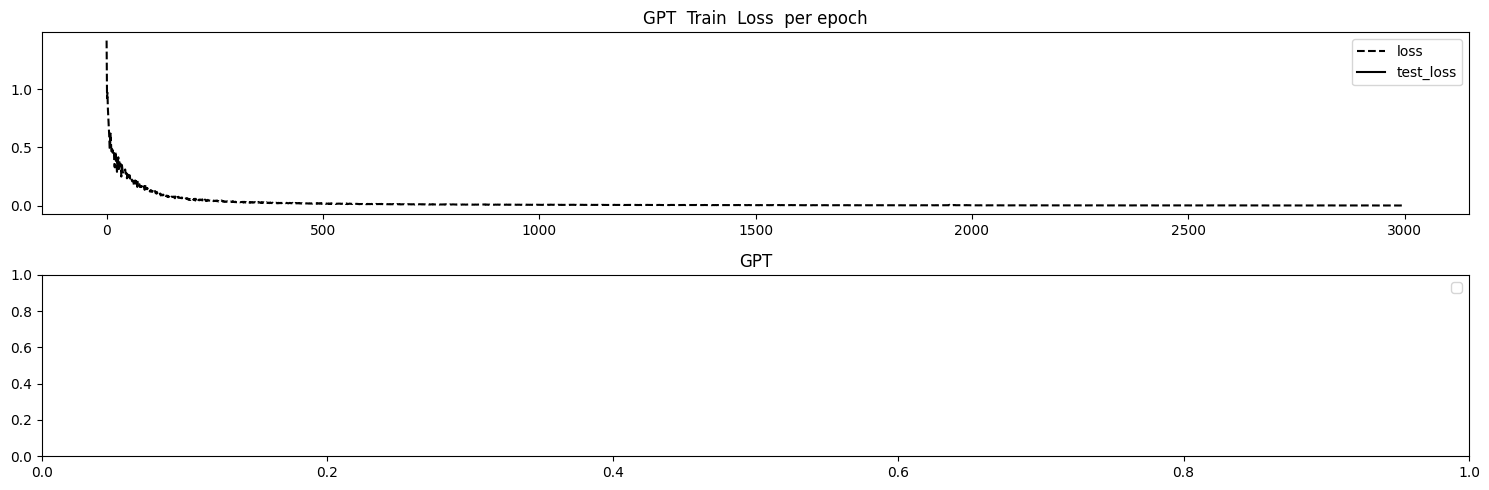

(15, 25)
(100, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.04767240211367607
Test MSE Loss - SI only 0-5:  0.0247101578861475
Test MSE Loss - SI only 5-10:  0.09137740731239319
Test MSE Loss - SI only 10-15:  0.028741173446178436
mae, mse, rmse, mape, mspe, rse, corr
(0.16890803, 0.047672402, 0.21834011, 1.7059274, 3.9674325, 1.0799271)
Testing R**2 - SI only:  -0.16624222389582188
Testing R**2 - SI only:  -0.16624222389582188
Testing R**2 - All features:  0.8730889792668526


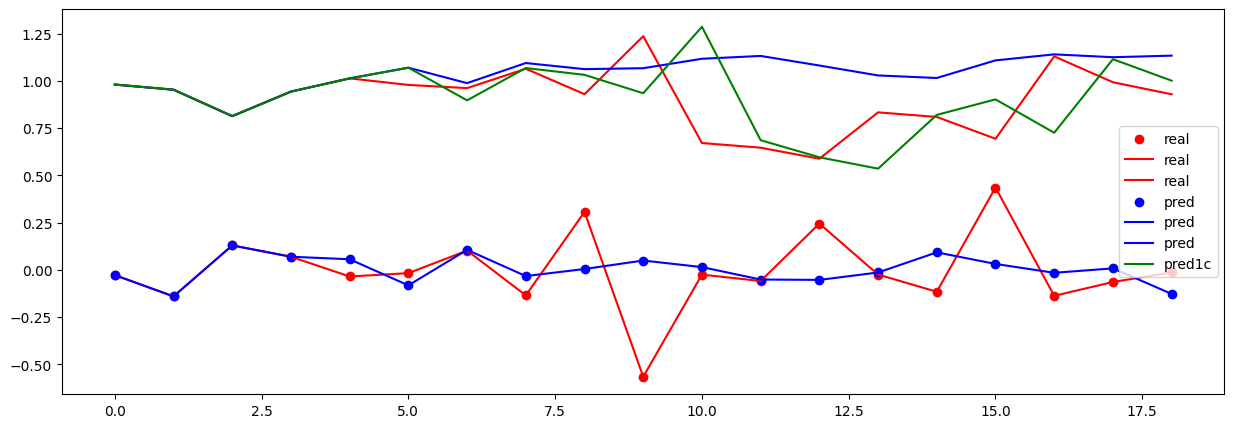

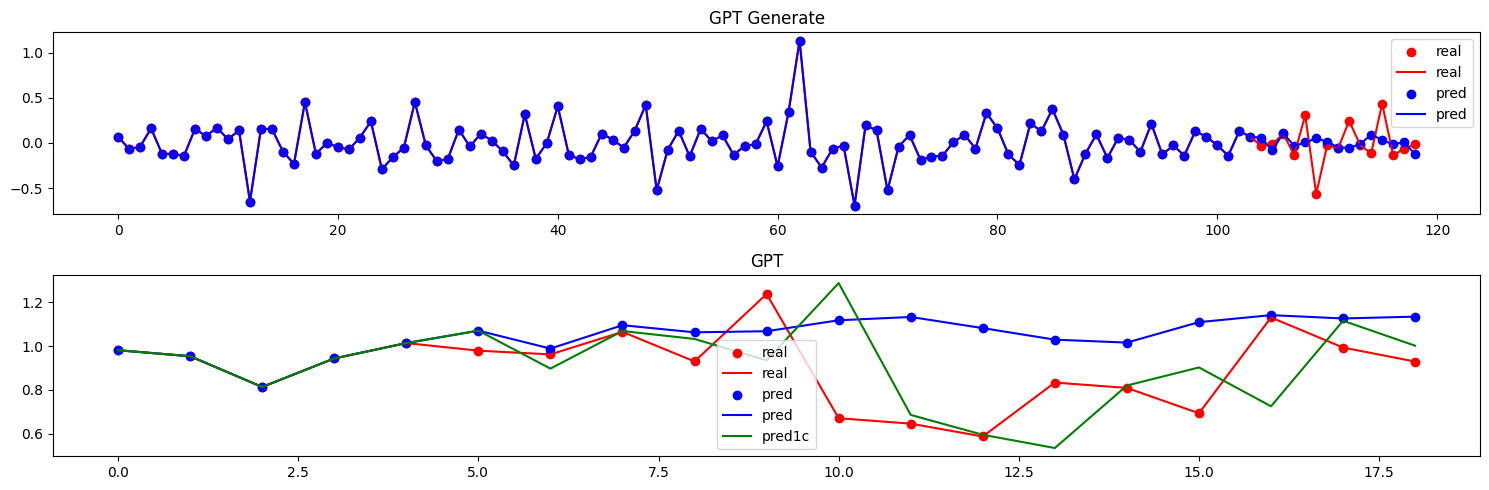

In [87]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk300to400_train )

results_string = function_test_rc(  chunk300to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run1" + "," + "300to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()


torch.Size([200, 25])
0 train loss =  1.1466566324234009
500 train loss =  0.04182950034737587
1000 train loss =  0.013882807455956936
1500 train loss =  0.007800496648997068
2000 train loss =  0.007212161552160978
2500 train loss =  0.004267321899533272


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


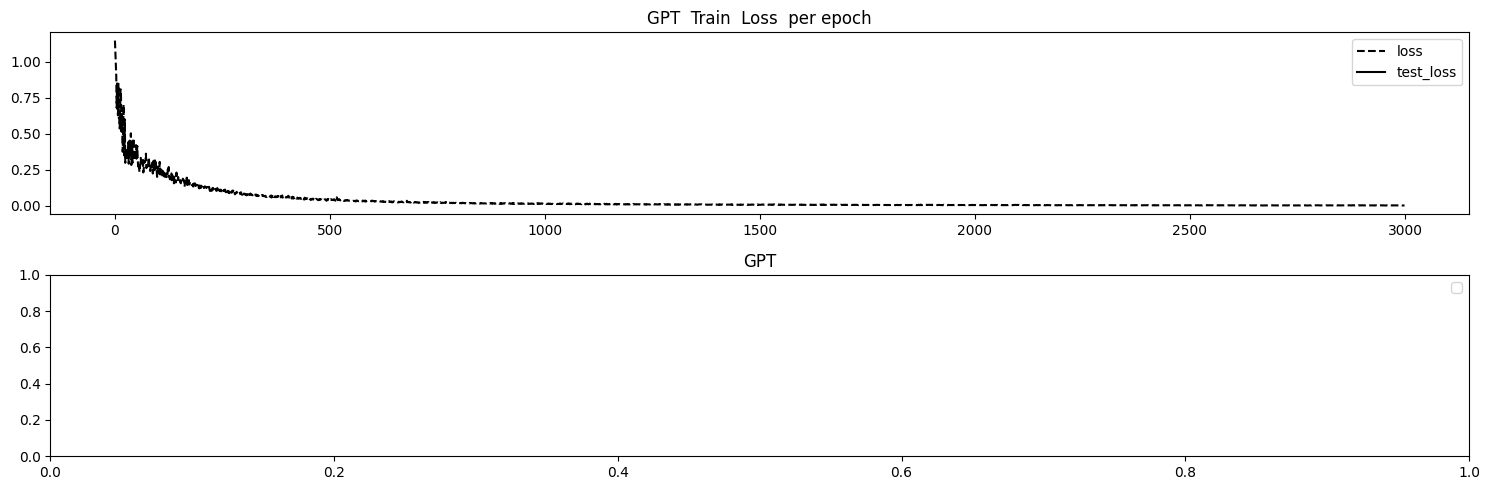

(15, 25)
(200, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.051525842398405075
Test MSE Loss - SI only 0-5:  0.0247101578861475
Test MSE Loss - SI only 5-10:  0.07293418794870377
Test MSE Loss - SI only 10-15:  0.049171701073646545
mae, mse, rmse, mape, mspe, rse, corr
(0.1836065, 0.051525842, 0.22699304, 2.6107094, 16.224342, 1.1227251)
Testing R**2 - SI only:  -0.2605115846345498
Testing R**2 - SI only:  -0.2605115846345498
Testing R**2 - All features:  0.9738419879564988


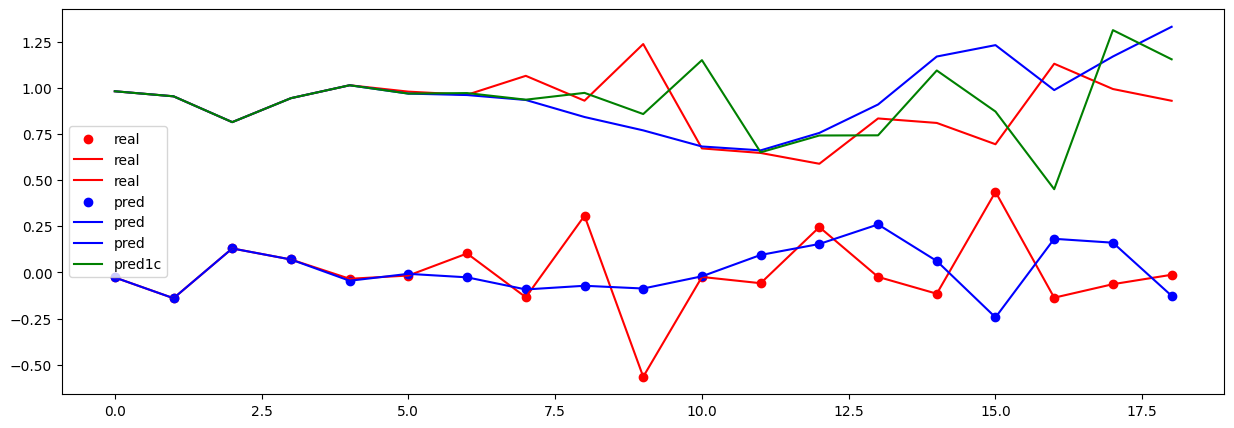

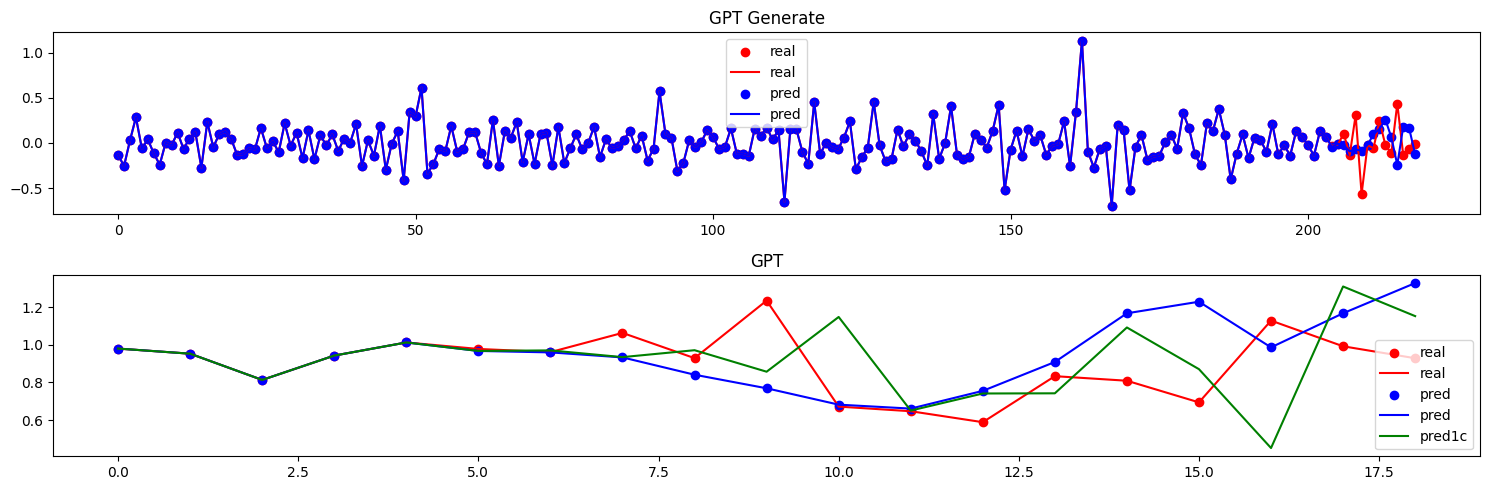

In [88]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk200to400_train )

results_string = function_test_rc(  chunk200to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run1" + "," + "200to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()



torch.Size([300, 25])
0 train loss =  1.0827739238739014
500 train loss =  0.06386975944042206
1000 train loss =  0.025451913475990295
1500 train loss =  0.011488832533359528
2000 train loss =  0.008350185118615627
2500 train loss =  0.006471291184425354


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


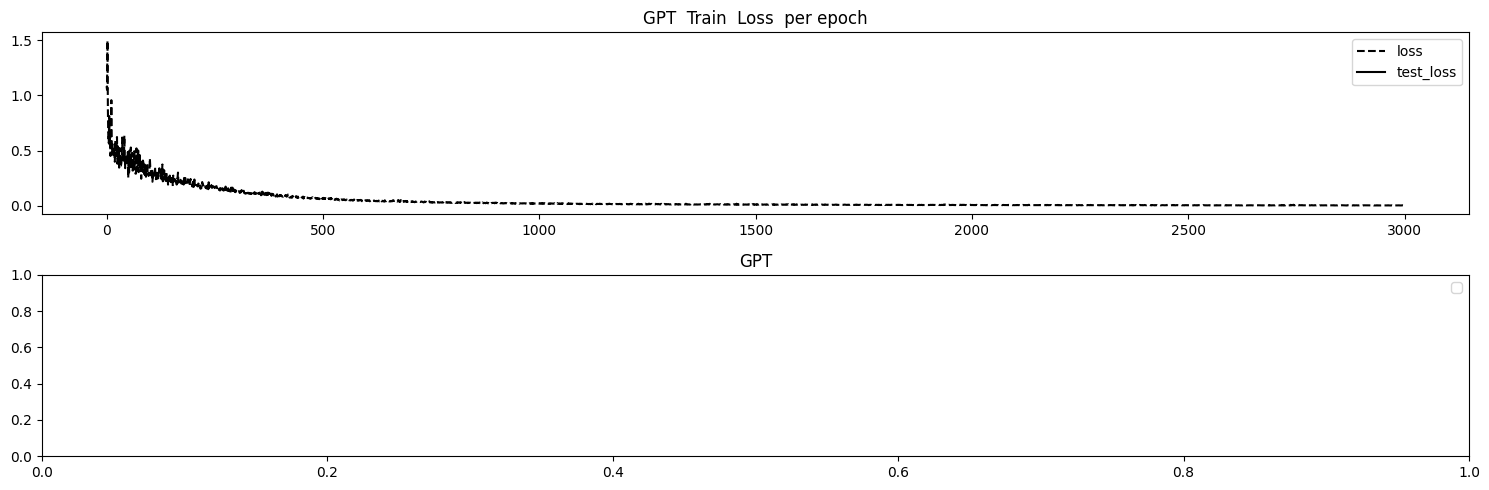

(15, 25)
(300, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.054531279951334
Test MSE Loss - SI only 0-5:  0.0247101578861475
Test MSE Loss - SI only 5-10:  0.08436756581068039
Test MSE Loss - SI only 10-15:  0.047894254326820374
mae, mse, rmse, mape, mspe, rse, corr
(0.17205259, 0.054531273, 0.23351932, 1.9645739, 6.7225027, 1.1550044)
Testing R**2 - SI only:  -0.33403549451737646
Testing R**2 - SI only:  -0.33403549451737646
Testing R**2 - All features:  0.9543955408558016


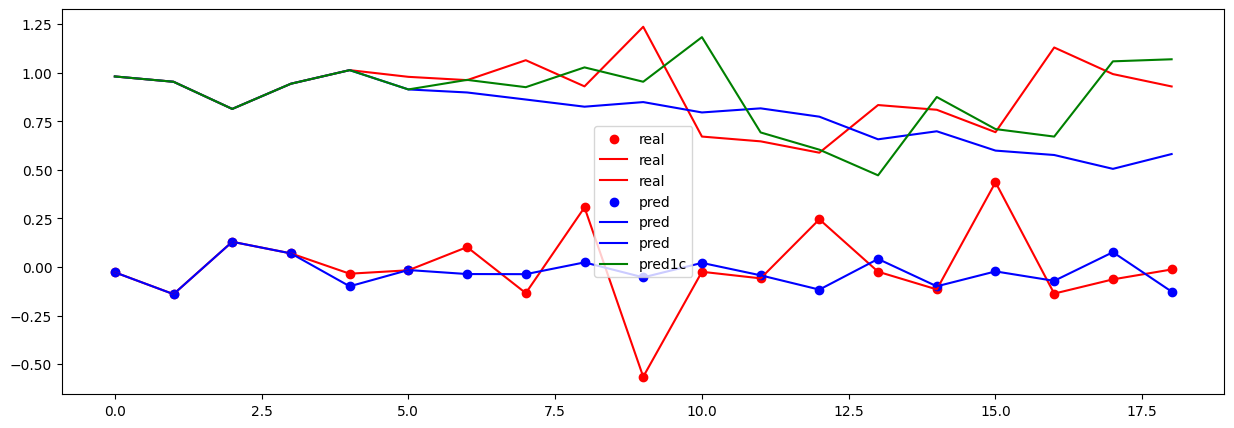

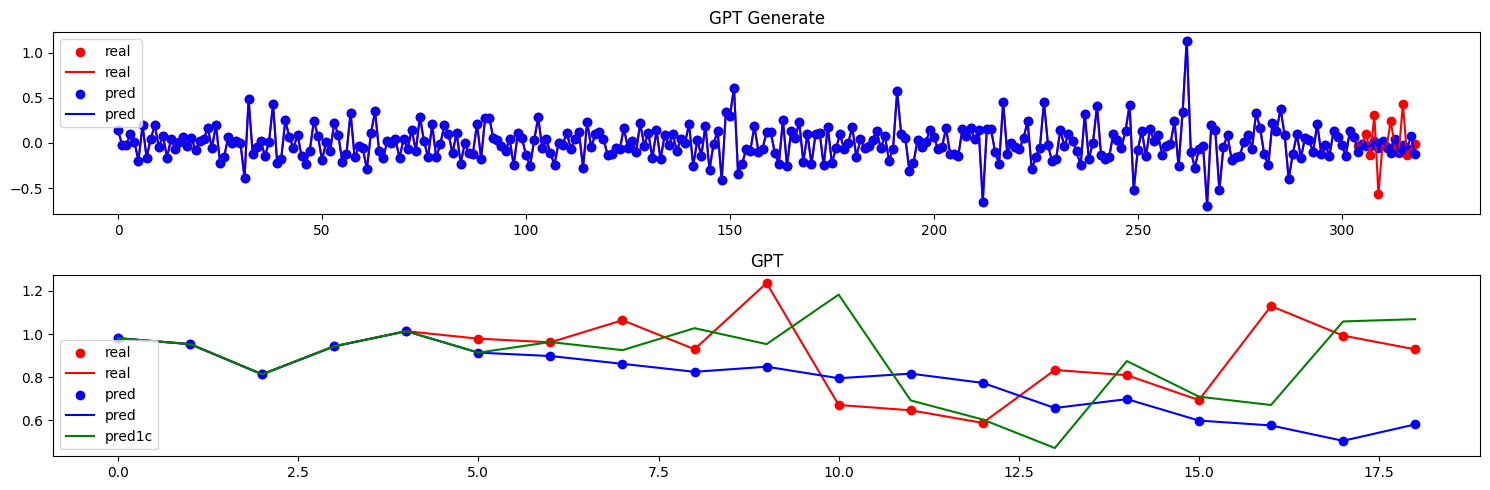

In [89]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk100to400_train  )

results_string = function_test_rc(  chunk100to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run1" + "," + "100to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close() 


torch.Size([400, 25])
0 train loss =  1.1046159267425537
500 train loss =  0.10163065046072006
1000 train loss =  0.03340631723403931
1500 train loss =  0.017824474722146988
2000 train loss =  0.011421015486121178
2500 train loss =  0.008567199110984802


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


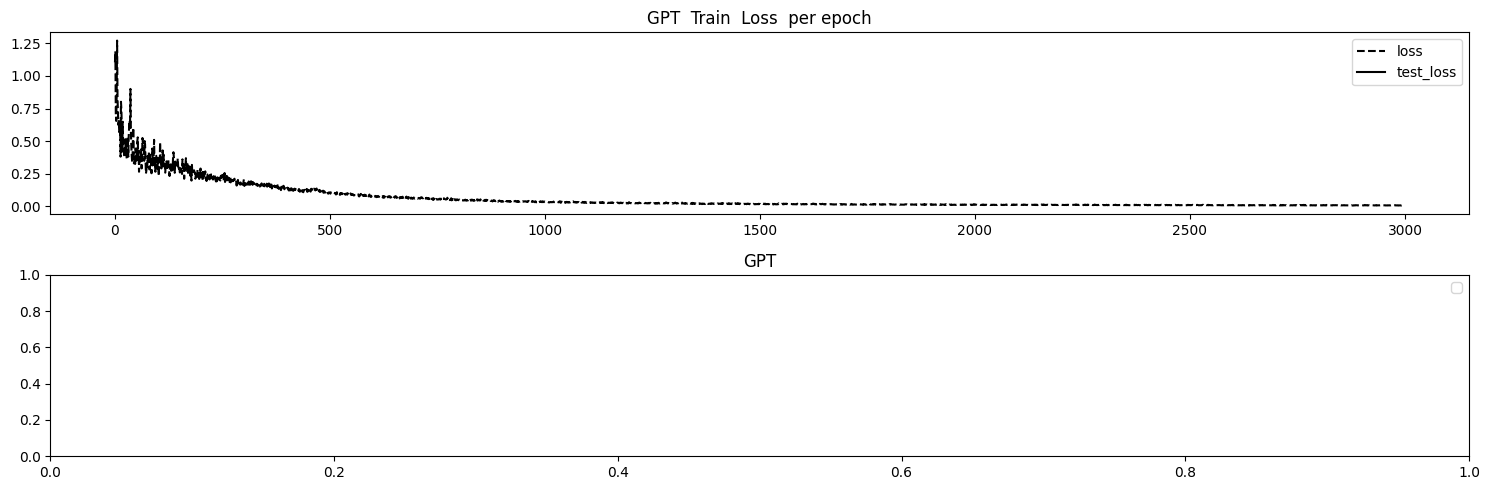

(15, 25)
(400, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.04285075142979622
Test MSE Loss - SI only 0-5:  0.0247101578861475
Test MSE Loss - SI only 5-10:  0.08019610494375229
Test MSE Loss - SI only 10-15:  0.026016321033239365
mae, mse, rmse, mape, mspe, rse, corr
(0.1540106, 0.042850748, 0.20700422, 1.6989692, 4.903504, 1.0238587)
Testing R**2 - SI only:  -0.04828676837524393
Testing R**2 - SI only:  -0.04828676837524393
Testing R**2 - All features:  0.8686334895973006


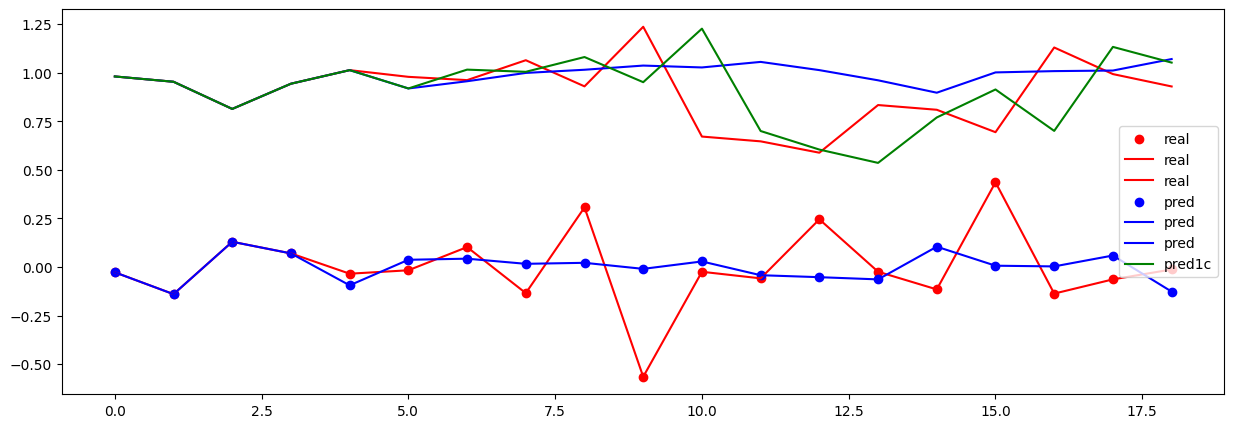

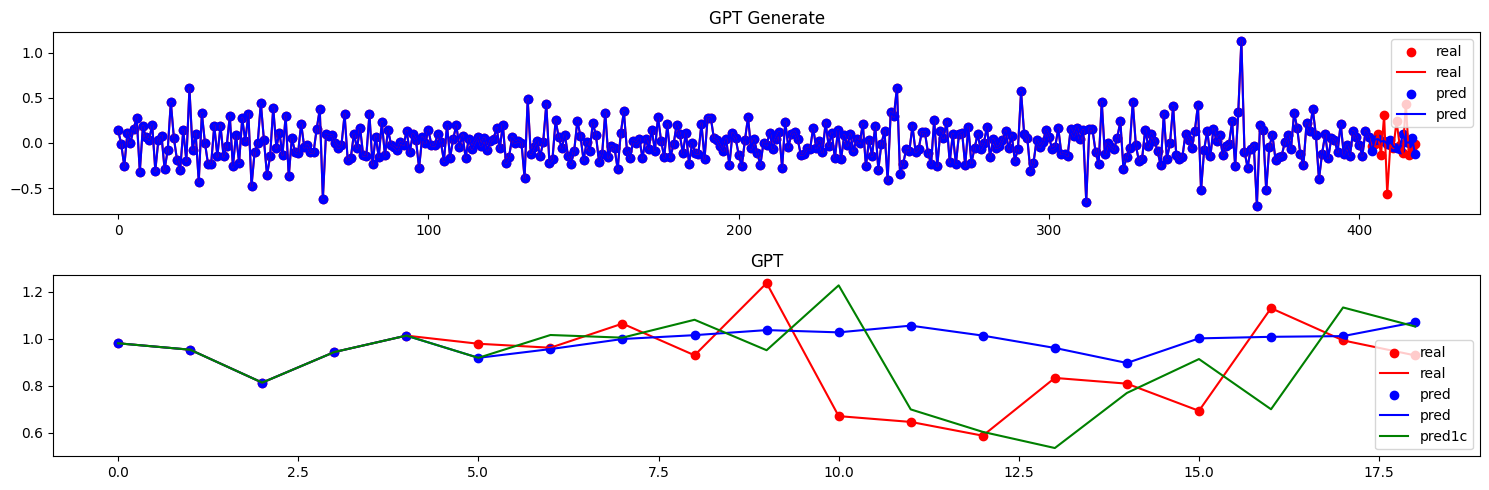

In [90]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk000to400_train )

results_string = function_test_rc(  chunk000to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run1" + "," + "000to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()



## Run 2


In [91]:

the_range = training_chunk + block_size

index_to_slice = random.randrange(0, length_n - the_range)

index_to_slice

print( for_RNN_data_CIVS.shape[0] )
print( index_to_slice )
print( index_to_slice + the_range )

sliced_chunk_CIVS = for_RNN_data_CIVS[ index_to_slice : index_to_slice + the_range]

n = block_size

print( n )

train_CIVS       = sliced_chunk_CIVS[   : -n ] 
test_CIVS        = sliced_chunk_CIVS[ -n:   ]

chunk300to400_train = train_CIVS[ 300  :  ] 
chunk200to400_train = train_CIVS[ 200  :  ]  
chunk100to400_train = train_CIVS[ 100  :  ] 
chunk000to400_train = train_CIVS[      :  ]  


print( chunk300to400_train.shape )
print( chunk200to400_train.shape )
print( chunk100to400_train.shape )
print( chunk000to400_train.shape )





1383
192
607
15
(100, 25)
(200, 25)
(300, 25)
(400, 25)


torch.Size([100, 25])
0 train loss =  1.6861220598220825
500 train loss =  0.019797122105956078
1000 train loss =  0.008310560137033463
1500 train loss =  0.005787098314613104
2000 train loss =  0.004546272102743387
2500 train loss =  0.0027406695298850536


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


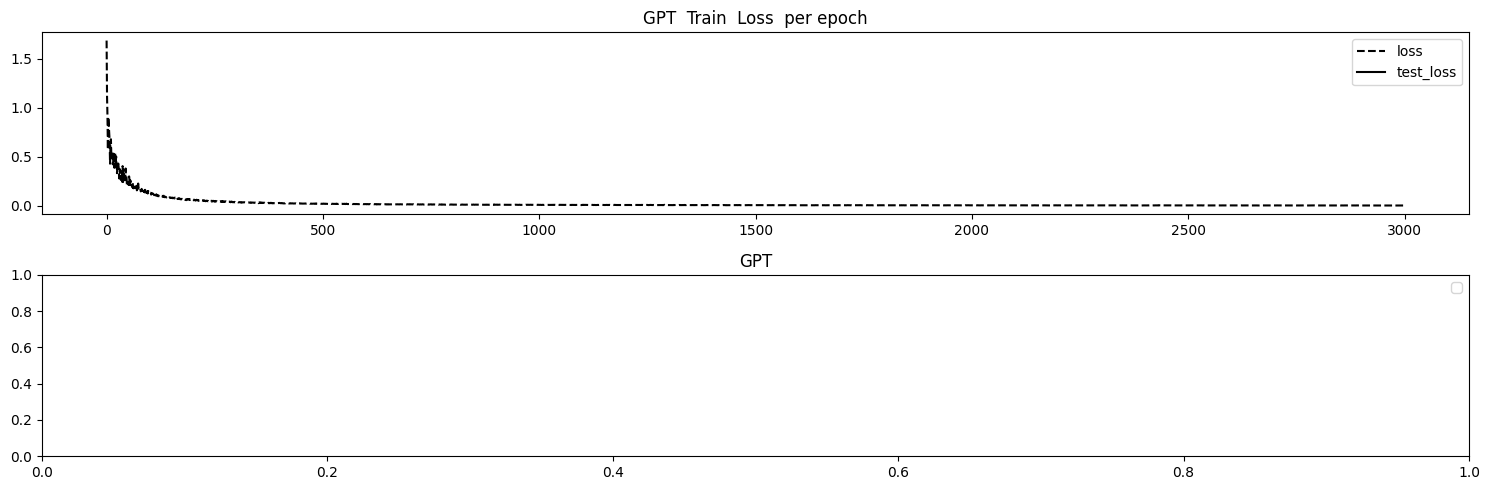

(15, 25)
(100, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.08309037983417511
Test MSE Loss - SI only 0-5:  0.04373735189437866
Test MSE Loss - SI only 5-10:  0.054040778428316116
Test MSE Loss - SI only 10-15:  0.11994702368974686
mae, mse, rmse, mape, mspe, rse, corr
(0.23004264, 0.08309037, 0.288254, 5.1171203, 136.09424, 1.7150316)
Testing R**2 - SI only:  -1.9413338662870347
Testing R**2 - SI only:  -1.9413338662870347
Testing R**2 - All features:  0.7644135102640551


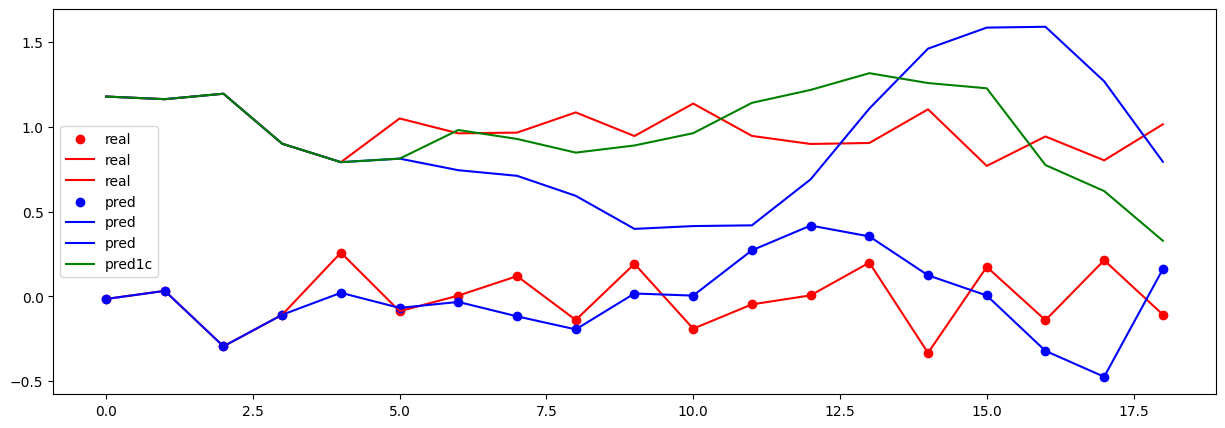

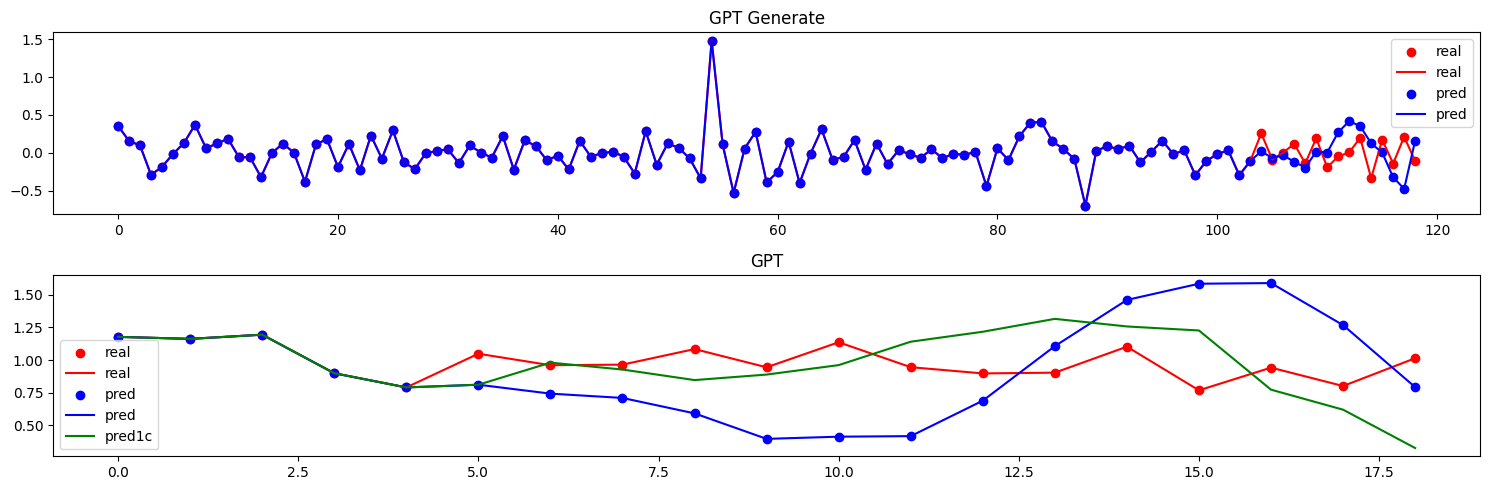

In [92]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk300to400_train )

results_string = function_test_rc(  chunk300to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run2" + "," + "300to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close() 



torch.Size([200, 25])
0 train loss =  1.1807793378829956
500 train loss =  0.054339293390512466
1000 train loss =  0.018272293731570244
1500 train loss =  0.01001345831900835
2000 train loss =  0.006897687446326017
2500 train loss =  0.004605225753039122


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


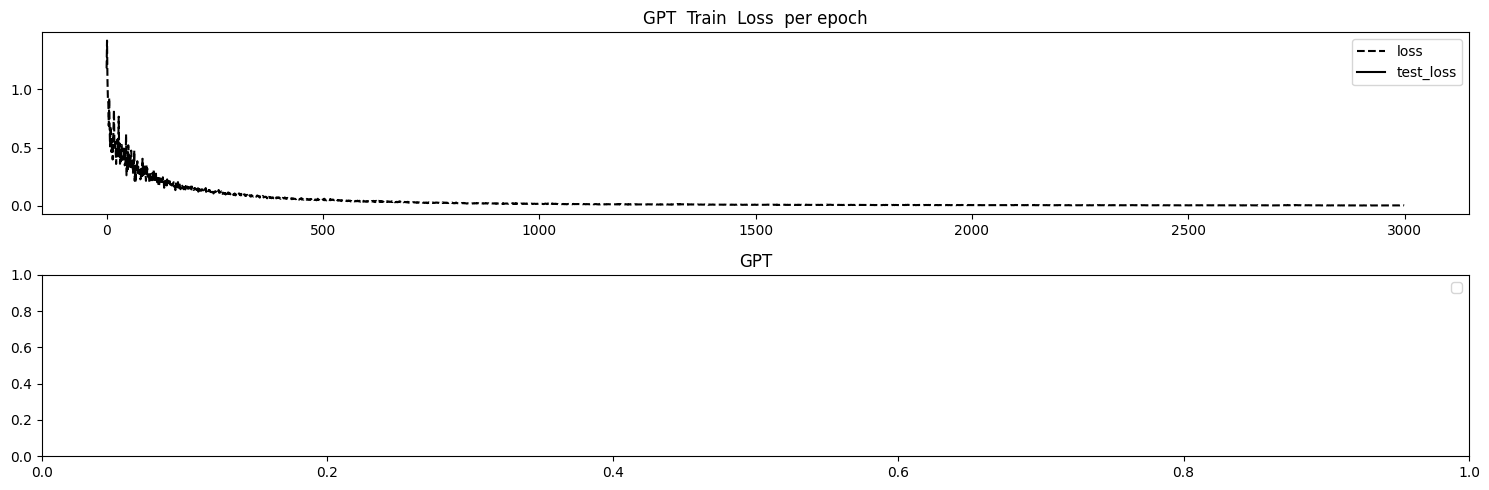

(15, 25)
(200, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.04206245392560959
Test MSE Loss - SI only 0-5:  0.04373735189437866
Test MSE Loss - SI only 5-10:  0.03424710035324097
Test MSE Loss - SI only 10-15:  0.04652828723192215
mae, mse, rmse, mape, mspe, rse, corr
(0.16609776, 0.04206245, 0.20509133, 2.7322671, 19.749815, 1.2202367)
Testing R**2 - SI only:  -0.4889776237781893
Testing R**2 - SI only:  -0.4889776237781893
Testing R**2 - All features:  0.9411468351048793


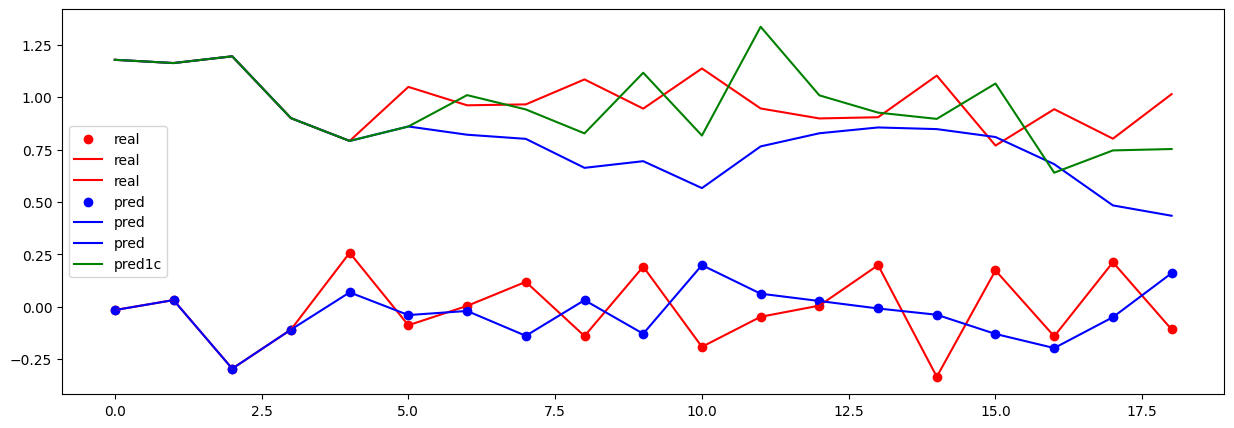

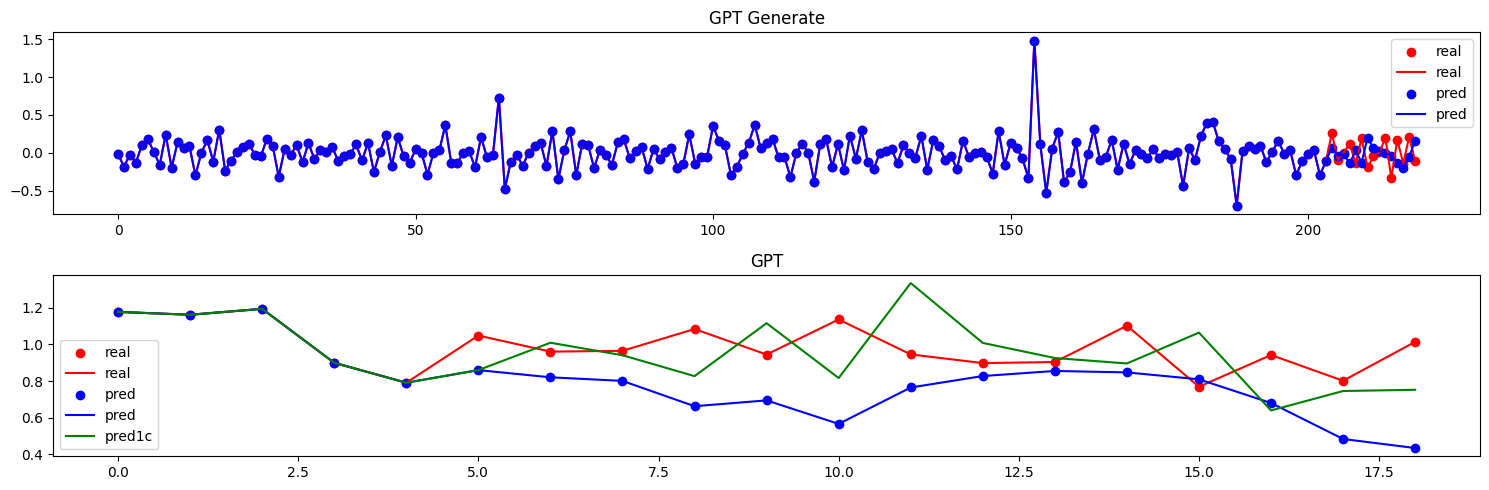

In [93]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk200to400_train )

results_string = function_test_rc(  chunk200to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run2" + "," + "200to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close() 


torch.Size([300, 25])
0 train loss =  1.2396652698516846
500 train loss =  0.09662312269210815
1000 train loss =  0.027150506153702736
1500 train loss =  0.015077905729413033
2000 train loss =  0.009888065047562122
2500 train loss =  0.007731775287538767


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


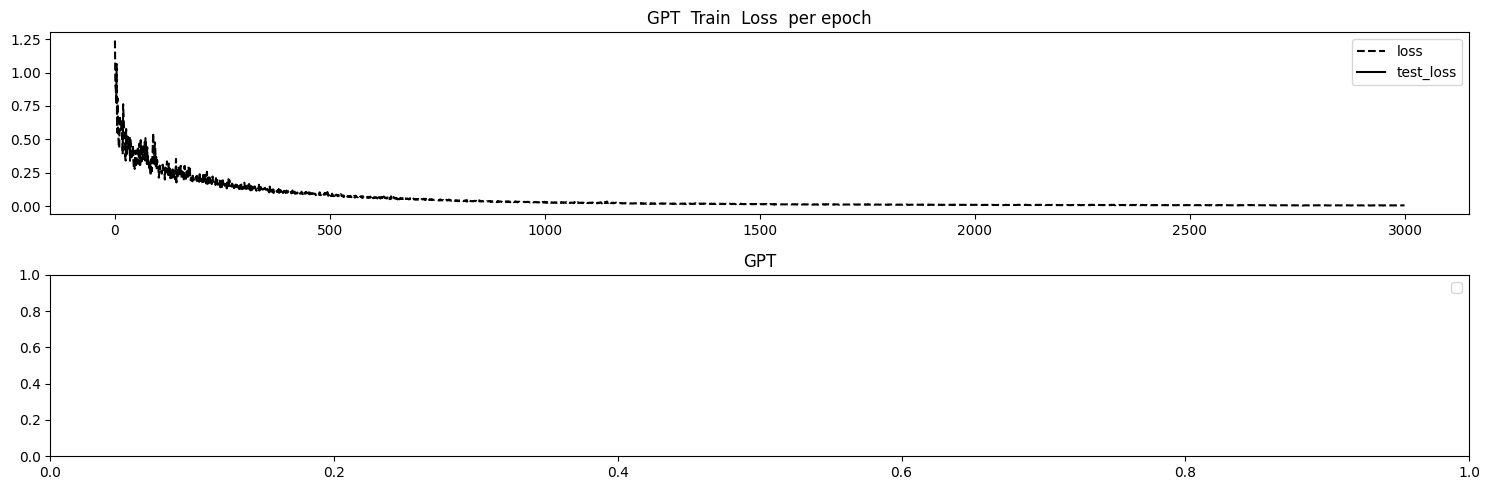

(15, 25)
(300, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.047117605805397034
Test MSE Loss - SI only 0-5:  0.04373735189437866
Test MSE Loss - SI only 5-10:  0.057570260018110275
Test MSE Loss - SI only 10-15:  0.041651513427495956
mae, mse, rmse, mape, mspe, rse, corr
(0.19117828, 0.04711761, 0.21706592, 2.520574, 14.137448, 1.2914822)
Testing R**2 - SI only:  -0.6679261300957784
Testing R**2 - SI only:  -0.6679261300957784
Testing R**2 - All features:  0.9736147623985062


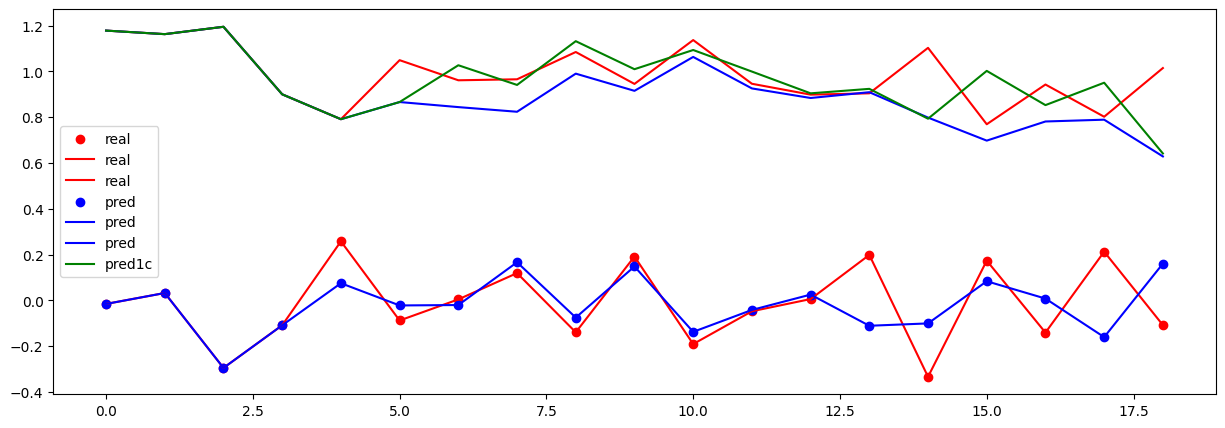

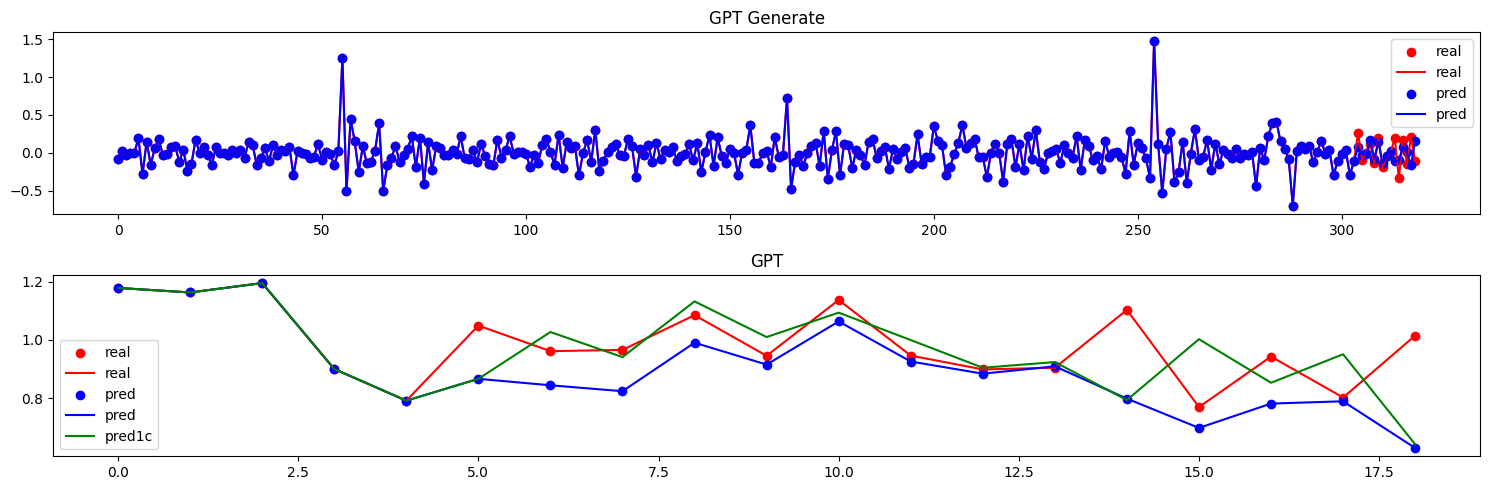

In [94]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk100to400_train  )

results_string = function_test_rc(  chunk100to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run2" + "," + "100to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close() 


torch.Size([400, 25])
0 train loss =  1.1370892524719238
500 train loss =  0.10356971621513367
1000 train loss =  0.04677161946892738
1500 train loss =  0.022977737709879875
2000 train loss =  0.014319775626063347
2500 train loss =  0.008563709445297718


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


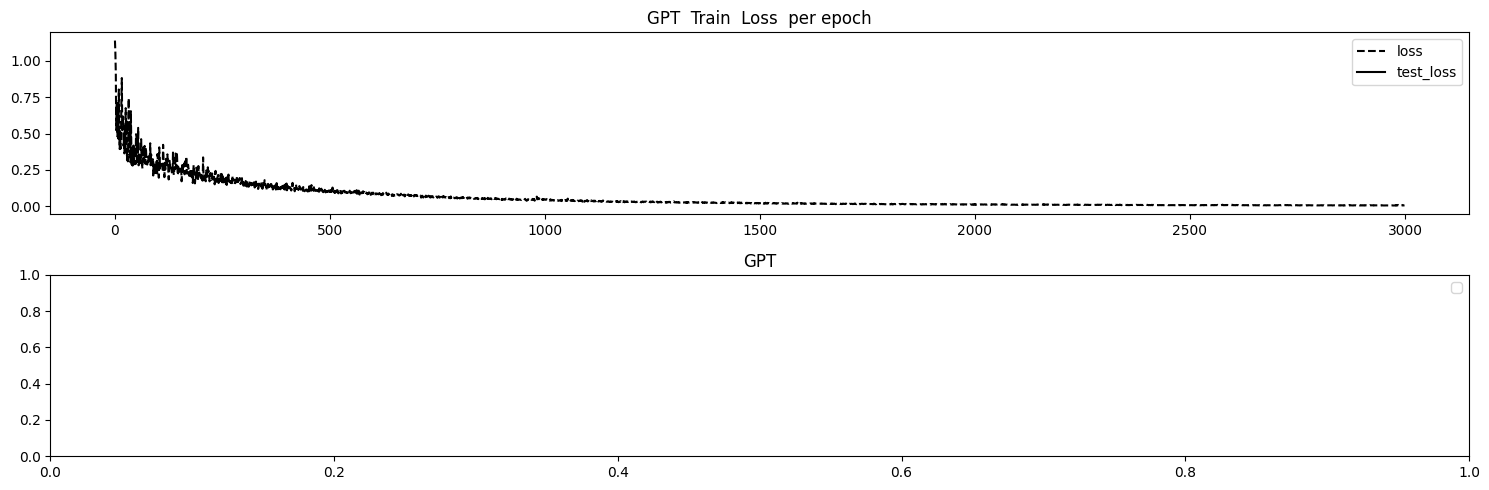

(15, 25)
(400, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.04192596301436424
Test MSE Loss - SI only 0-5:  0.04373735189437866
Test MSE Loss - SI only 5-10:  0.03545103594660759
Test MSE Loss - SI only 10-15:  0.045437511056661606
mae, mse, rmse, mape, mspe, rse, corr
(0.17700072, 0.041925963, 0.2047583, 5.106692, 116.93699, 1.2182554)
Testing R**2 - SI only:  -0.4841459476287042
Testing R**2 - SI only:  -0.4841459476287042
Testing R**2 - All features:  0.9813516352388929


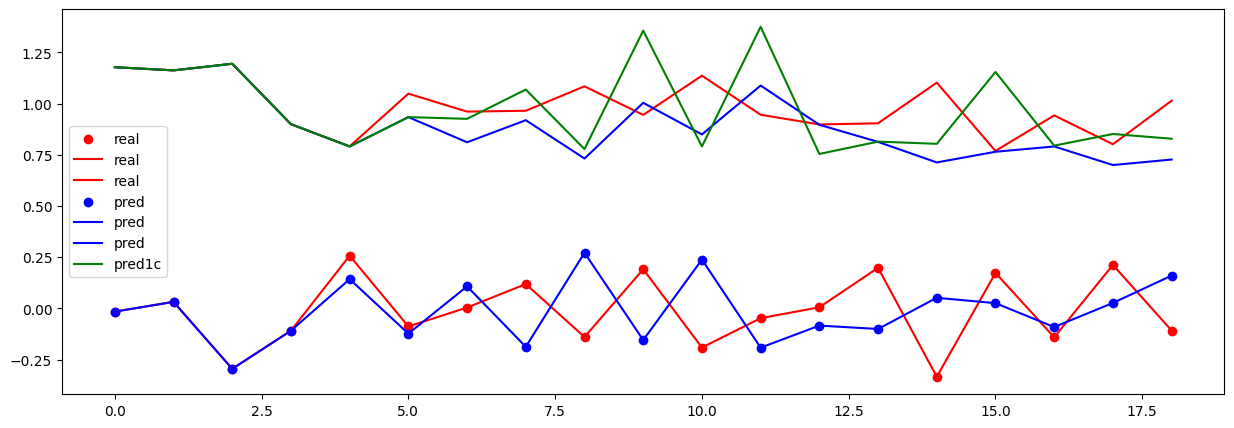

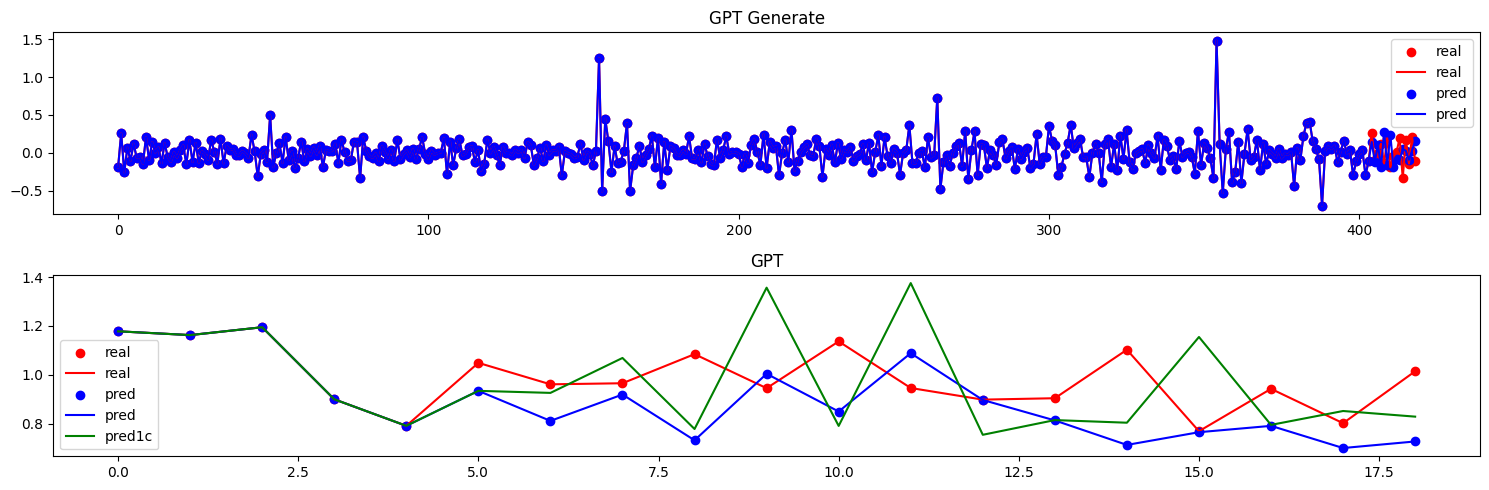

In [95]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk000to400_train )

results_string = function_test_rc(  chunk000to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run2" + "," + "000to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()



## Run 3


In [96]:

the_range = training_chunk + block_size

index_to_slice = random.randrange(0, length_n - the_range)

index_to_slice

print( for_RNN_data_CIVS.shape[0] )
print( index_to_slice )
print( index_to_slice + the_range )

sliced_chunk_CIVS = for_RNN_data_CIVS[ index_to_slice : index_to_slice + the_range]

n = block_size

print( n )

train_CIVS       = sliced_chunk_CIVS[   : -n ] 
test_CIVS        = sliced_chunk_CIVS[ -n:   ]

chunk300to400_train = train_CIVS[ 300  :  ] 
chunk200to400_train = train_CIVS[ 200  :  ]  
chunk100to400_train = train_CIVS[ 100  :  ] 
chunk000to400_train = train_CIVS[      :  ] 


print( chunk300to400_train.shape )
print( chunk200to400_train.shape )
print( chunk100to400_train.shape )
print( chunk000to400_train.shape )



1383
757
1172
15
(100, 25)
(200, 25)
(300, 25)
(400, 25)


torch.Size([100, 25])
0 train loss =  1.1645466089248657
500 train loss =  0.020130425691604614
1000 train loss =  0.008724701590836048
1500 train loss =  0.005235637538135052
2000 train loss =  0.00419496139511466
2500 train loss =  0.0030296379700303078


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


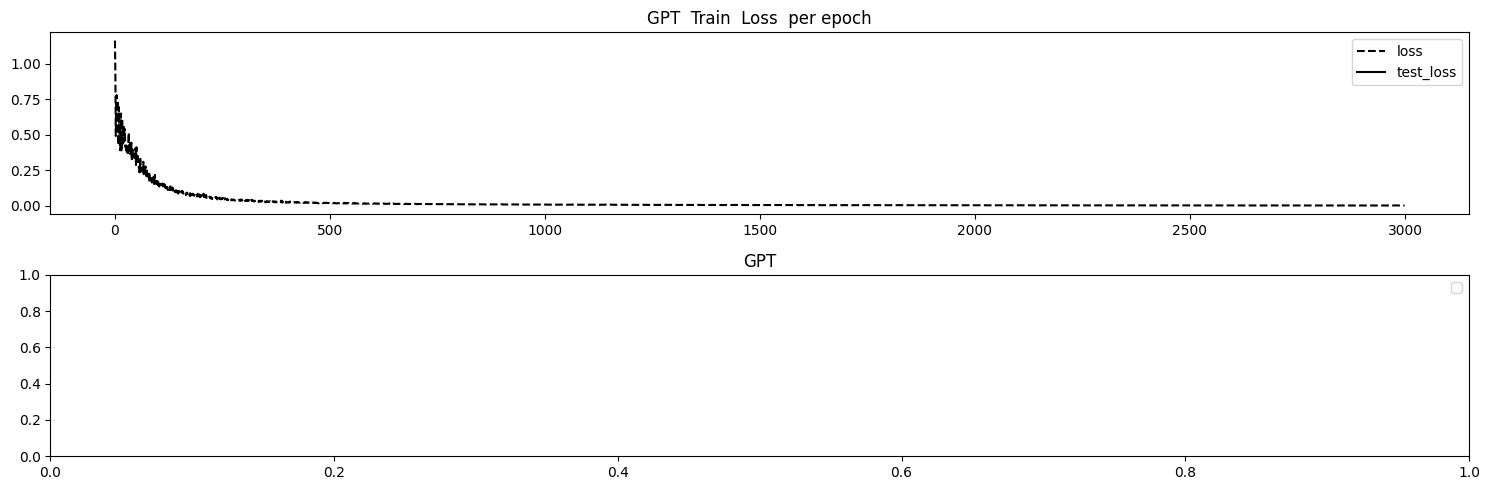

(15, 25)
(100, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.095662422478199
Test MSE Loss - SI only 0-5:  0.14818152785301208
Test MSE Loss - SI only 5-10:  0.07384505867958069
Test MSE Loss - SI only 10-15:  0.08686551451683044
mae, mse, rmse, mape, mspe, rse, corr
(0.24728459, 0.095662415, 0.30929342, 6.6748285, 452.02597, 1.6422033)
Testing R**2 - SI only:  -1.6968323534473915
Testing R**2 - SI only:  -1.6968323534473915
Testing R**2 - All features:  0.9921617224506233


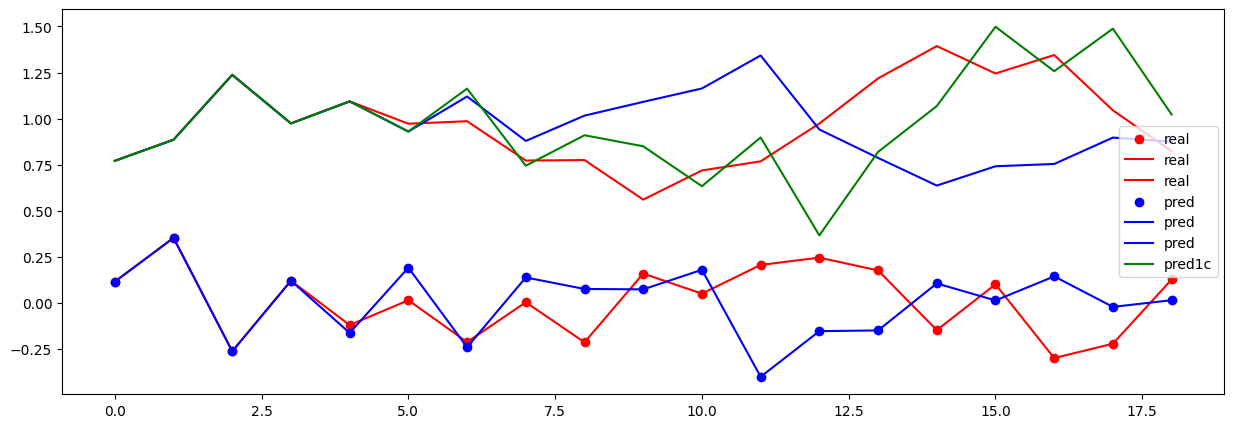

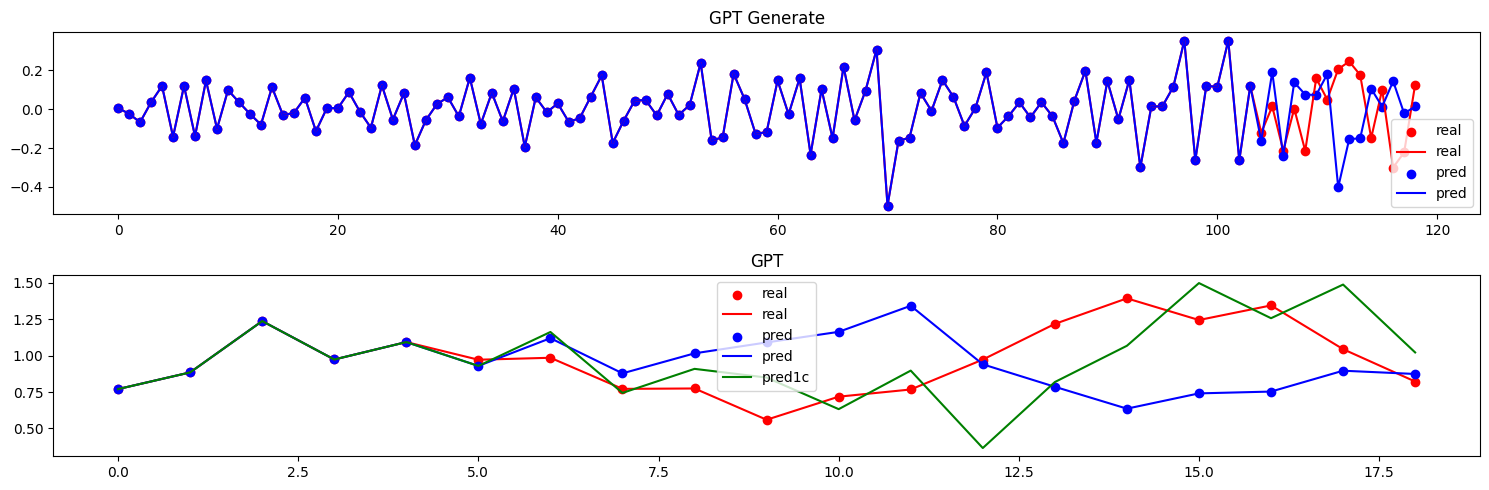

In [97]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk300to400_train )

results_string = function_test_rc(  chunk300to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run3" + "," + "300to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()



torch.Size([200, 25])
0 train loss =  1.2199276685714722
500 train loss =  0.04390771687030792
1000 train loss =  0.016716700047254562
1500 train loss =  0.009607094340026379
2000 train loss =  0.006558403372764587
2500 train loss =  0.004536230117082596


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


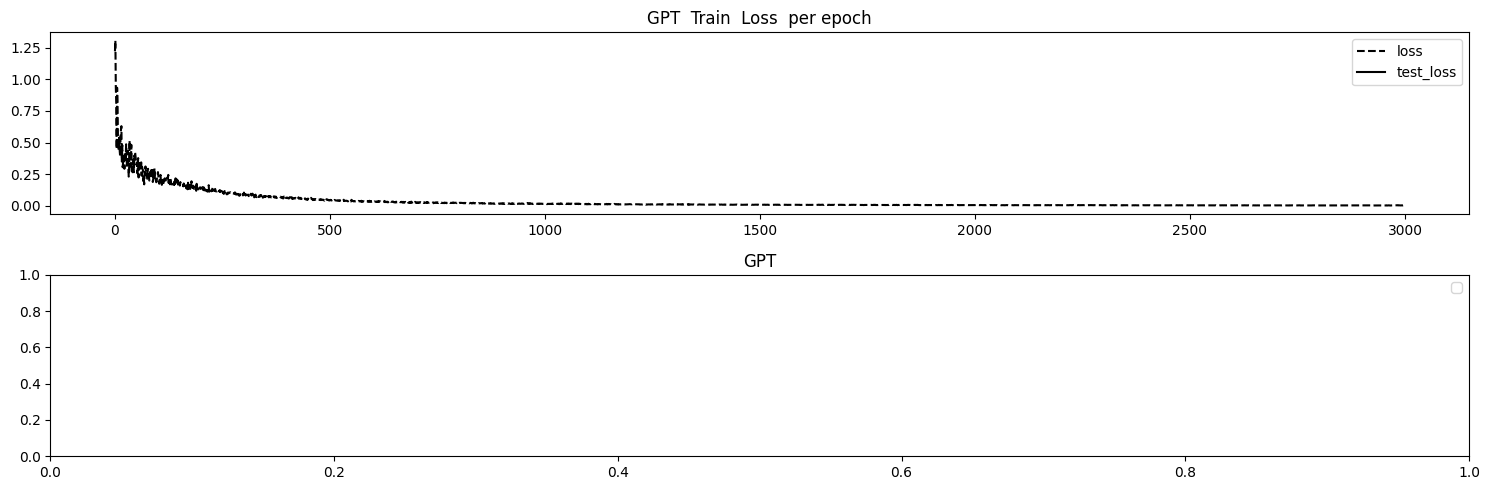

(15, 25)
(200, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.06262903660535812
Test MSE Loss - SI only 0-5:  0.14818152785301208
Test MSE Loss - SI only 5-10:  0.04894012585282326
Test MSE Loss - SI only 10-15:  0.03373163565993309
mae, mse, rmse, mape, mspe, rse, corr
(0.19983317, 0.06262903, 0.25025794, 1.5340388, 4.1006646, 1.3287525)
Testing R**2 - SI only:  -0.7655834902071019
Testing R**2 - SI only:  -0.7655834902071019
Testing R**2 - All features:  0.9922417533353706


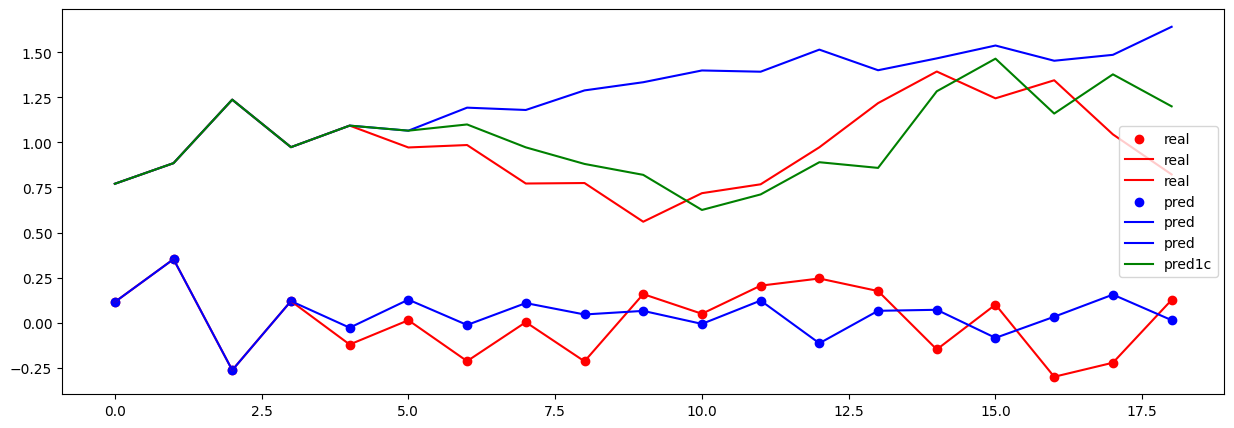

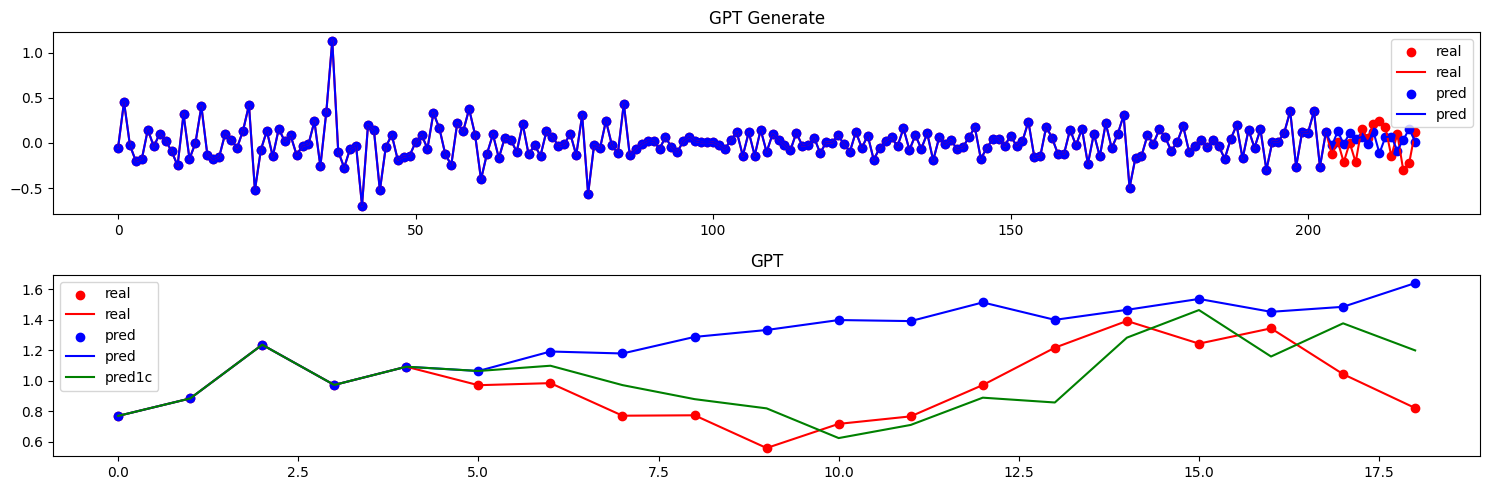

In [98]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk200to400_train )

results_string = function_test_rc(  chunk200to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run3" + "," + "200to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close() 



torch.Size([300, 25])
0 train loss =  1.0665924549102783
500 train loss =  0.08207452297210693
1000 train loss =  0.024569978937506676
1500 train loss =  0.01371624507009983
2000 train loss =  0.008794056251645088
2500 train loss =  0.006411168724298477


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


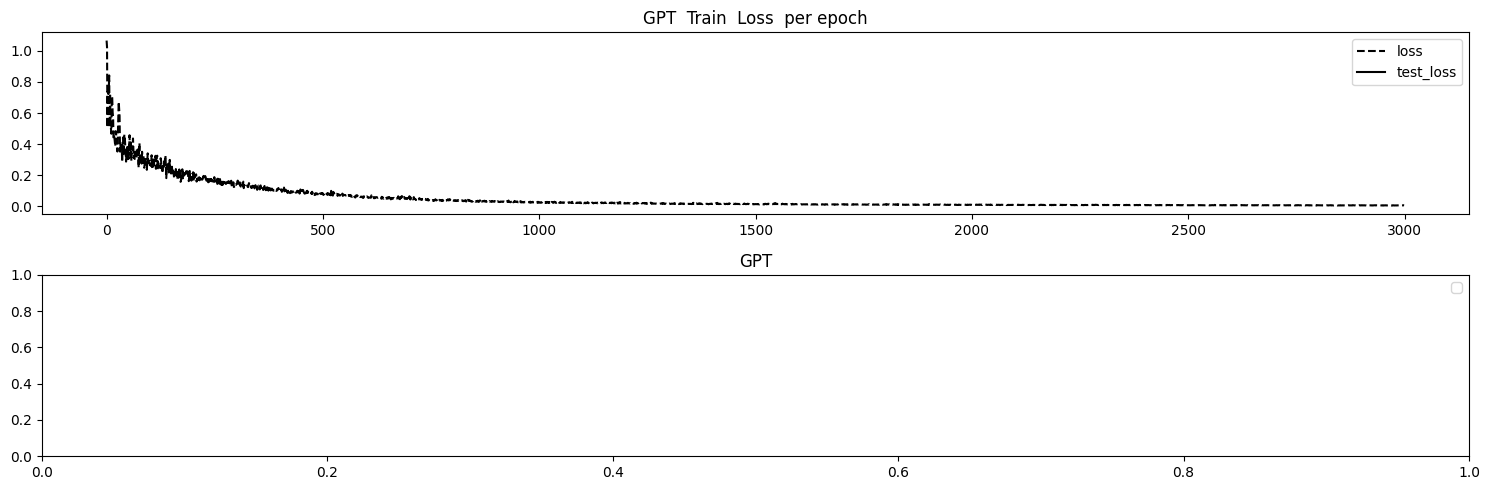

(15, 25)
(300, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.07988715171813965
Test MSE Loss - SI only 0-5:  0.14818152785301208
Test MSE Loss - SI only 5-10:  0.048389971256256104
Test MSE Loss - SI only 10-15:  0.07053221017122269
mae, mse, rmse, mape, mspe, rse, corr
(0.23451215, 0.079887144, 0.28264314, 2.186536, 9.682437, 1.5007029)
Testing R**2 - SI only:  -1.252109371101728
Testing R**2 - SI only:  -1.252109371101728
Testing R**2 - All features:  0.9881035477144635


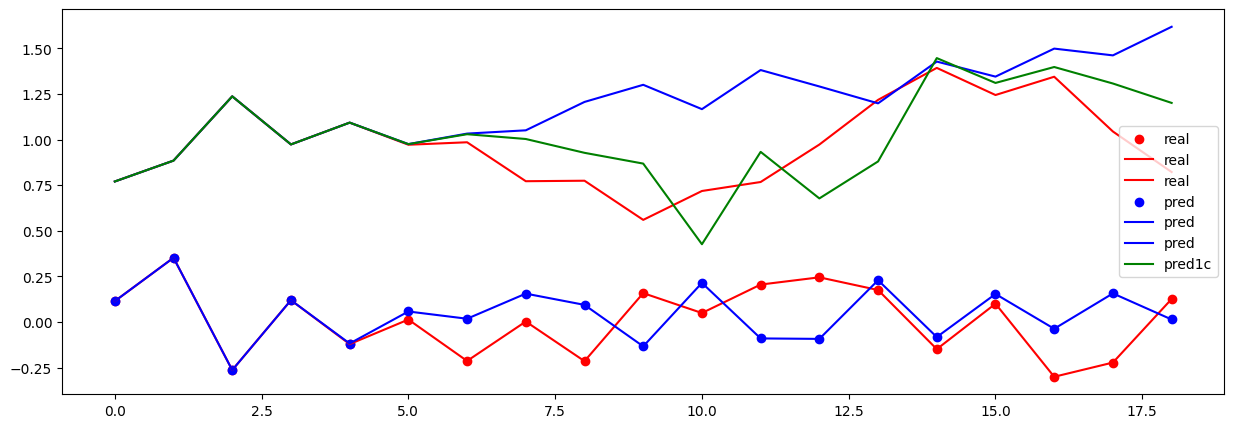

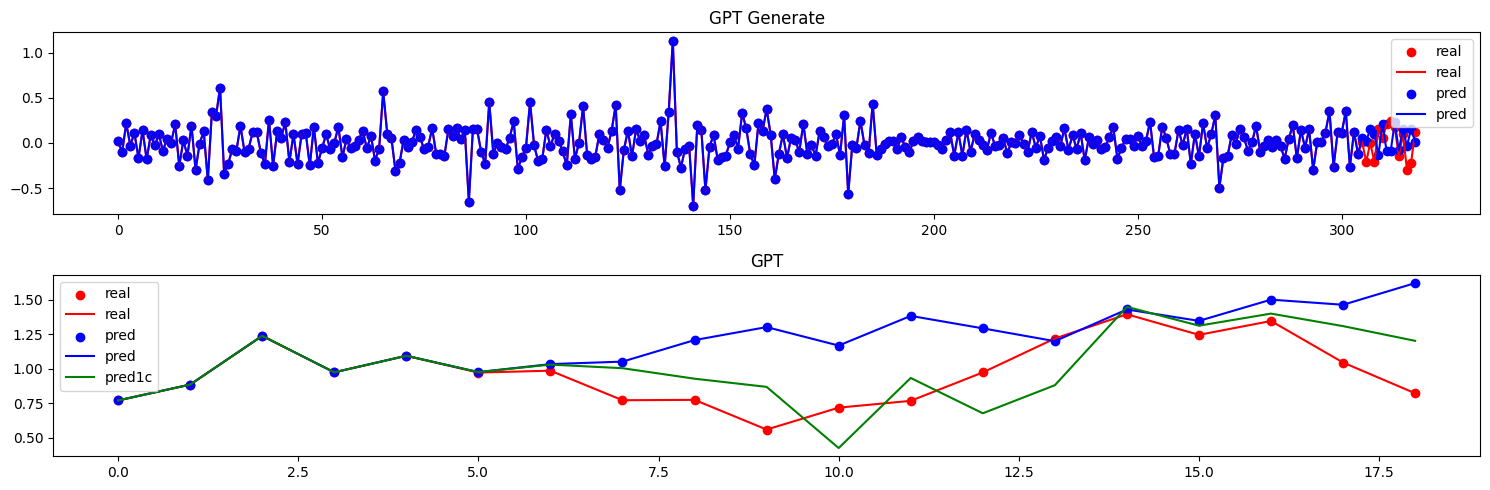

In [99]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk100to400_train  )

results_string  = function_test_rc(  chunk100to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run3" + "," + "100to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()


torch.Size([400, 25])
0 train loss =  1.4832438230514526
500 train loss =  0.10140853375196457
1000 train loss =  0.03352978825569153
1500 train loss =  0.018120072782039642
2000 train loss =  0.013297509402036667
2500 train loss =  0.007576108910143375


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


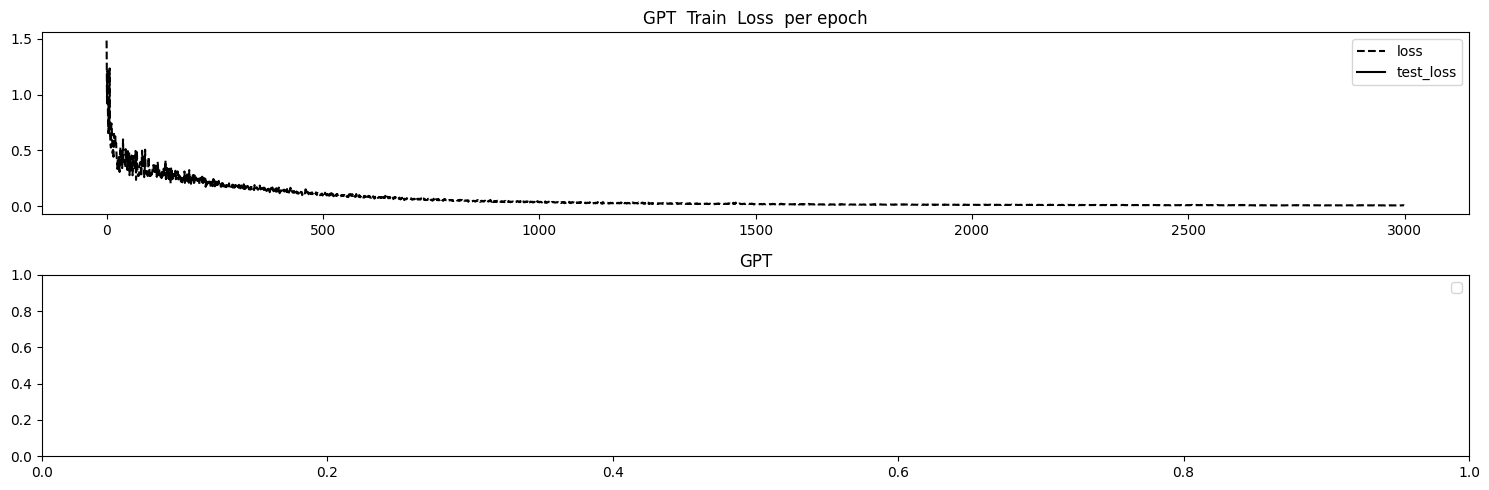

(15, 25)
(400, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.05927174910902977
Test MSE Loss - SI only 0-5:  0.14818152785301208
Test MSE Loss - SI only 5-10:  0.038500454276800156
Test MSE Loss - SI only 10-15:  0.03360383212566376
mae, mse, rmse, mape, mspe, rse, corr
(0.19757824, 0.05927175, 0.2434579, 2.9662657, 38.48649, 1.2926476)
Testing R**2 - SI only:  -0.6709380527455062
Testing R**2 - SI only:  -0.6709380527455062
Testing R**2 - All features:  0.9935365164430905


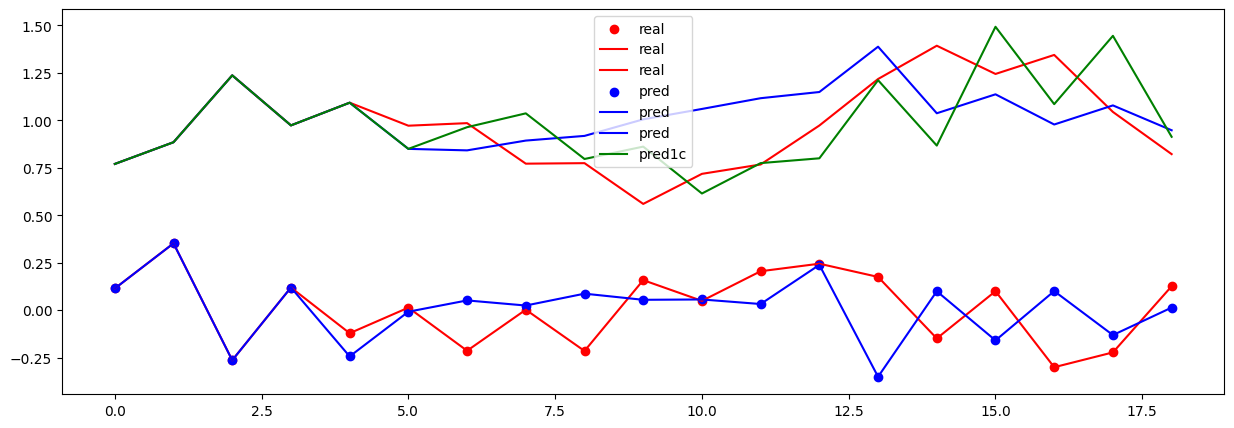

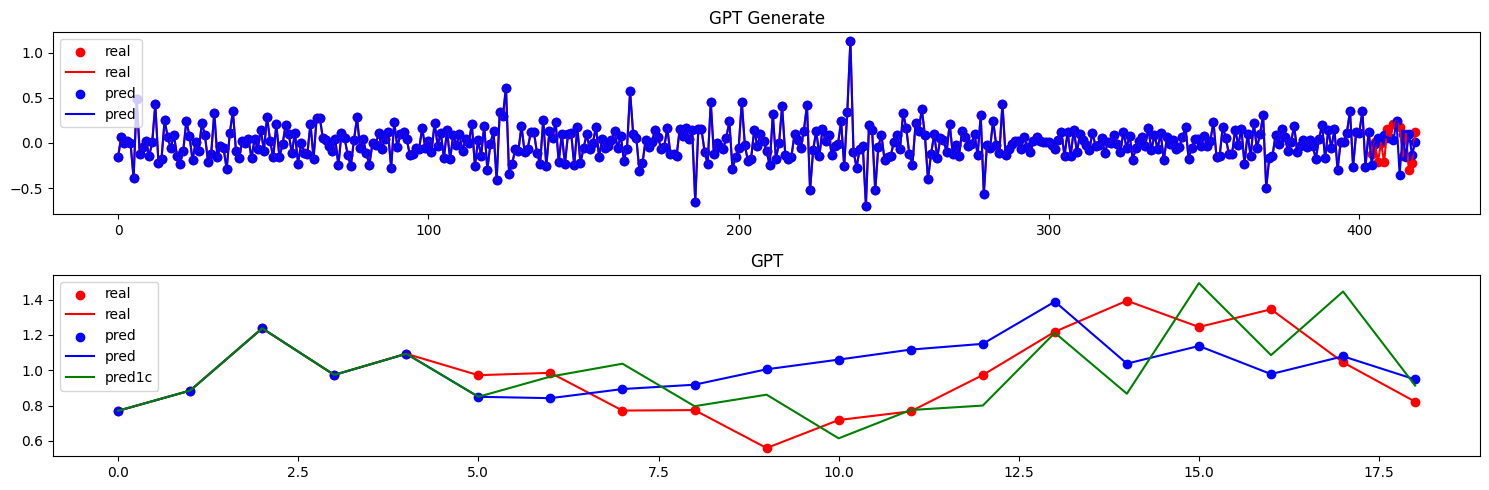

In [100]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk000to400_train )

results_string = function_test_rc(  chunk000to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run3" + "," + "000to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()



## Run 4


In [101]:

the_range = training_chunk + block_size

index_to_slice = random.randrange(0, length_n - the_range)

index_to_slice

print( for_RNN_data_CIVS.shape[0] )
print( index_to_slice )
print( index_to_slice + the_range )

sliced_chunk_CIVS = for_RNN_data_CIVS[ index_to_slice : index_to_slice + the_range]

n = block_size

print( n )

train_CIVS       = sliced_chunk_CIVS[   : -n ] 
test_CIVS        = sliced_chunk_CIVS[ -n:   ]

chunk300to400_train = train_CIVS[ 300  :  ] 
chunk200to400_train = train_CIVS[ 200  :  ]  
chunk100to400_train = train_CIVS[ 100  :  ] 
chunk000to400_train = train_CIVS[      :  ] 


print( chunk300to400_train.shape )
print( chunk200to400_train.shape )
print( chunk100to400_train.shape )
print( chunk000to400_train.shape )


1383
845
1260
15
(100, 25)
(200, 25)
(300, 25)
(400, 25)


torch.Size([100, 25])
0 train loss =  1.0969964265823364
500 train loss =  0.017225759103894234
1000 train loss =  0.009125097654759884
1500 train loss =  0.005254073068499565
2000 train loss =  0.004065497778356075
2500 train loss =  0.0031976045574992895


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


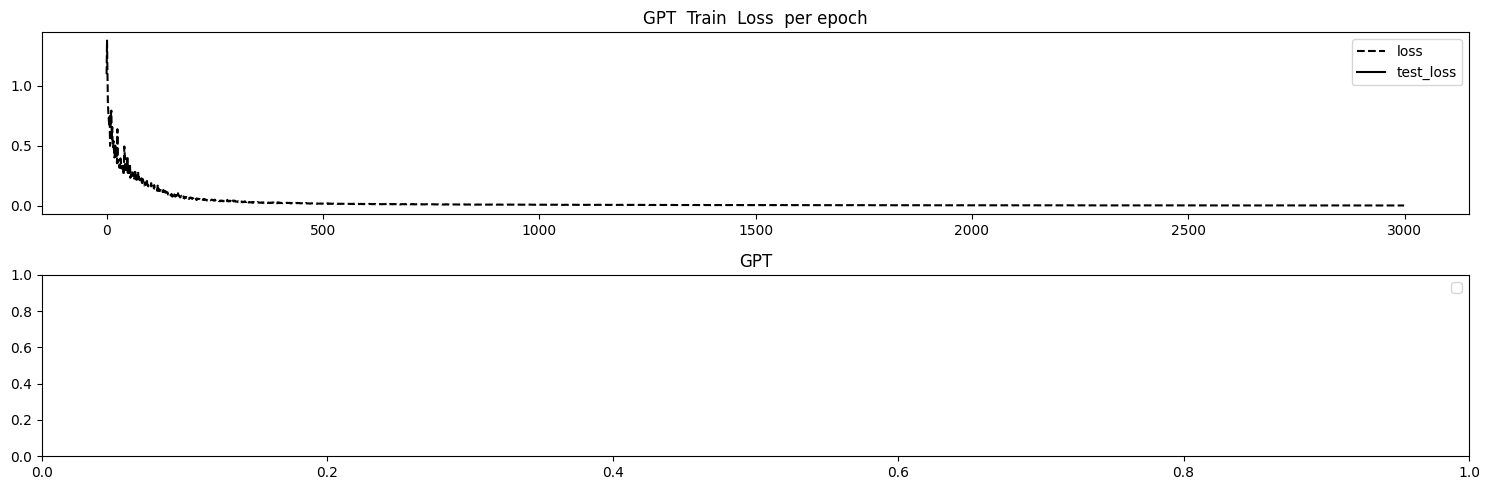

(15, 25)
(100, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.02627382054924965
Test MSE Loss - SI only 0-5:  0.0483187660574913
Test MSE Loss - SI only 5-10:  0.025708971545100212
Test MSE Loss - SI only 10-15:  0.01685262843966484
mae, mse, rmse, mape, mspe, rse, corr
(0.14151567, 0.02627382, 0.16209202, 5.180342, 111.71542, 1.1749845)
Testing R**2 - SI only:  -0.3805884073309631
Testing R**2 - SI only:  -0.3805884073309631
Testing R**2 - All features:  0.9965450725833346


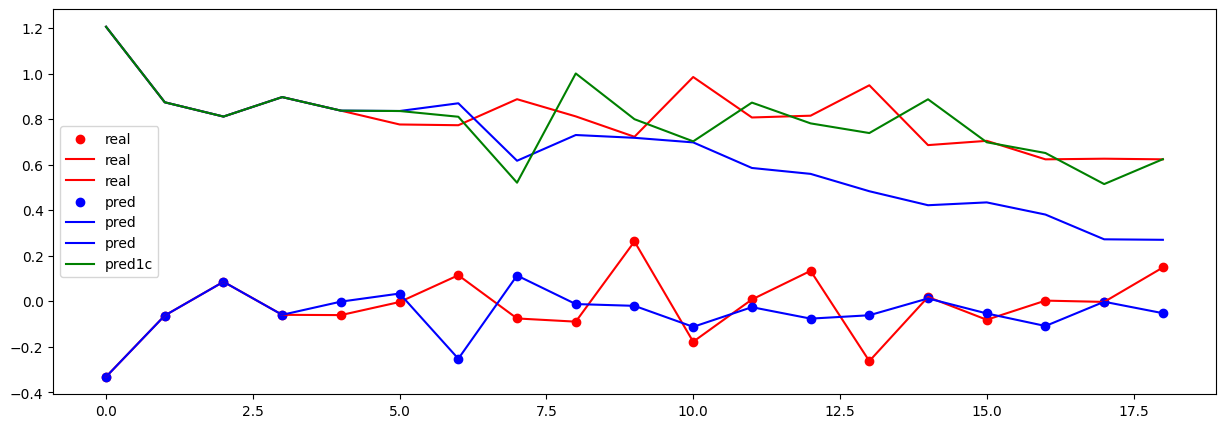

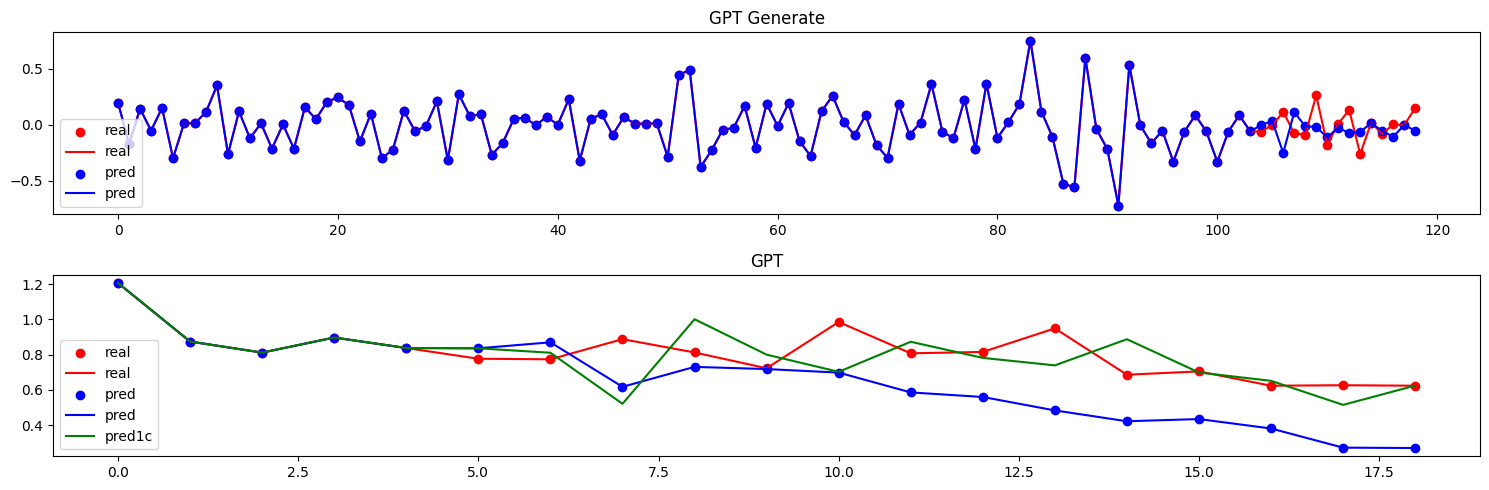

In [102]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk300to400_train )

results_string = function_test_rc(  chunk300to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run4" + "," + "300to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()


torch.Size([200, 25])
0 train loss =  1.3194977045059204
500 train loss =  0.050033241510391235
1000 train loss =  0.01614592783153057
1500 train loss =  0.008711239323019981
2000 train loss =  0.008154811337590218
2500 train loss =  0.0057750968262553215


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


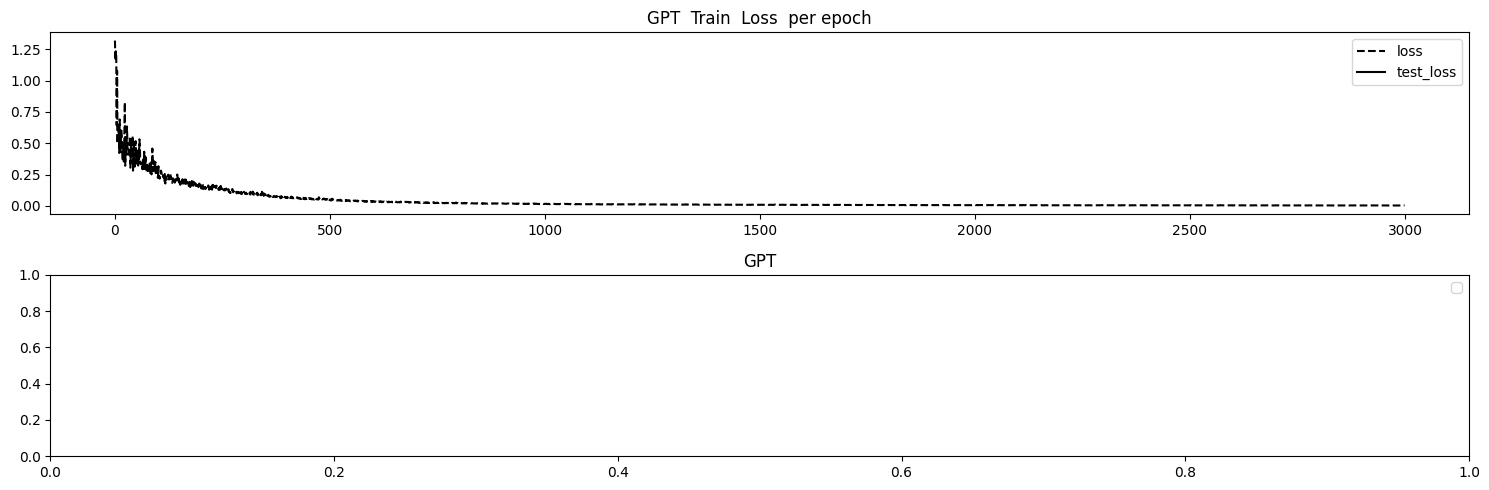

(15, 25)
(200, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.02383270673453808
Test MSE Loss - SI only 0-5:  0.0483187660574913
Test MSE Loss - SI only 5-10:  0.0168258436024189
Test MSE Loss - SI only 10-15:  0.017621250823140144
mae, mse, rmse, mape, mspe, rse, corr
(0.12499144, 0.023832705, 0.15437844, 3.3240805, 41.292347, 1.1190698)
Testing R**2 - SI only:  -0.2523172186693583
Testing R**2 - SI only:  -0.2523172186693583
Testing R**2 - All features:  0.9836694408525546


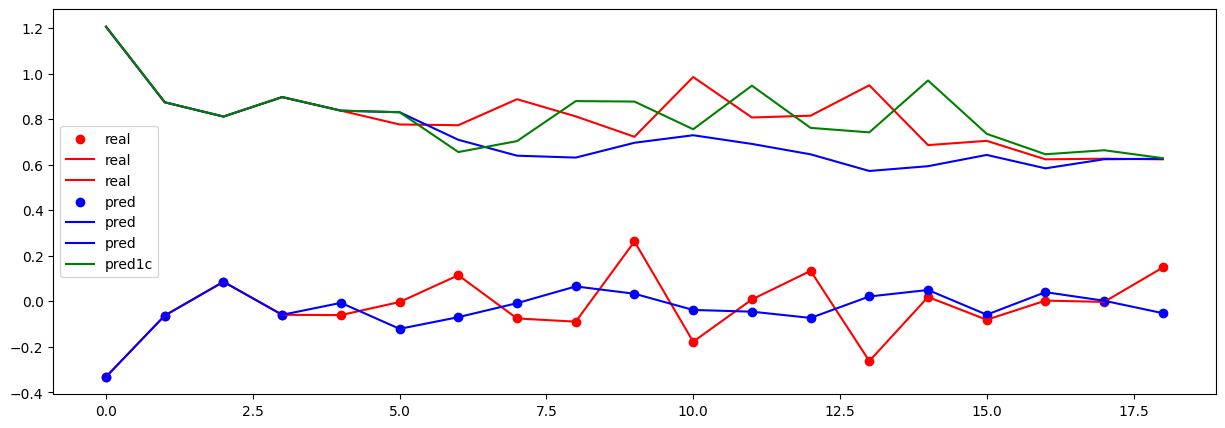

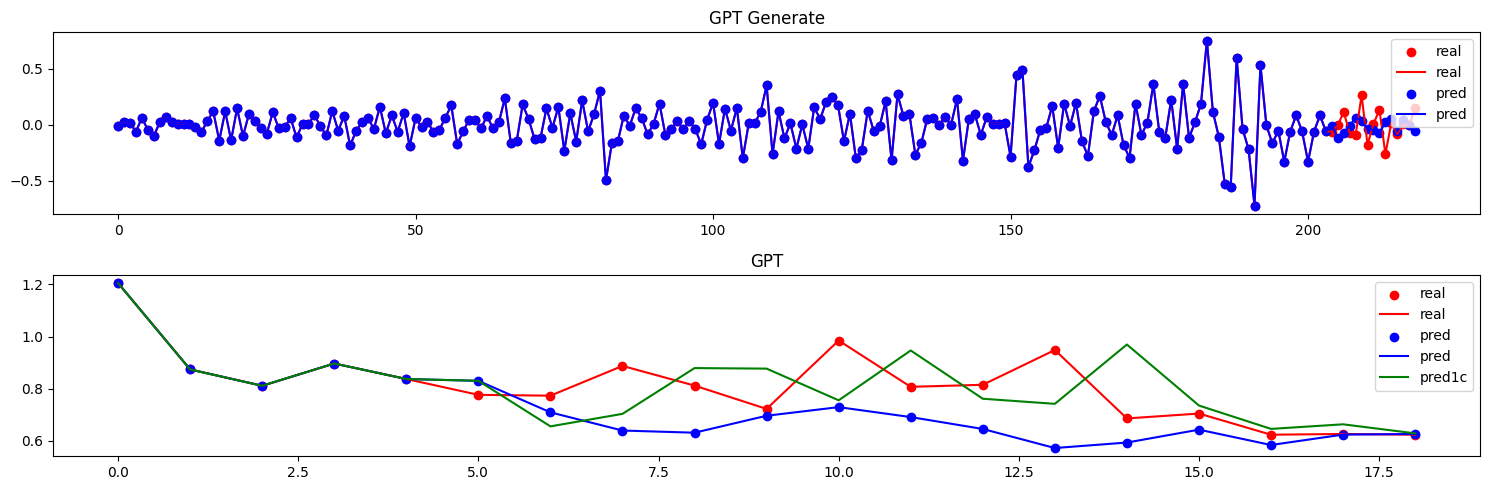

In [103]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk200to400_train )

results_string = function_test_rc(  chunk200to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run4" + "," + "200to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()



torch.Size([300, 25])
0 train loss =  1.1729211807250977
500 train loss =  0.07600457966327667
1000 train loss =  0.02523846924304962
1500 train loss =  0.01359679363667965
2000 train loss =  0.008627211675047874
2500 train loss =  0.006986495107412338


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


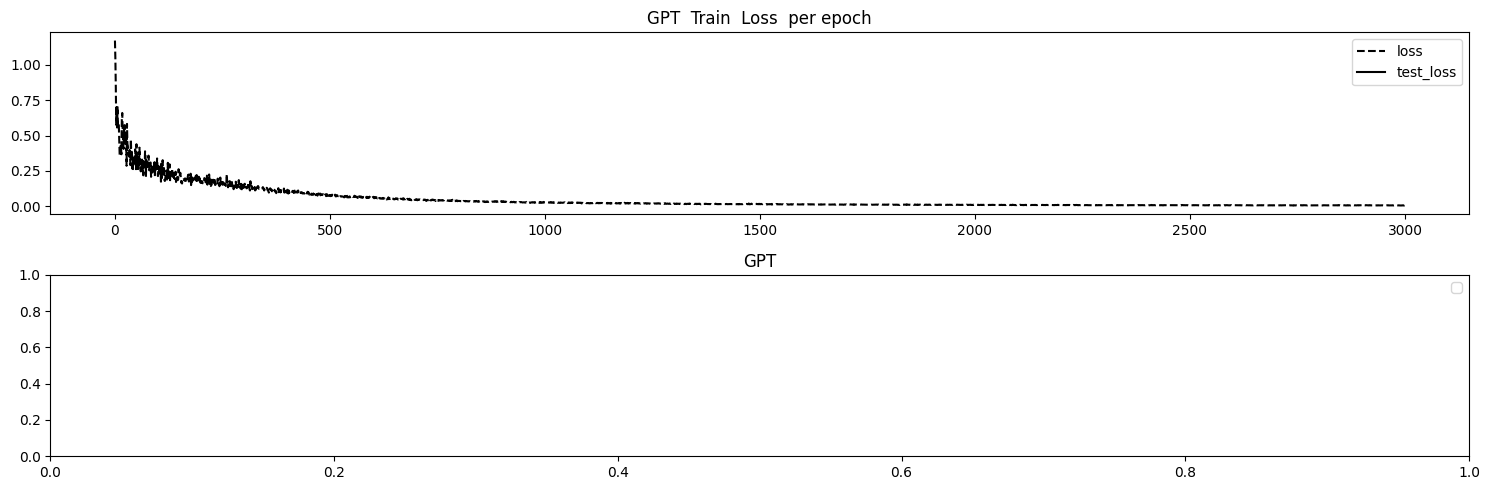

(15, 25)
(300, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.02643921785056591
Test MSE Loss - SI only 0-5:  0.0483187660574913
Test MSE Loss - SI only 5-10:  0.011797129176557064
Test MSE Loss - SI only 10-15:  0.02647637017071247
mae, mse, rmse, mape, mspe, rse, corr
(0.13754244, 0.026439218, 0.16260141, 3.950902, 48.086285, 1.1786771)
Testing R**2 - SI only:  -0.38927958180186595
Testing R**2 - SI only:  -0.38927958180186595
Testing R**2 - All features:  0.9931244449780714


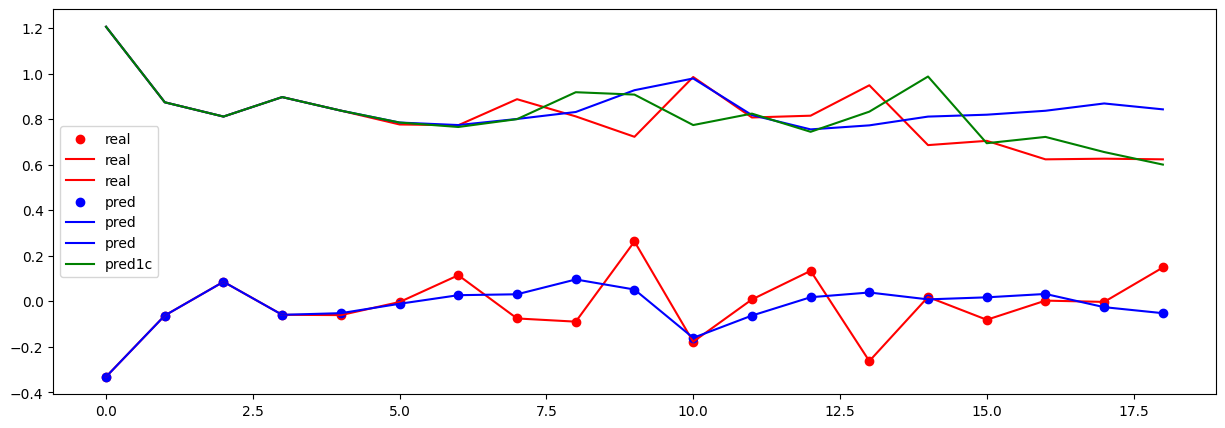

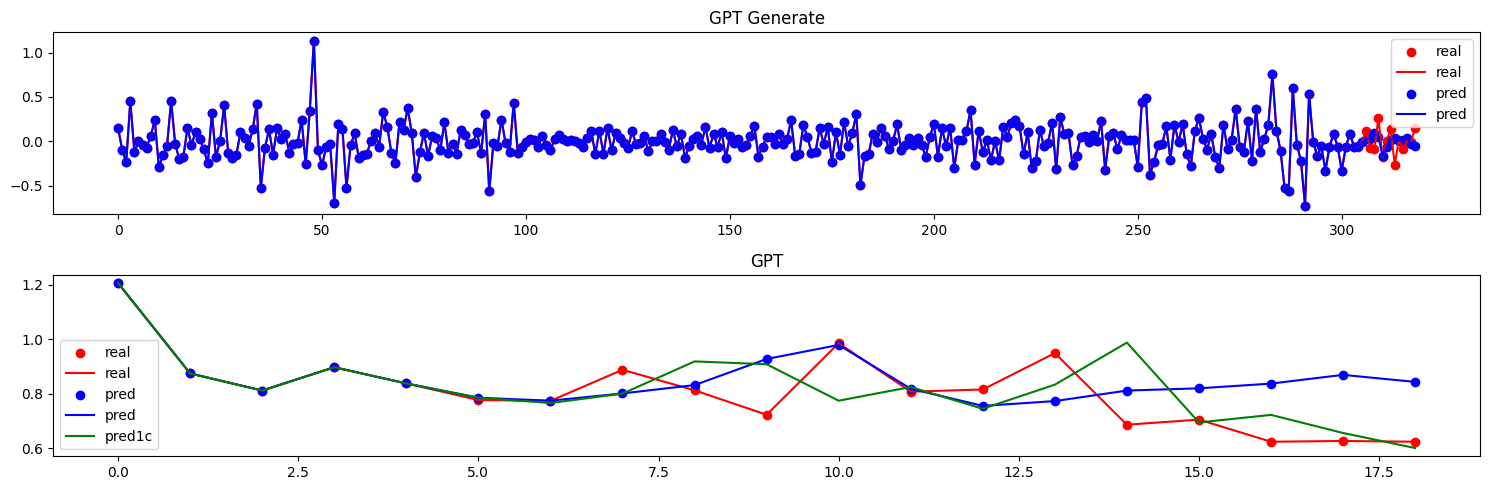

In [104]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk100to400_train  )

results_string = function_test_rc(  chunk100to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run4" + "," + "100to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()



torch.Size([400, 25])
0 train loss =  1.5766522884368896
500 train loss =  0.09149032086133957
1000 train loss =  0.03453716263175011
1500 train loss =  0.01782945729792118
2000 train loss =  0.011028357781469822
2500 train loss =  0.008738419972360134


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


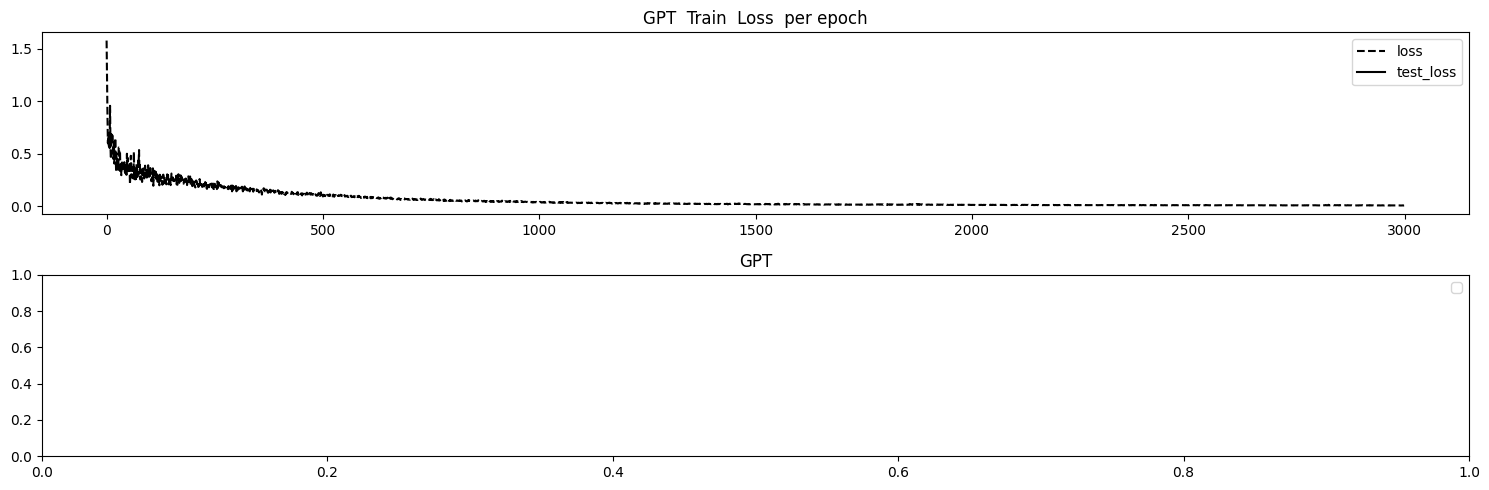

(15, 25)
(400, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.021051499992609024
Test MSE Loss - SI only 0-5:  0.0483187660574913
Test MSE Loss - SI only 5-10:  0.00931482668966055
Test MSE Loss - SI only 10-15:  0.016757158562541008
mae, mse, rmse, mape, mspe, rse, corr
(0.11208552, 0.021051498, 0.14509134, 4.1676445, 112.91771, 1.0517488)
Testing R**2 - SI only:  -0.10617550384104635
Testing R**2 - SI only:  -0.10617550384104635
Testing R**2 - All features:  0.9980110350437814


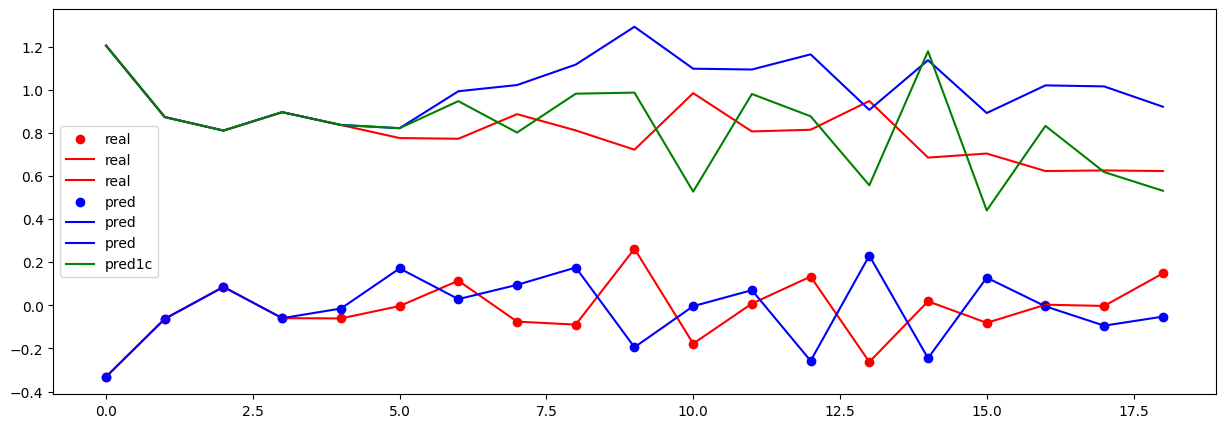

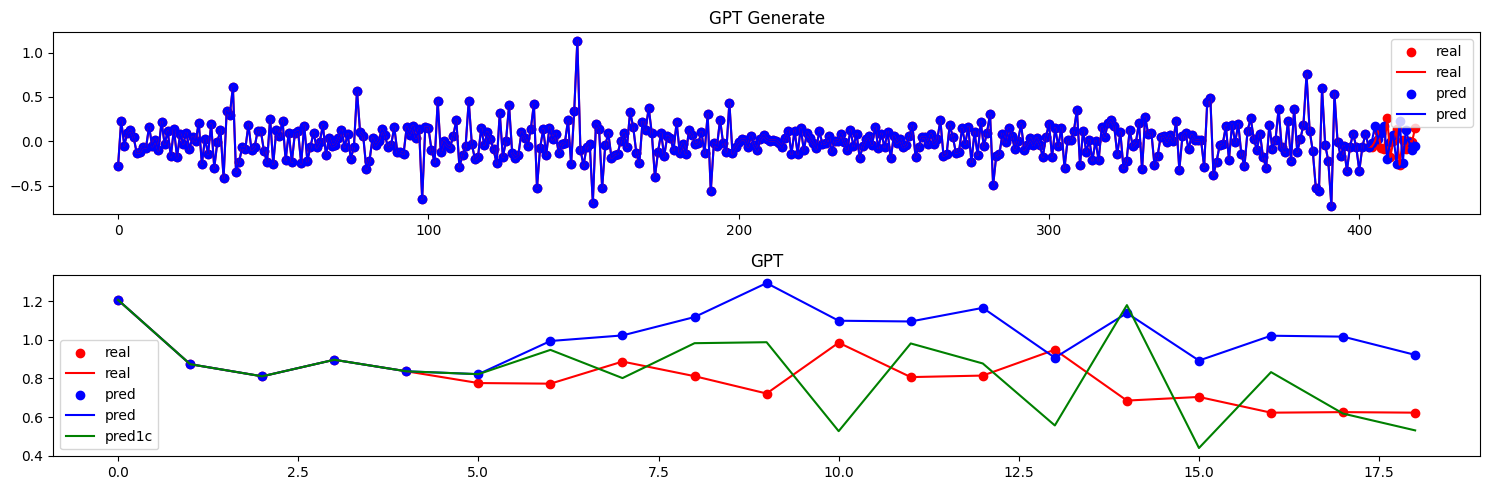

In [105]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk000to400_train )

results_string = function_test_rc(  chunk000to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run4" + "," + "000to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close() 



## Run 5


In [106]:

the_range = training_chunk + block_size

index_to_slice = random.randrange(0, length_n - the_range)

index_to_slice

print( for_RNN_data_CIVS.shape[0] )
print( index_to_slice )
print( index_to_slice + the_range )

sliced_chunk_CIVS = for_RNN_data_CIVS[ index_to_slice : index_to_slice + the_range]

n = block_size

print( n )

train_CIVS       = sliced_chunk_CIVS[   : -n ] 
test_CIVS        = sliced_chunk_CIVS[ -n:   ]

chunk300to400_train = train_CIVS[ 300  :  ] 
chunk200to400_train = train_CIVS[ 200  :  ]  
chunk100to400_train = train_CIVS[ 100  :  ] 
chunk000to400_train = train_CIVS[      :  ] 


print( chunk300to400_train.shape )
print( chunk200to400_train.shape )
print( chunk100to400_train.shape )
print( chunk000to400_train.shape )


1383
912
1327
15
(100, 25)
(200, 25)
(300, 25)
(400, 25)


torch.Size([100, 25])
0 train loss =  1.5928056240081787
500 train loss =  0.017636097967624664
1000 train loss =  0.008358429186046124
1500 train loss =  0.0057821027003228664
2000 train loss =  0.00354505586437881
2500 train loss =  0.003213586751371622


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


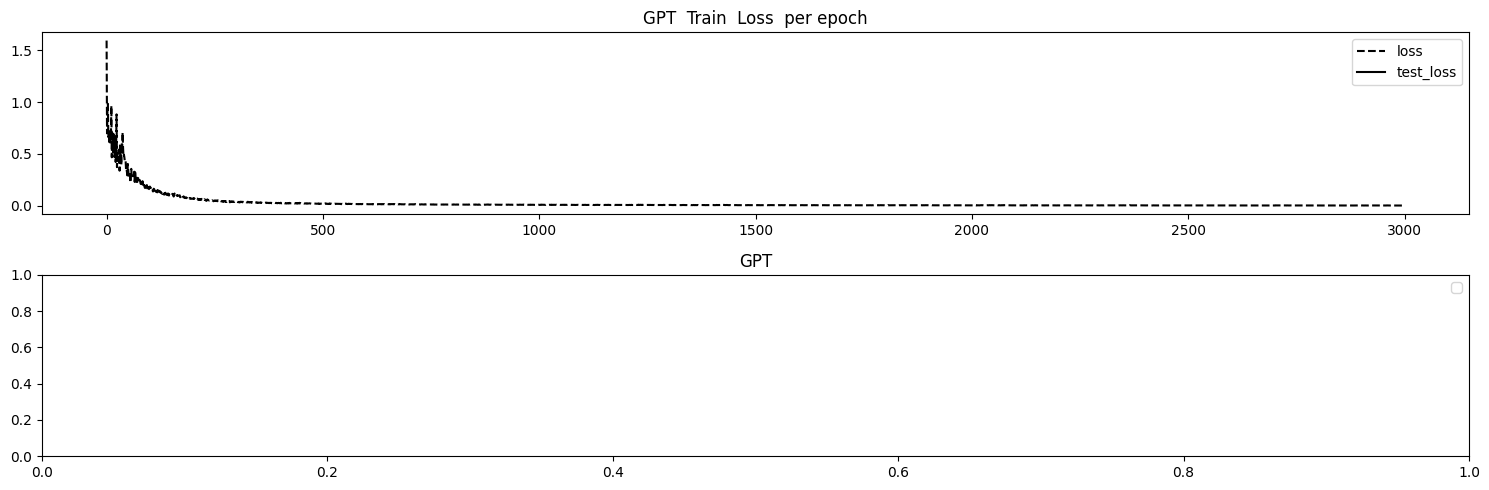

(15, 25)
(100, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.032102927565574646
Test MSE Loss - SI only 0-5:  0.07164955139160156
Test MSE Loss - SI only 5-10:  0.012157578021287918
Test MSE Loss - SI only 10-15:  0.02782355062663555
mae, mse, rmse, mape, mspe, rse, corr
(0.14906718, 0.032102928, 0.1791729, 5.6850796, 105.48023, 1.6862568)
Testing R**2 - SI only:  -1.8434619288736322
Testing R**2 - SI only:  -1.8434619288736322
Testing R**2 - All features:  0.993902994790576


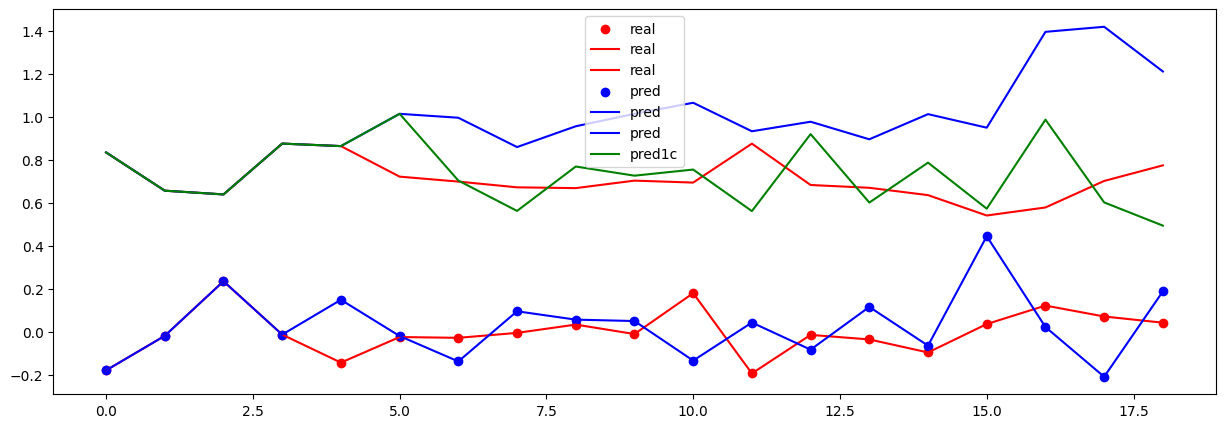

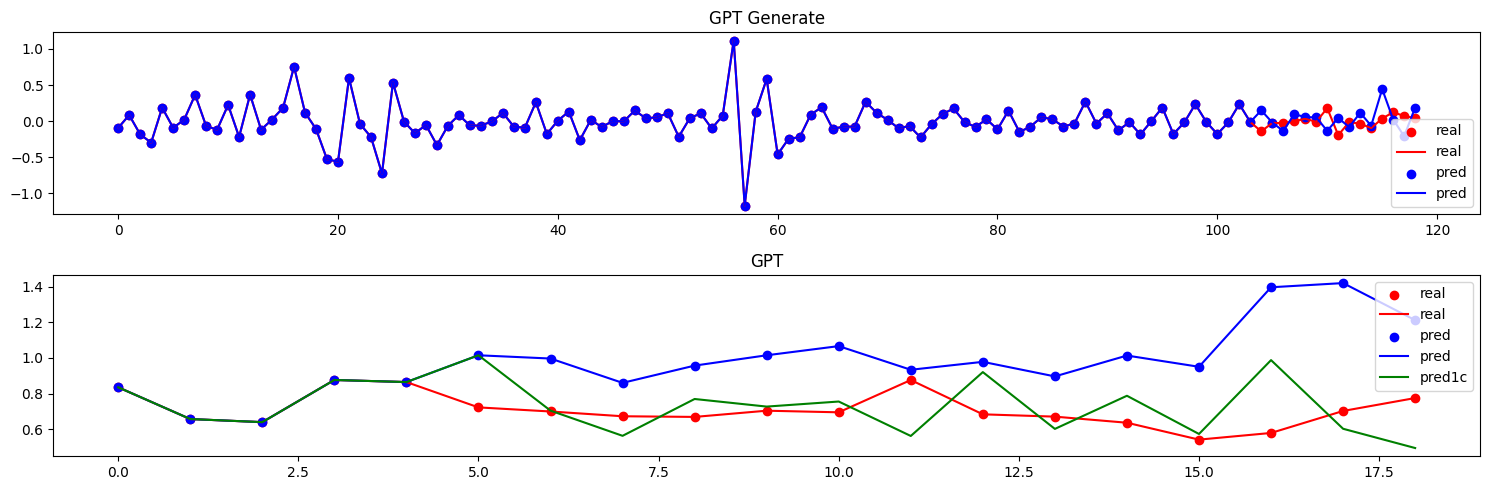

In [107]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk300to400_train )

results_string = function_test_rc(  chunk300to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run5" + "," + "300to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()



torch.Size([200, 25])
0 train loss =  1.1380817890167236
500 train loss =  0.04681988060474396
1000 train loss =  0.016173042356967926
1500 train loss =  0.008836043067276478
2000 train loss =  0.006970785092562437
2500 train loss =  0.004664677195250988


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


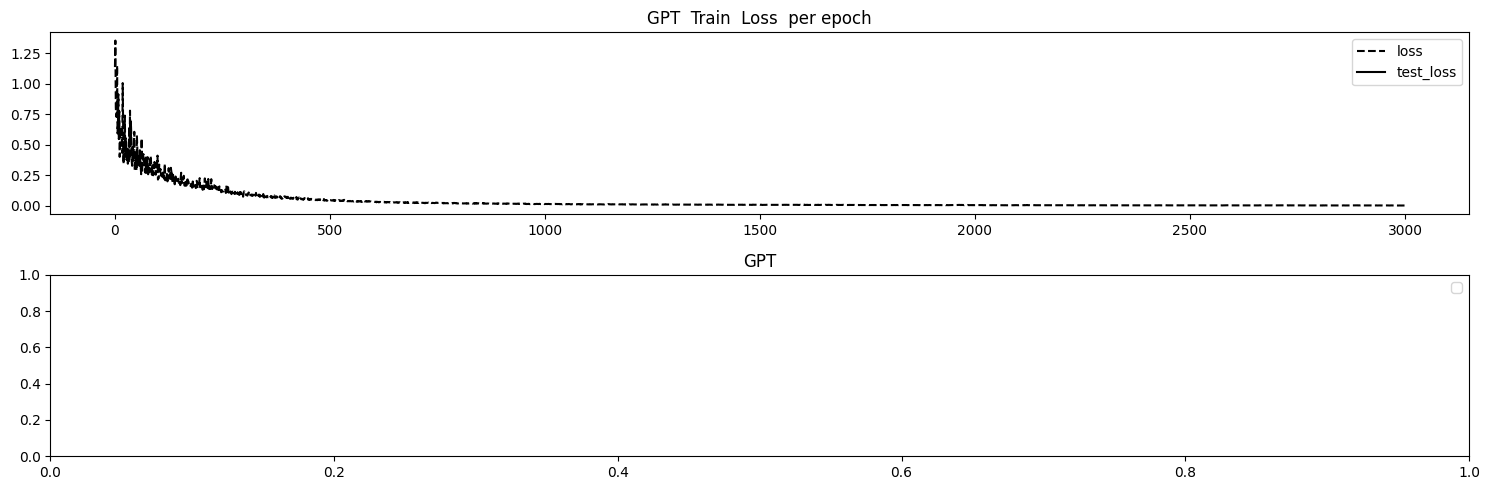

(15, 25)
(200, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.030143816024065018
Test MSE Loss - SI only 0-5:  0.07164955139160156
Test MSE Loss - SI only 5-10:  0.018091728910803795
Test MSE Loss - SI only 10-15:  0.019731542095541954
mae, mse, rmse, mape, mspe, rse, corr
(0.14023307, 0.030143812, 0.17361973, 6.702076, 226.84796, 1.6339941)
Testing R**2 - SI only:  -1.669936751055689
Testing R**2 - SI only:  -1.669936751055689
Testing R**2 - All features:  0.9972280178125158


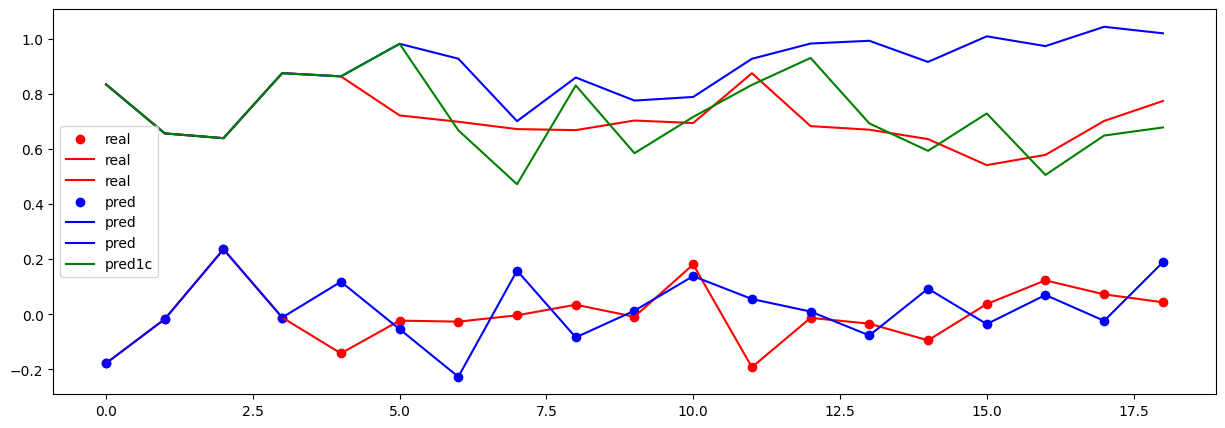

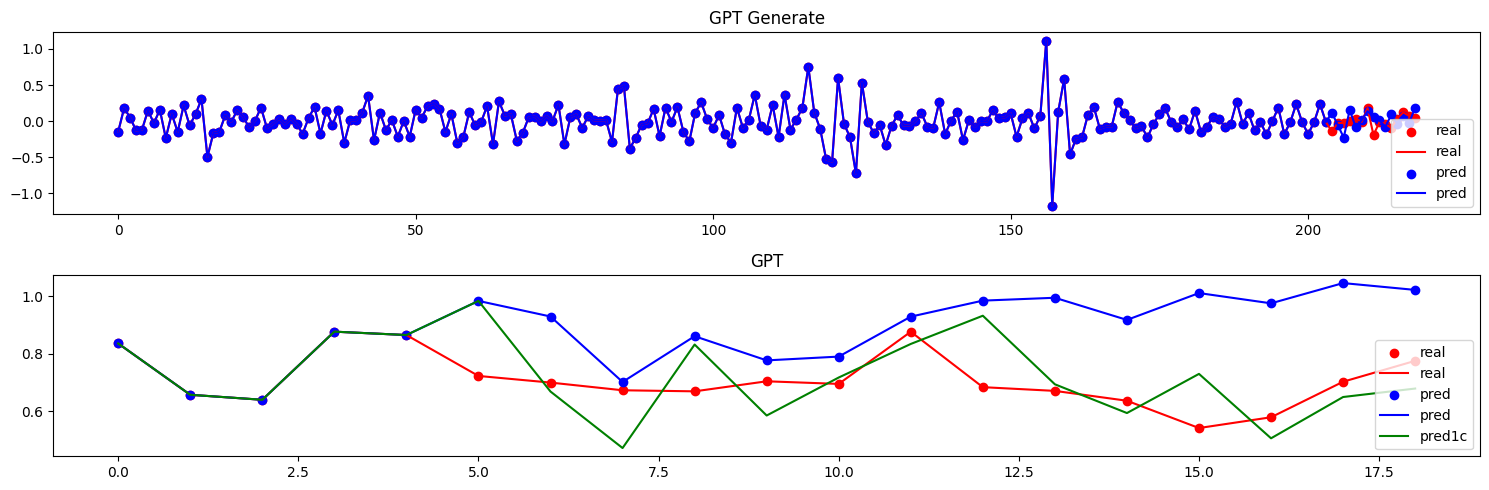

In [108]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk200to400_train )

results_string = function_test_rc(  chunk200to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run5" + "," + "200to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()


torch.Size([300, 25])
0 train loss =  1.2806315422058105
500 train loss =  0.07478410750627518
1000 train loss =  0.02333574742078781
1500 train loss =  0.012041822075843811
2000 train loss =  0.008883289992809296
2500 train loss =  0.006079209037125111


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


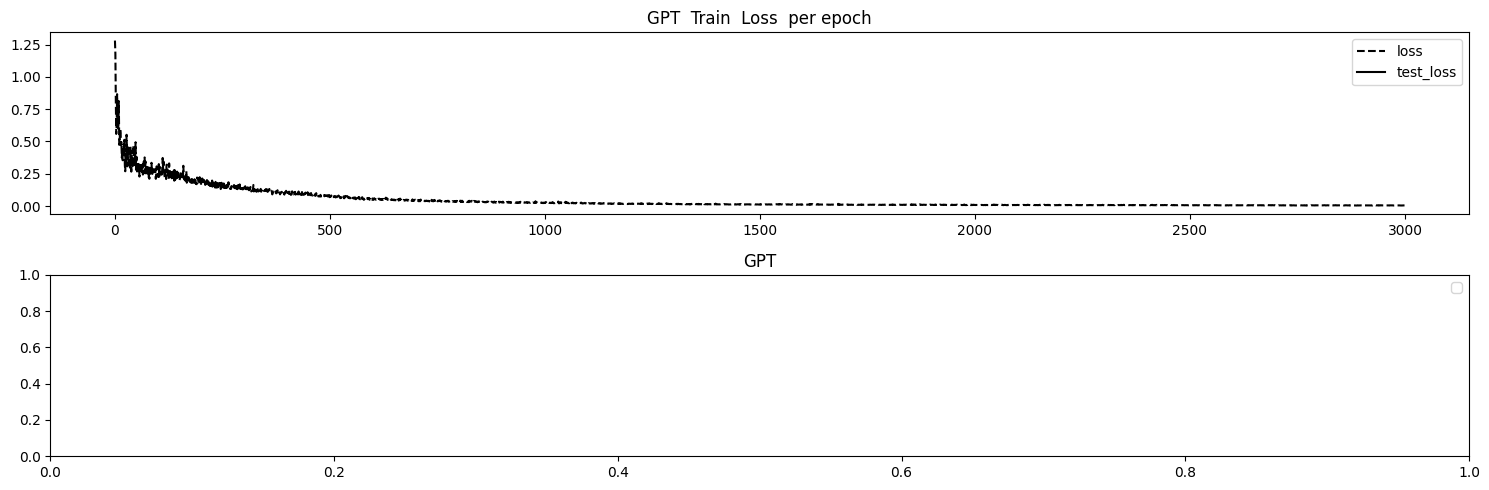

(15, 25)
(300, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.026313070207834244
Test MSE Loss - SI only 0-5:  0.07164955139160156
Test MSE Loss - SI only 5-10:  0.02477463334798813
Test MSE Loss - SI only 10-15:  0.0071891495026648045
mae, mse, rmse, mape, mspe, rse, corr
(0.13247824, 0.026313072, 0.16221304, 7.5514283, 332.18945, 1.526642)
Testing R**2 - SI only:  -1.330635313570124
Testing R**2 - SI only:  -1.330635313570124
Testing R**2 - All features:  0.9978503996739931


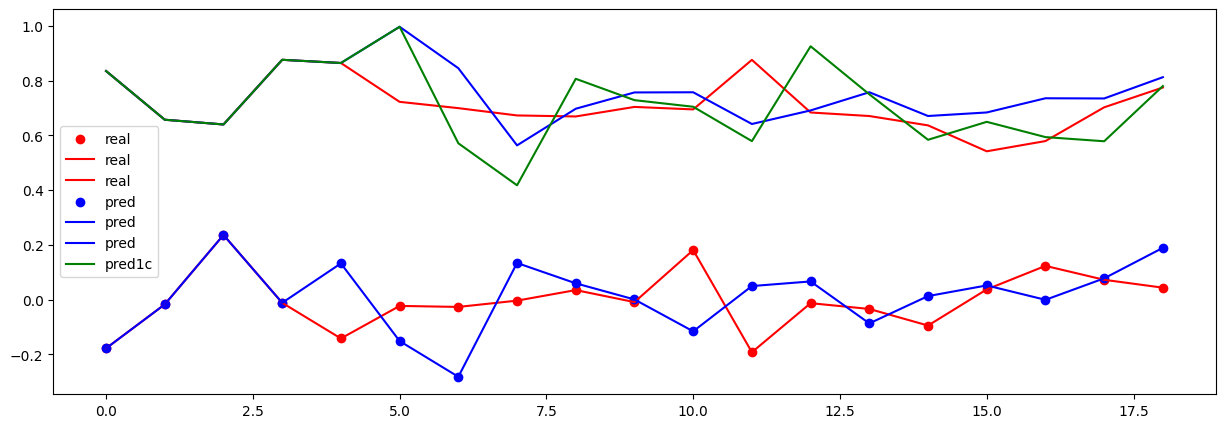

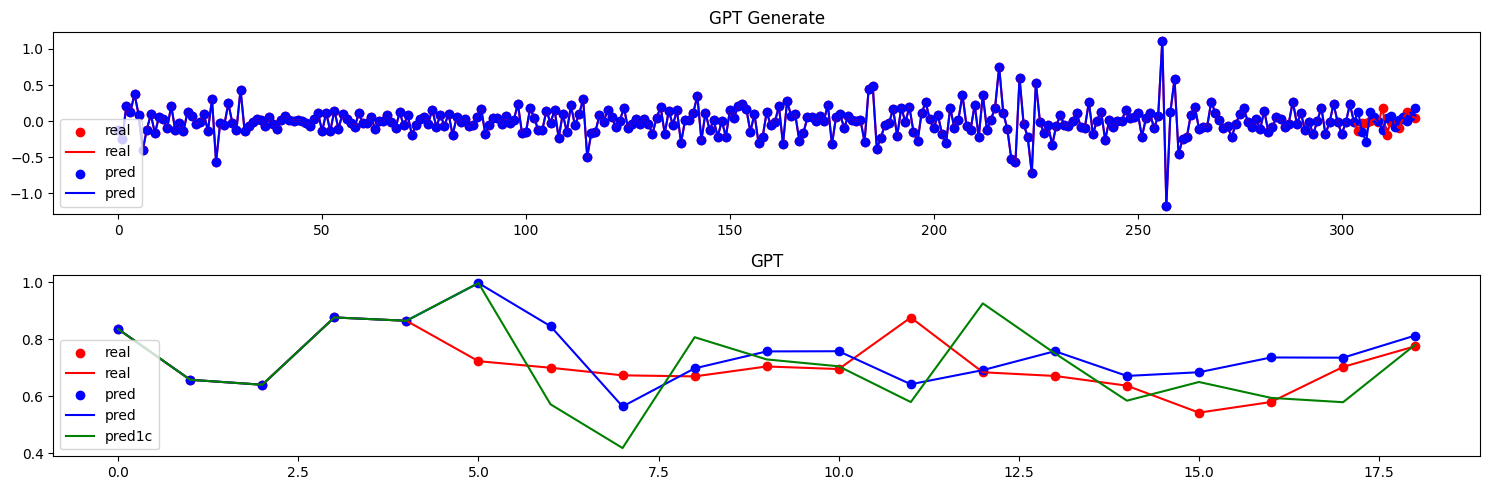

In [109]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk100to400_train  )

results_string = function_test_rc(  chunk100to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run5" + "," + "100to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()


torch.Size([400, 25])
0 train loss =  1.3204107284545898
500 train loss =  0.10473821312189102
1000 train loss =  0.03337129205465317
1500 train loss =  0.01812826097011566
2000 train loss =  0.011967618018388748
2500 train loss =  0.008176634088158607


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


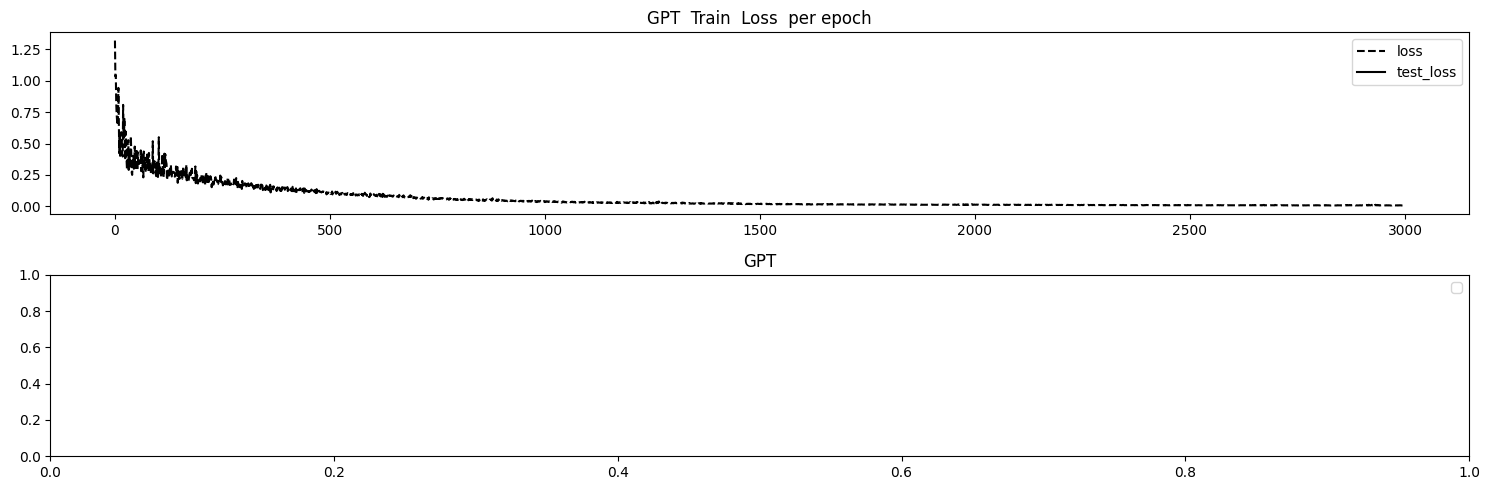

(15, 25)
(400, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.031107550486922264
Test MSE Loss - SI only 0-5:  0.07164955139160156
Test MSE Loss - SI only 5-10:  0.013640515506267548
Test MSE Loss - SI only 10-15:  0.02473358064889908
mae, mse, rmse, mape, mspe, rse, corr
(0.14343451, 0.031107554, 0.17637333, 6.3555694, 200.63615, 1.6599094)
Testing R**2 - SI only:  -1.7552984261469997
Testing R**2 - SI only:  -1.7552984261469997
Testing R**2 - All features:  0.9958718365219703


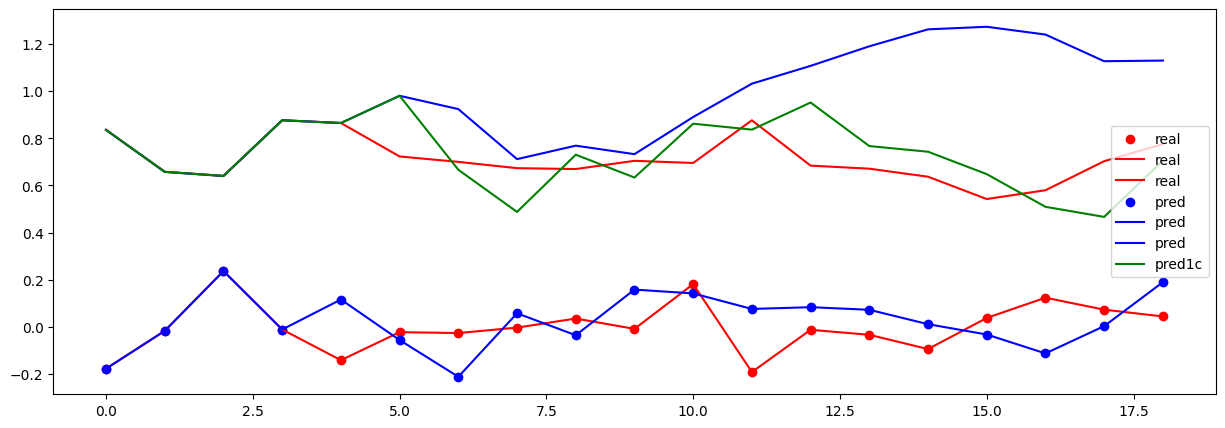

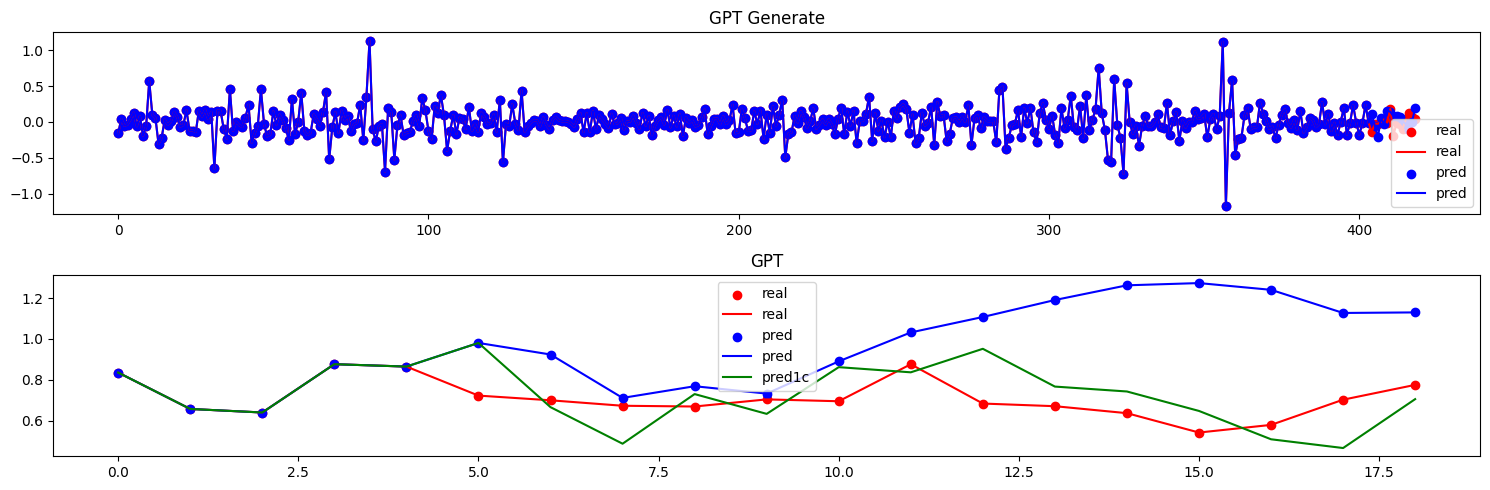

In [110]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk000to400_train )

results_string = function_test_rc(  chunk000to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run5" + "," + "000to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()



## Run 6


In [111]:

the_range = training_chunk + block_size

index_to_slice = random.randrange(0, length_n - the_range)

index_to_slice

print( for_RNN_data_CIVS.shape[0] )
print( index_to_slice )
print( index_to_slice + the_range )

sliced_chunk_CIVS = for_RNN_data_CIVS[ index_to_slice : index_to_slice + the_range]

n = block_size

print( n )

train_CIVS       = sliced_chunk_CIVS[   : -n ] 
test_CIVS        = sliced_chunk_CIVS[ -n:   ]

chunk300to400_train = train_CIVS[ 300  :  ] 
chunk200to400_train = train_CIVS[ 200  :  ]  
chunk100to400_train = train_CIVS[ 100  :  ] 
chunk000to400_train = train_CIVS[      :  ] 


print( chunk300to400_train.shape )
print( chunk200to400_train.shape )
print( chunk100to400_train.shape )
print( chunk000to400_train.shape )


1383
302
717
15
(100, 25)
(200, 25)
(300, 25)
(400, 25)


torch.Size([100, 25])
0 train loss =  1.1575820446014404
500 train loss =  0.019683225080370903
1000 train loss =  0.009052776731550694
1500 train loss =  0.006165484432131052
2000 train loss =  0.004895495716482401
2500 train loss =  0.003201134502887726


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


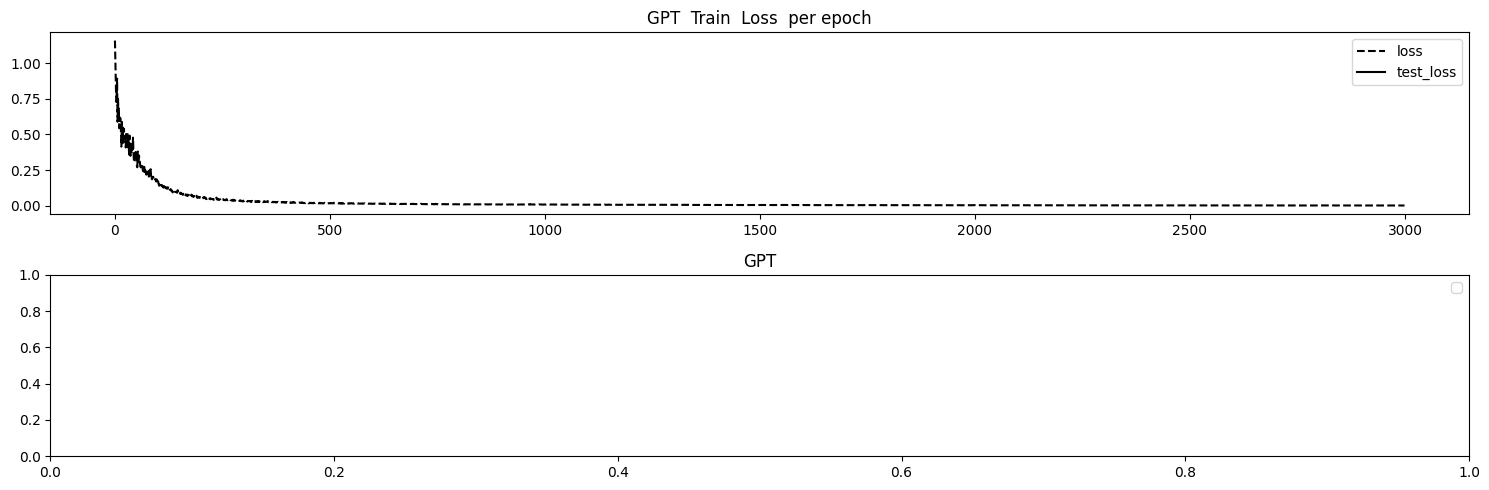

(15, 25)
(100, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.05657000467181206
Test MSE Loss - SI only 0-5:  0.12955230474472046
Test MSE Loss - SI only 5-10:  0.020992867648601532
Test MSE Loss - SI only 10-15:  0.047851525247097015
mae, mse, rmse, mape, mspe, rse, corr
(0.16498002, 0.056570005, 0.2378445, 5.0542693, 283.12408, 1.4598625)
Testing R**2 - SI only:  -1.1311988556554868
Testing R**2 - SI only:  -1.1311988556554868
Testing R**2 - All features:  0.9537797991823211


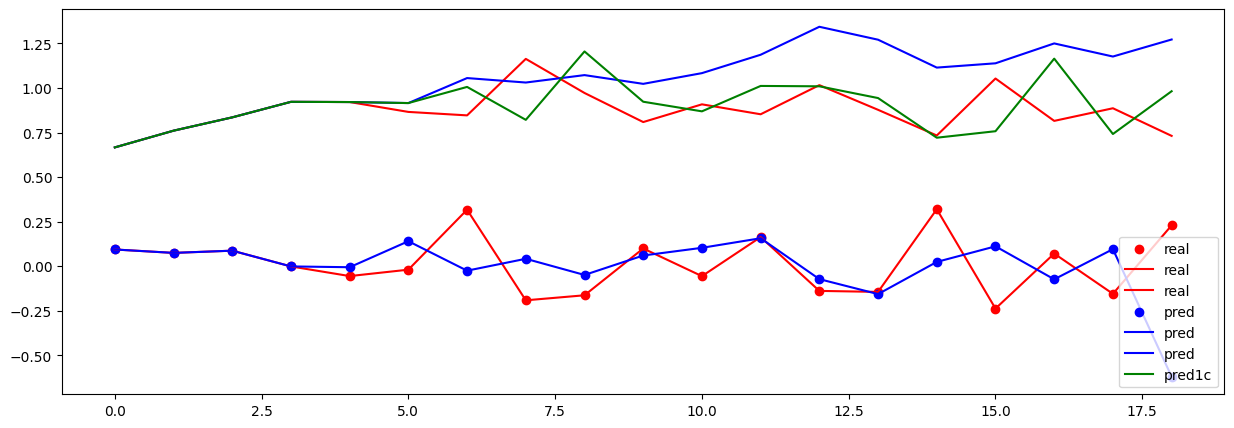

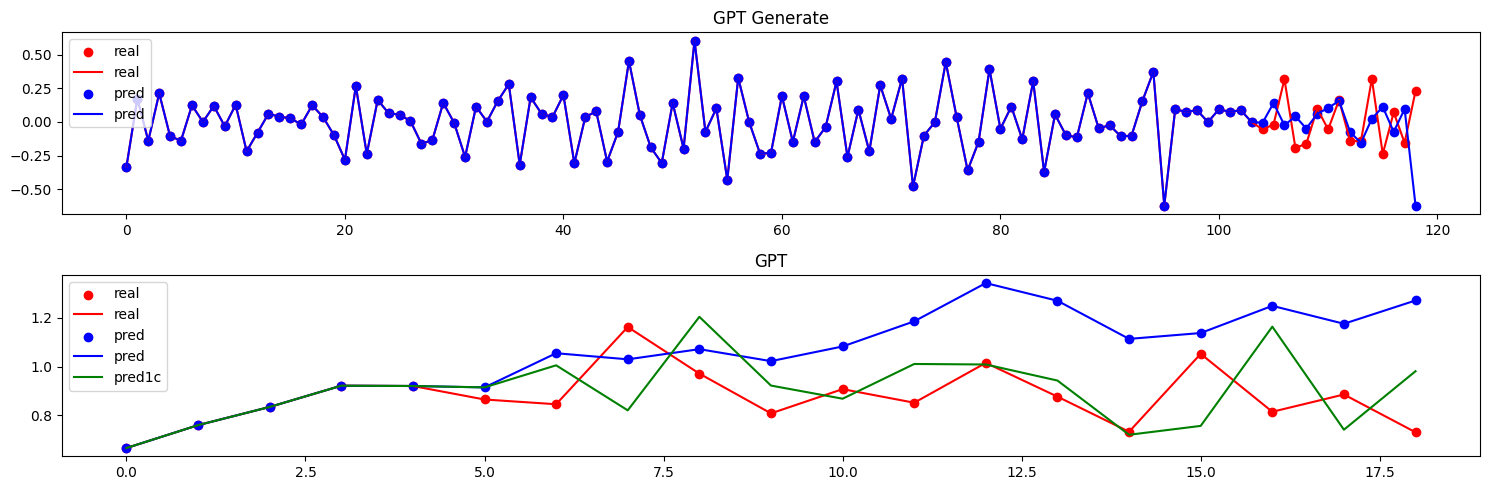

In [112]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk300to400_train )

results_string = function_test_rc(  chunk300to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run6" + "," + "300to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()



torch.Size([200, 25])
0 train loss =  1.7069458961486816
500 train loss =  0.04545324295759201
1000 train loss =  0.017187342047691345
1500 train loss =  0.01074082963168621
2000 train loss =  0.007919171825051308
2500 train loss =  0.004928529262542725


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


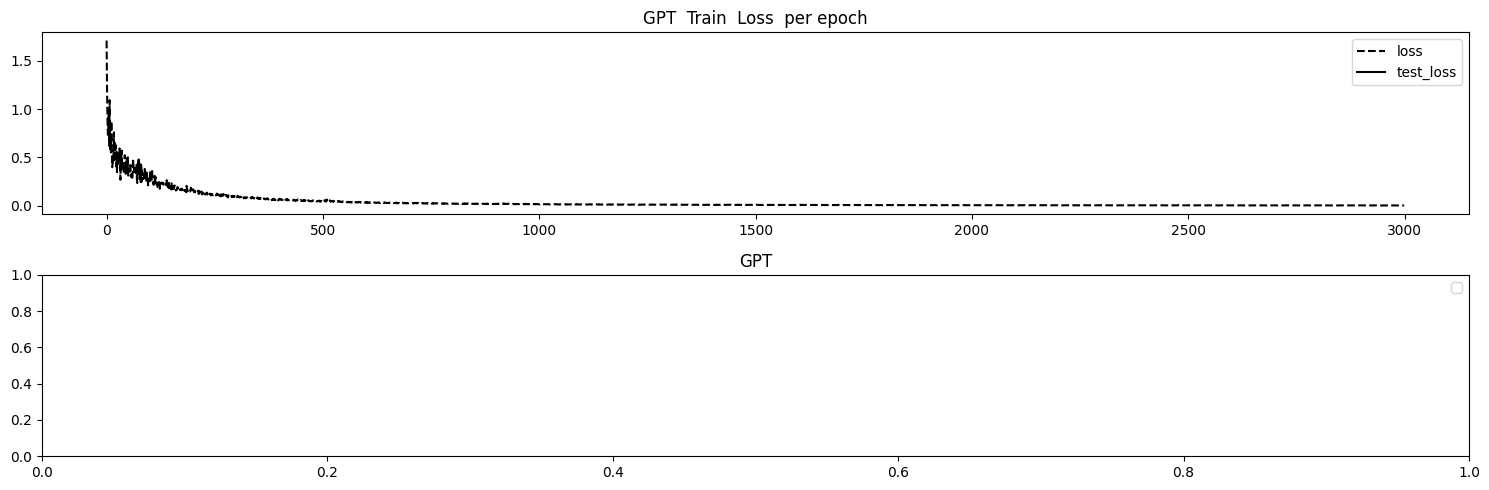

(15, 25)
(200, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.07597929239273071
Test MSE Loss - SI only 0-5:  0.12955230474472046
Test MSE Loss - SI only 5-10:  0.05795272812247276
Test MSE Loss - SI only 10-15:  0.06418675929307938
mae, mse, rmse, mape, mspe, rse, corr
(0.21644826, 0.07597929, 0.2756434, 5.73799, 287.43826, 1.691868)
Testing R**2 - SI only:  -1.862417293203026
Testing R**2 - SI only:  -1.862417293203026
Testing R**2 - All features:  0.994508801304151


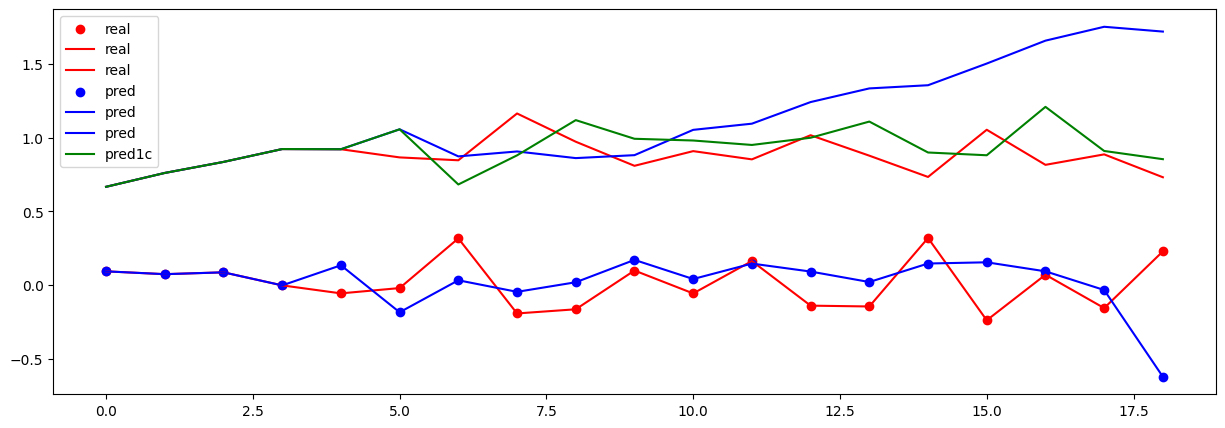

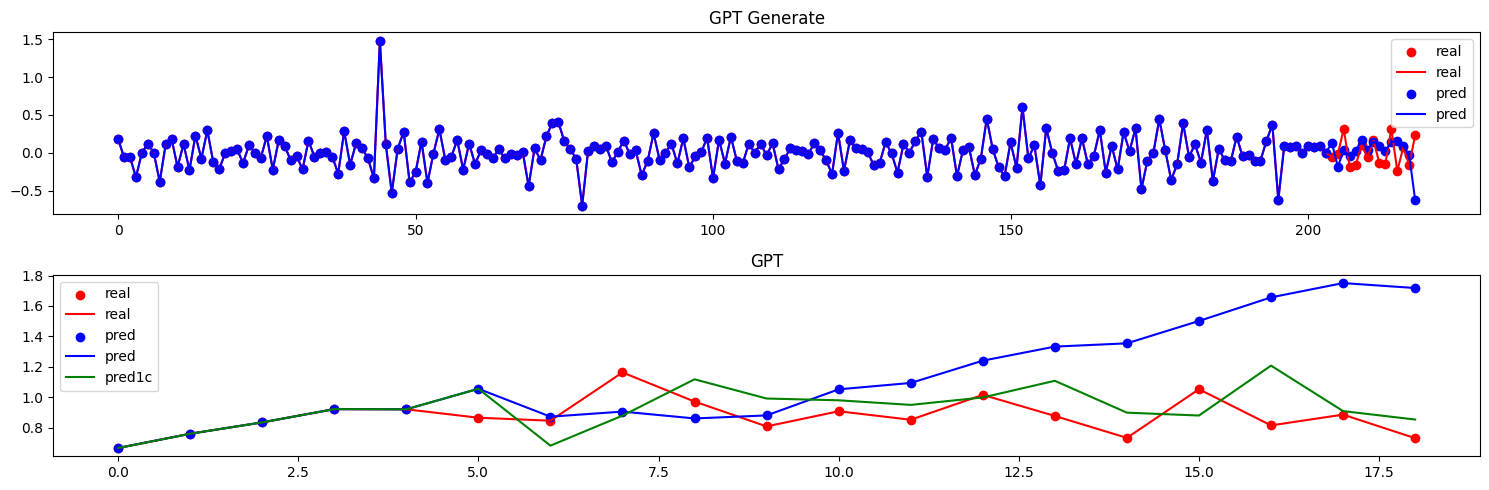

In [113]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk200to400_train )

results_string = function_test_rc(  chunk200to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run6" + "," + "200to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()


torch.Size([300, 25])
0 train loss =  1.4755486249923706
500 train loss =  0.07758111506700516
1000 train loss =  0.027701953426003456
1500 train loss =  0.014716621488332748
2000 train loss =  0.00974538829177618
2500 train loss =  0.006276640109717846


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


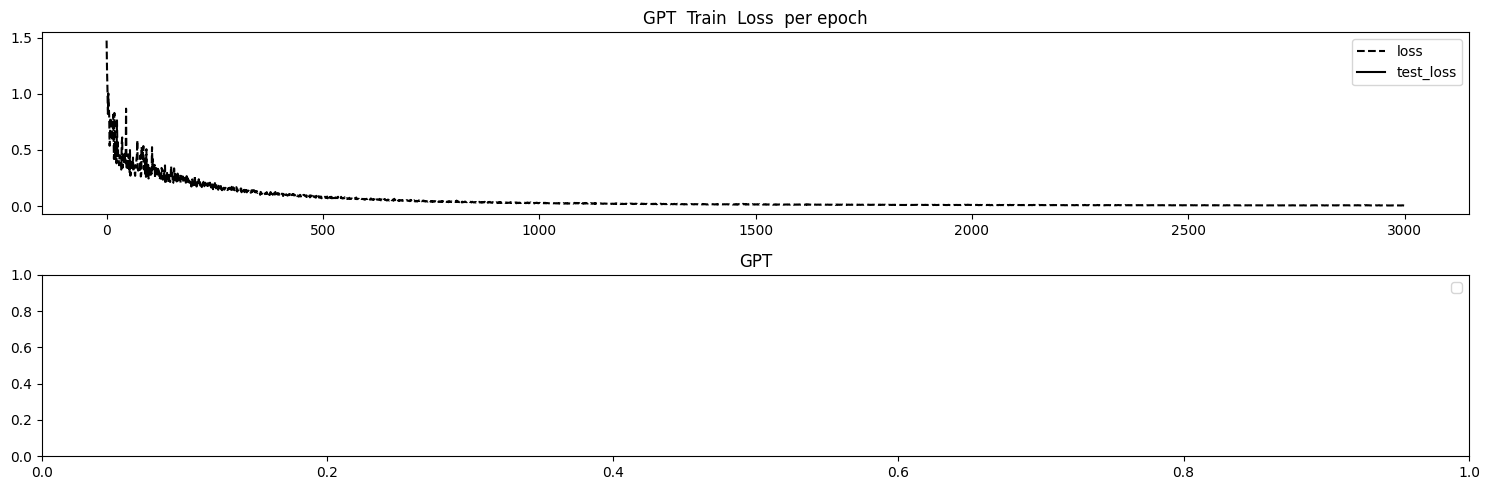

(15, 25)
(300, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.0890064463019371
Test MSE Loss - SI only 0-5:  0.12955230474472046
Test MSE Loss - SI only 5-10:  0.07640445232391357
Test MSE Loss - SI only 10-15:  0.07938740402460098
mae, mse, rmse, mape, mspe, rse, corr
(0.22565824, 0.089006454, 0.2983395, 5.550775, 285.08957, 1.831174)
Testing R**2 - SI only:  -2.3531981180396864
Testing R**2 - SI only:  -2.3531981180396864
Testing R**2 - All features:  0.9901478938408174


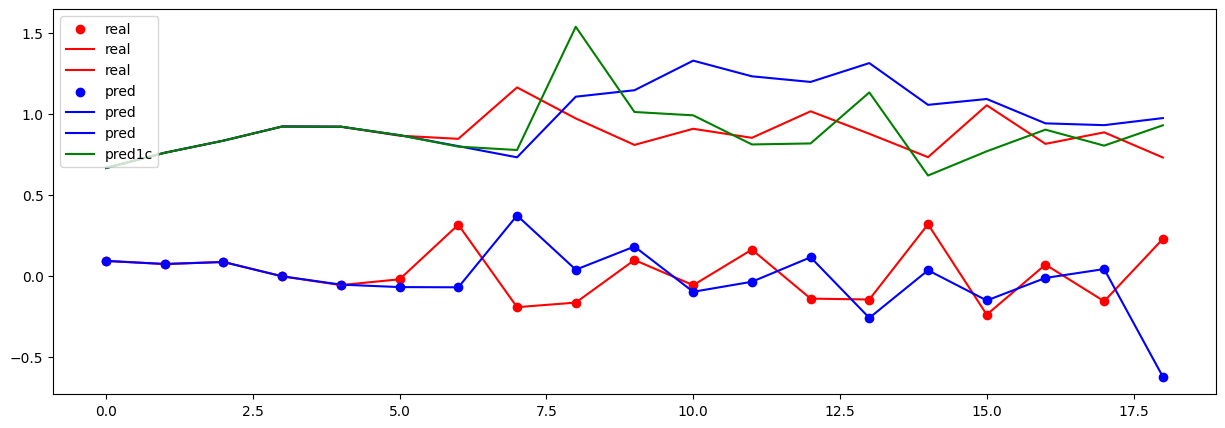

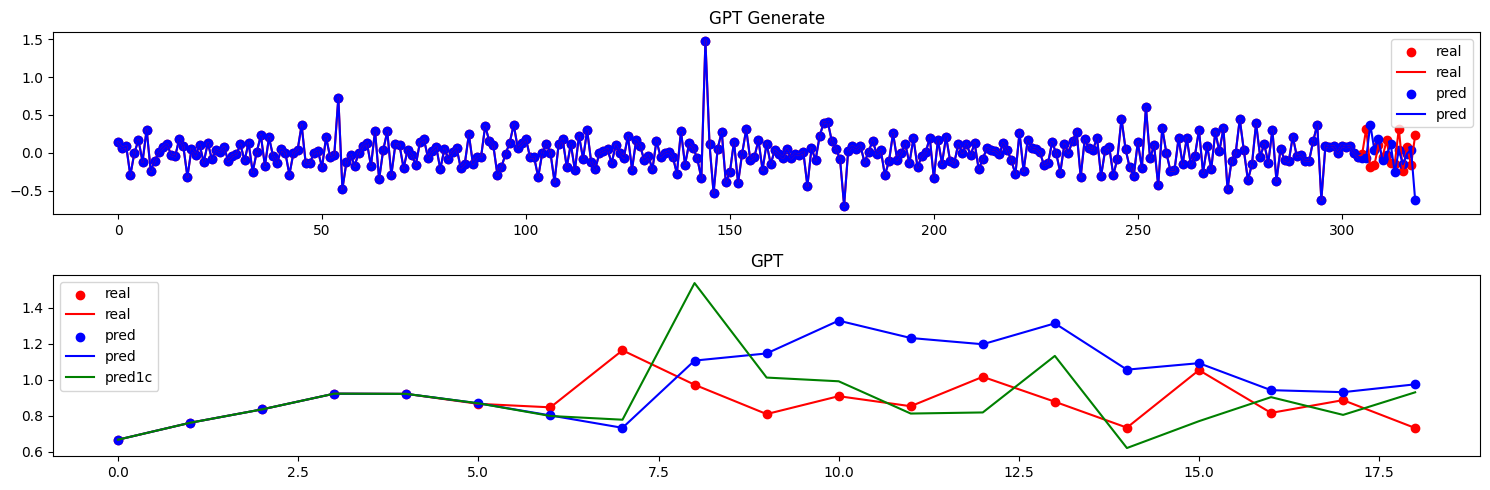

In [114]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk100to400_train  )

results_string = function_test_rc(  chunk100to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run6" + "," + "100to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()


torch.Size([400, 25])
0 train loss =  1.3972721099853516
500 train loss =  0.1132231131196022
1000 train loss =  0.03994067385792732
1500 train loss =  0.01726563461124897
2000 train loss =  0.01448921486735344
2500 train loss =  0.009210686199367046


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


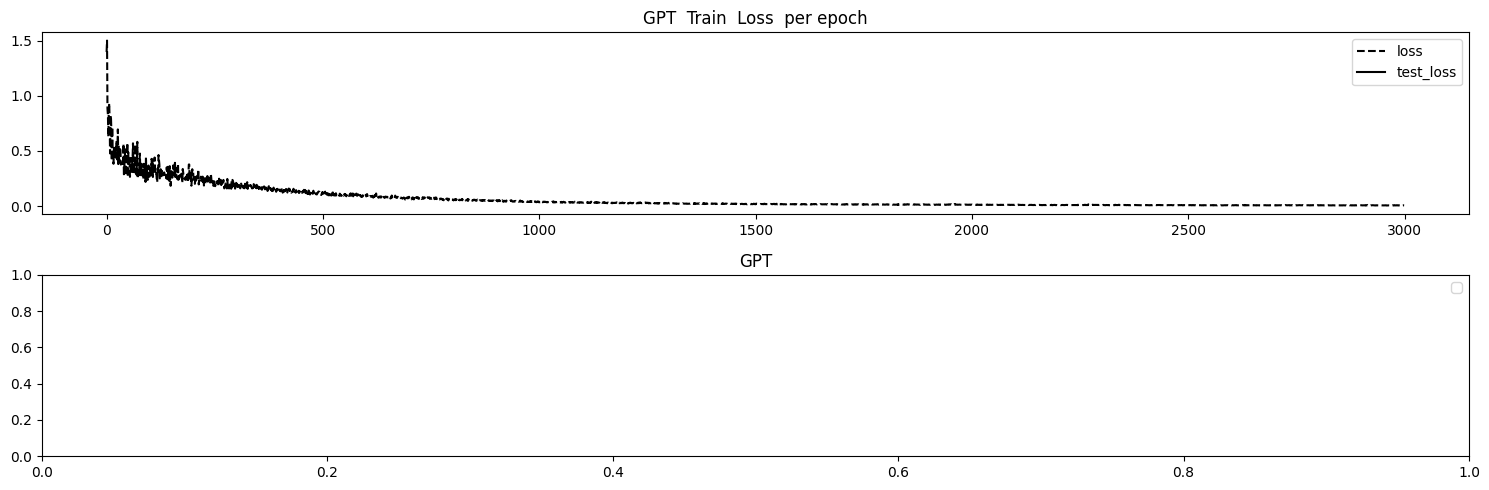

(15, 25)
(400, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.06855671852827072
Test MSE Loss - SI only 0-5:  0.12955230474472046
Test MSE Loss - SI only 5-10:  0.08417699486017227
Test MSE Loss - SI only 10-15:  0.031034039333462715
mae, mse, rmse, mape, mspe, rse, corr
(0.1944449, 0.06855671, 0.26183337, 5.643835, 288.07727, 1.6071036)
Testing R**2 - SI only:  -1.5827816788600697
Testing R**2 - SI only:  -1.5827816788600697
Testing R**2 - All features:  0.965270658931155


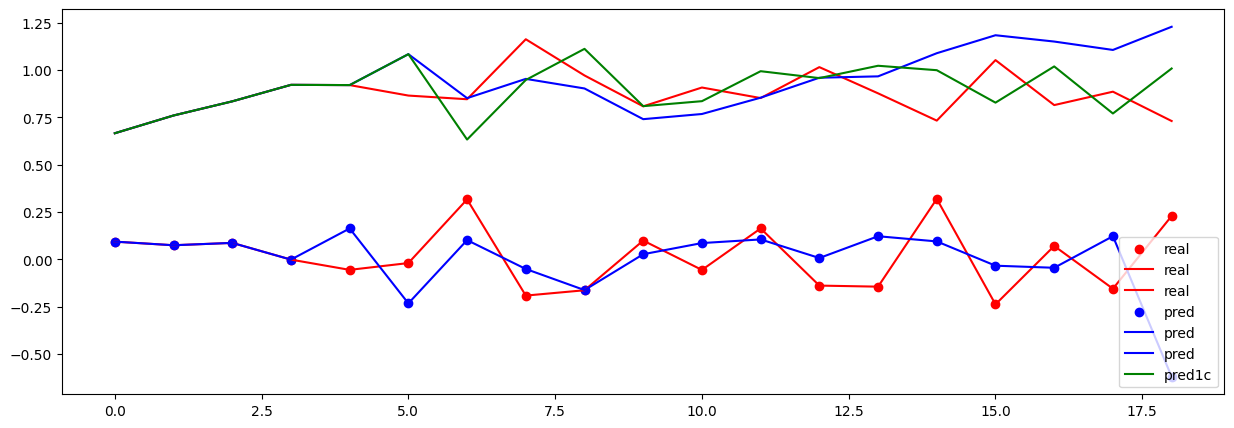

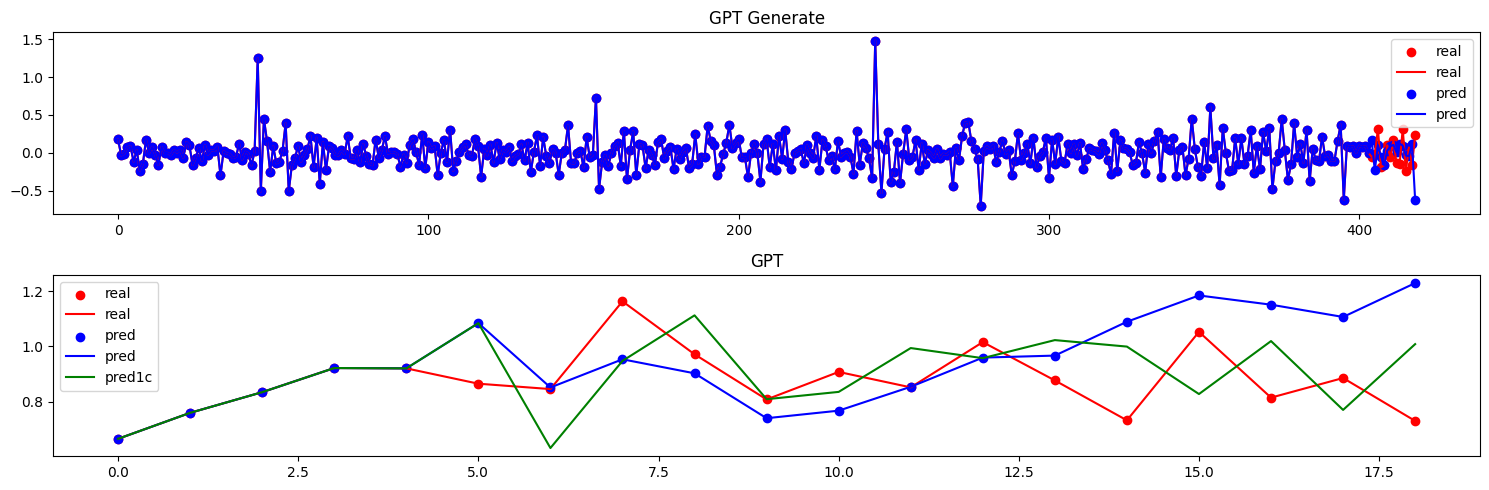

In [115]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk000to400_train )

results_string = function_test_rc(  chunk000to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run6" + "," + "000to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()
